# Final Project Submission

Please fill out:
* Student name: **Brian Bentson**
* Student pace: self paced / part time / full time: **Full Time**
* Scheduled project review date/time:
* Instructor name: **James Irving**
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

# Table of Contents

*Click to jump to matching Markdown Header.*<br>
 
- **[INTRODUCTION](#INTRODUCTION)<br>**
- **[DATA COLLECTION](#DATA-COLLECTION)**<br>
- **[DATA CLEANING](#DATA-CLEANING)**<br>
- **[DATA EXPLORATION](#DATA-EXPLORATION)**<br>
- **[DATA MODELING](#DATA-MODELING)**<br>
- **[DATA INTERPRETATION](#DATA-INTERPRETATION)**<br>
- **[RECOMMENDATIONS AND CONCLUSIONS](#RECOMMENDATIONS-AND-CONCLUSIONS)<br>**

# INTRODUCTION

The Tanzanian Ministry of Water tracks vital information on water wells in its country to best ensure citizens are provided with a continual source of fresh water. A dataset housing this crucial information can be found [HERE](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/). 

I will be utilizing this dataset to train a classification model to accurately predict which water wells are not functional and also to gain insights into potential reasons for water well failures.

## Business Statement

It is undoubtedly obvious how crucial a consistent water supply is to every living thing in this world. Without it, life is not sustainable. A human can survive without food on average for about 1 to 2 months. However, a human can only survive 3 days without water! This time-frame without water can be shortened even further in climates which are extremely hot and humid. Tanzania, located on the east coast of Africa on the Indian Ocean, has parts of the country that are extremely hot and humid. The average high and low temperature in the most populous city of Dar es Salaam during the year is 86$^\circ$F and 70$^\circ$F, respectively. Dar es Salaam is located on the coast and has a average relative humidity of 70%. 

It is, therefore, extremely imperative to be able to supply a consistent source of fresh water for sustainment of human life in Tanzania. This begins with the evaluation of water wells in Tanzania with an emphasis on how reliability can be maximized to ensure a consistent supply of water is attainable. Unfortunately, our reliance on equipment (in this case a mechanical pump) means that 100% reliability can never be achieved. It is best to consider both reliability of the equipment and how quickly we can respond to an equipment failure and get it back to a running state. The response time to fixing a mechanical failure can be shortened with first predicting which water wells will fail. This key information can help maintenance organizations to ensure they have labor, tools and supplies ready to be mobilized in case of a failure. I will use machine learning to build a model to best predict water well failures in an attempt to understand what improvements can be made to factors such as funding, technology and maintenance operations.



## Analysis Methodology

The dataset has information on 59,400 water wells in Tanzania, for which only 55% are fully operational based on this dataset. Information on these water wells includes many important factors that impact their operability and will be explored in order to provide insight into how reliability, and therefore accessibility, can be maximized. I will clean and explore the data to best be utilized with a classification machine learning model to predict failure. 

More specifically, I believe the best model will prioritize determining which wells are not functioning even if that means that there are false positives. This is primarily due to the high cost of leaving a subset of the population without water for any given time. This approach will mean more money and time is spent on preventative maintenance ahead of the well failing, but should ensure the best reliability. In the context of a classification model, the model will be evaluated to maximize recall. Recall aims to maximize identifying true positives even if it means there will be false negatives.

# DATA COLLECTION

## Import Packages

In [463]:
#data wrangling and visualization packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import scipy.stats as stats
#feature engineering packages
from sklearn.impute import SimpleImputer
from feature_engine import imputation as mdi

#feature selection packages
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures

#modeling packages
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

#modeling evaluation packages
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.metrics import get_scorer

#optimization packages
from sklearn.model_selection import GridSearchCV

In [464]:
#notebook settings
pd.set_option("display.max_columns", 40)
pd.options.display.float_format = '{:,}'.format

import warnings
warnings.filterwarnings('ignore')

## Global Functions

In [465]:
def col_eval(df, num_col=None, cat_col=None, y_col='status_group', label_count=25, thresh=0.025):
    '''
    This function evaluates a single numeric feature or a list of categorical 
    features for feature engineering. It takes in a dataframe, a feature(s)
    and provides detailed descriptive statistics and draws 4 informative graphs. 
    '''
    if num_col != None:
        #print the column name
        print(f'Column Name: {num_col}')
        print('\n')
        #print the number of unique values
        print(f'Number of unique values: {df[num_col].nunique()}')
        print('\n')
        #print the number of duplicate values
        print(f'There are {df[num_col].duplicated().sum()} duplicates')
        print('\n')
        #print the number of null values
        print(f'There are {df[num_col].isna().sum()} null values')
        print('\n')
        #print the number of values equal to 0
        print(f'There are {(df[num_col] == 0).sum()} zeros')
        print('\n')
        #print the value counts percentage
        print('Value Counts Percentage', '\n', 
              df[num_col].value_counts(normalize=True, dropna=False).round(2)*100)
        print('\n')
        #print descriptive statistics
        print('Descriptive Metrics:','\n',
              df[num_col].describe())
        #plot boxplot, histogram         
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
        
        histogram = df[num_col].hist(ax=ax[0,0])
        ax[0,0].set_title(f'Distribution of {num_col}');
        
        scatter = df.plot(kind='scatter', x=num_col, y=y_col,ax=ax[0,1]);
        ax[0,1].set_title(f'{y_col} vs {num_col}');

        boxplot = df.boxplot(column=num_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {num_col}');

        sm.graphics.qqplot(df[num_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {num_col}');
        plt.tight_layout()

        plt.show()
        return
    
    else:
        
        for col in cat_col:
            print('=============================================================')
            #print the column name
            print(f'Column Name: {col}')
            print('\n')
            #print the number of unique values
            print(f'Number of unique values: {df[col].nunique()}')
            print('\n')
            #print the number of duplicate values
            print(f'There are {df[col].duplicated().sum()} duplicates')
            print('\n')
            #print the number of null values
            print(f'There are {df[col].isna().sum()} null values')
            print('\n')
            #print the number of values equal to '0'
            print(f'There are {(df[col] == "0").sum()} zeros')
            print('\n')
            #print the value counts percentage
            print('Value Counts Percentage', '\n', 
                  df[col].value_counts(dropna=False).round(2))
            print('\n')

            #plot barplot, histogram         
            fig, ax = plt.subplots(figsize=(15,10))

            bar_graph = df[col].value_counts(normalize=True, 
                                             dropna=False)[:label_count].plot.bar(label=f'{col} Percentage')
            ax.axhline(y=thresh, color='red', linestyle='--', 
                        label=f'{thresh*100}% Threshold')
            ax.set_title(f'{col} Value Counts')
            ax.set_xlabel(f'{col} Labels')
            ax.set_ylabel('Percentage')
            ax.legend()

            plt.tight_layout()

            plt.show()
        return

In [466]:
def rare_labels(df, col_name, thresh=.01):

    df_temp = pd.Series(df[col_name].value_counts(normalize=True))

    rare_dict = {
        label: ('Rare' if label not in df_temp[df_temp >= thresh].index else label)
        for label in df_temp.index
    }

    # now I replace the rare categories
    tmp = df[col_name].map(rare_dict)

    return tmp

In [467]:
#function to look at plots and stats of column with or without outliers
def model_eval(model, X_train, y_train, X_test, y_test, 
               prev_model=None, prev_X_train=None, prev_y_train=None,
               prev_X_test=None, prev_y_test=None,
               model_type=None):
    '''
    
    '''

    
    y_hat_test = model.predict(X_test)
    
    recall_model = get_scorer('recall')(model, X_test, y_test).round(2)
    f1_model = get_scorer('f1')(model, X_test, y_test).round(2)
    accuracy_model = get_scorer('accuracy')(model, X_test, y_test).round(2)
    auc_model = get_scorer('roc_auc')(model, X_test, y_test).round(2)
    
    recall_model_train = get_scorer('recall')(model, X_train, y_train).round(2)
        
    if prev_model != None:
        if prev_X_train is None:
            y_hat_test_prev = prev_model.predict(X_test)

            recall_prev = get_scorer('recall')(prev_model, X_test, y_test).round(2)
            f1_prev = get_scorer('f1')(prev_model, X_test, y_test).round(2)
            accuracy_prev = get_scorer('accuracy')(prev_model, X_test, y_test).round(2)
            auc_prev = get_scorer('roc_auc')(prev_model, X_test, y_test).round(2)

            print('MODEL EVAL VS PREVIOUS (TEST)')
            print('=================================================================')

            df = pd.DataFrame(index=['Recall','F1','Accuracy','AUC'], 
                              columns=['Previous Model','Current Model','Delta'])

            df.loc['Recall','Current Model'] = recall_model
            df.loc['Recall','Previous Model'] = recall_prev
            df.loc['F1','Current Model'] = f1_model
            df.loc['F1','Previous Model'] = f1_prev
            df.loc['Accuracy','Current Model'] = accuracy_model
            df.loc['Accuracy','Previous Model'] = accuracy_prev
            df.loc['AUC','Current Model'] = auc_model
            df.loc['AUC','Previous Model'] = auc_prev
            df.loc['Recall','Delta'] = (recall_model - recall_prev).round(2)
            df.loc['F1','Delta'] = (f1_model - f1_prev).round(2)
            df.loc['Accuracy','Delta'] = (accuracy_model - accuracy_prev).round(2)
            df.loc['AUC','Delta'] = (auc_model - auc_prev).round(2)

            display(df)
            print('\n')


            print(f"CURRENT MODEL: {'Overfit (Recall)' if recall_model_train - recall_model > .05 else 'Not Overfit (Recall)'}")
            print('=================================================================')
            print('\n')
            
            print(f'Recall on Training: {recall_model_train}')
            print(f'Recall on Test: {recall_model}')
            print('\n')
            
            print('Classification Reports-------------------------------------------')
            print(classification_report(y_test, y_hat_test))

            print('Test Graphs------------------------------------------------------')
            fig, ax = plt.subplots(ncols=2, figsize=(15,8))

            plot_confusion_matrix(model, X_test, y_test, cmap='Blues',
                                         normalize='true', 
                                  display_labels=['functional','non functional'], 
                                  ax=ax[0]);

            plot_roc_curve(model, X_test, y_test, ax=ax[1]).ax_.plot([0,1],[0,1]);
            plt.show()

            print("PREVIOUS MODEL")
            print('=================================================================')
            fig, ax = plt.subplots(ncols=2, figsize=(15,8));

            plot_confusion_matrix(prev_model, X_test, y_test, cmap='Blues',
                                         normalize='true', 
                                  display_labels=['functional','non functional'], 
                                  ax=ax[0]);

            plot_roc_curve(prev_model, X_test, y_test, ax=ax[1]).ax_.plot([0,1],[0,1]);
            plt.show()

            plt.tight_layout()
        else:
            y_hat_test_prev = prev_model.predict(prev_X_test)

            recall_prev = get_scorer('recall')(prev_model, prev_X_test, 
                                               prev_y_test).round(2)
            f1_prev = get_scorer('f1')(prev_model, prev_X_test, 
                                       prev_y_test).round(2)
            accuracy_prev = get_scorer('accuracy')(prev_model, prev_X_test, 
                                                   prev_y_test).round(2)
            auc_prev = get_scorer('roc_auc')(prev_model, prev_X_test, 
                                             prev_y_test).round(2)

            print('MODEL EVAL VS PREVIOUS (TEST)')
            print('=================================================================')

            df = pd.DataFrame(index=['Recall','F1','Accuracy','AUC'], 
                              columns=['Previous Model','Current Model','Delta'])

            df.loc['Recall','Current Model'] = recall_model
            df.loc['Recall','Previous Model'] = recall_prev
            df.loc['F1','Current Model'] = f1_model
            df.loc['F1','Previous Model'] = f1_prev
            df.loc['Accuracy','Current Model'] = accuracy_model
            df.loc['Accuracy','Previous Model'] = accuracy_prev
            df.loc['AUC','Current Model'] = auc_model
            df.loc['AUC','Previous Model'] = auc_prev
            df.loc['Recall','Delta'] = (recall_model - recall_prev).round(2)
            df.loc['F1','Delta'] = (f1_model - f1_prev).round(2)
            df.loc['Accuracy','Delta'] = (accuracy_model - accuracy_prev).round(2)
            df.loc['AUC','Delta'] = (auc_model - auc_prev).round(2)

            display(df)
            print('\n')


            print(f"CURRENT MODEL: {'Overfit (Recall)' if recall_model_train - recall_model > .05 else 'Not Overfit (Recall)'}")
            print('=================================================================')
            print('\n')
            
            print(f'Recall on Training: {recall_model_train}')
            print(f'Recall on Test: {recall_model}')
            print('\n')
            
            print('Classification Reports-------------------------------------------')
            print(classification_report(y_test, y_hat_test))

            print('Test Graphs------------------------------------------------------')
            fig, ax = plt.subplots(ncols=2, figsize=(15,8))

            plot_confusion_matrix(model, X_test, y_test, cmap='Blues',
                                         normalize='true', 
                                  display_labels=['functional','non functional'], 
                                  ax=ax[0]);

            plot_roc_curve(model, X_test, y_test, ax=ax[1]).ax_.plot([0,1],[0,1]);
            plt.show()

            print("PREVIOUS MODEL")
            print('=================================================================')
            fig, ax = plt.subplots(ncols=2, figsize=(15,8));

            plot_confusion_matrix(prev_model, prev_X_test, prev_y_test, cmap='Blues',
                                         normalize='true', 
                                  display_labels=['functional','non functional'], 
                                  ax=ax[0]);

            plot_roc_curve(prev_model, prev_X_test, prev_y_test, 
                           ax=ax[1]).ax_.plot([0,1],[0,1]);
            plt.show()

            plt.tight_layout()
    else:
        
        print(f"CURRENT MODEL: {'Overfit (Recall)' if recall_model_train - recall_model > .05 else 'Not Overfit (Recall)'}")
        print('=================================================================')
        print('\n')
        print('Classification Reports-------------------------------------------')
        print(classification_report(y_test, y_hat_test))
               
        print('Test Graphs------------------------------------------------------')
        fig, ax = plt.subplots(ncols=2, figsize=(15,8))

        plot_confusion_matrix(model, X_test, y_test, cmap='Blues',
                                     normalize='true', 
                              display_labels=['functional','non functional'], 
                              ax=ax[0]);

        plot_roc_curve(model, X_test, y_test, ax=ax[1]).ax_.plot([0,1],[0,1]);
        plt.show()

  
    return

In [468]:
#function to look at plots and stats of column with or without outliers
def get_plots(df, x_col, outlier='none'):
    
    """This function takes in a dataframe and a column, removes outliers using
       standard deviations or iqr and produces a histogram, scatter plot and
       boxplot of the values with descriptive statistics"""

    #plots for std
    if outlier == 'std':
        #create variables
        col_mean = df[x_col].mean()
        col_std = df[x_col].std()
        upper_thresh_std = col_mean + 3*col_std
        lower_thresh_std = col_mean - 3*col_std
        
        #create new df
        idx_std_outliers = (df[x_col] > lower_thresh_std) & (df[x_col] < upper_thresh_std)
        df_clean = df.loc[idx_std_outliers]
        
        
    elif outlier == 'iqr':
        #create variables
        q25 = df[x_col].quantile(0.25)
        q75 = df[x_col].quantile(0.75)
        iqr = q75-q25
        upper_thresh_iqr = q75 + 1.5*iqr
        lower_thresh_iqr = q25 - 1.5*iqr
        
        #create new df
        idx_iqr_outliers = (df[x_col] > lower_thresh_iqr) & (df[x_col] < upper_thresh_iqr)
        df_clean = df.loc[idx_iqr_outliers]
        

    elif outlier == 'none':
        df_clean = df
        #plots
    
    
    fig, ax = plt.subplots(nrows=3, figsize=(15,10));
    histogram = df_clean[x_col].hist(ax=ax[0]);
    ax[0].set_title(f'Distribution of {x_col}');
    
    boxplot = df_clean.boxplot(column=x_col, ax=ax[1]);
    ax[1].set_title(f'Boxplot of {x_col}');

    sm.graphics.qqplot(df_clean[x_col], dist=stats.norm, line='45', fit=True, ax=ax[2])
    ax[2].set_title(f'QQ plot of {x_col}');

    #stats
    desc_stats = df_clean[x_col].describe()
    plt.tight_layout()

        
    print(desc_stats)
    plt.show()
    
    return

In [469]:
#function to delete outliers using either iqr or std
def outliers(df, x_col, outlier='std'):
    '''This function takes in a dataframe, a column in the dataframe and 
       whether or not to remove outliers via standard deviations or
       interquartile range.'''
        
    if outlier == 'std':
        #create outlier variables
        col_mean = df[x_col].mean()
        col_std = df[x_col].std()
        upper_thresh_std = col_mean + 3*col_std
        lower_thresh_std = col_mean - 3*col_std
        #update dataframe
        df_new = df.loc[(df[x_col] > lower_thresh_std) & (df[x_col] < upper_thresh_std)]
        print(f'There were {len(df) - len(df_new)} outliers removed.')
    elif outlier == 'iqr':
        #create outlier variables
        q25 = df[x_col].quantile(0.25)
        q75 = df[x_col].quantile(0.75)
        iqr = q75-q25
        upper_thresh_iqr = q75 + 1.5*iqr
        lower_thresh_iqr = q25 - 1.5*iqr
        #create new dataframe with outliers removed
        df_new = df.loc[(df[x_col] > lower_thresh_iqr) & (df[x_col] < upper_thresh_iqr)]
        print(f'There were {len(df) - len(df_new)} outliers removed.')

    return df_new

In [470]:
def get_coefficients(model,X_train):
    coeffs = pd.Series(model.coef_.flatten(), index=X_train.columns)
    coeffs['intercept'] = model.intercept_[0]
    return coeffs

## Import Data into Pandas

In [471]:
#create dataframe
df_original = pd.read_csv('Data/water_well_data.csv')
df_original.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572     6,000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

    longitude     latitude              wpt_name  num_private  \
0 34.93809275  -9.85632177                  none            0   
1  34.6987661  -2.14746569              Zahanati            0   
2 37.46066446  -3.82132853           Kwa Mahundi            0   
3 38.48616088 -11.15529772  Zahanati Ya Nanyumbu            0   
4 31.13084671  -1.82535885               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi         109           True  GeoData Consultants Ltd   
1  Serengeti       Natta         280            NaN  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd   

   ...                  scheme_name permit construction_year  extraction_type  \
0  ...                        Roman  False              1999          gravity   
1  ...                          NaN   True              2010          gravity   
2  ...  Nyumba ya mungu pipe scheme   True              2009          gravity   
3  ...                          NaN   True              1986      submersible   
4  ...                          NaN   True                 0          gravity   

  extraction_type_group extraction_type_class management management_group  \
0               gravity               gravity        vwc       user-group   
1               gravity               gravity        wug       user-group   
2               gravity               gravity        vwc       user-group   
3           submersible           submersible        vwc       user-group   
4               gravity               gravity      other            other   

          payment payment_type water_quality quality_group      quantity  \
0    pay annually     annually          soft          good        enough   
1       never pay    never pay          soft          good  insufficient   
2  pay per bucket   per bucket          soft          good        enough   
3       never pay    never pay          soft          good           dry   
4       never pay    never pay          soft          good      seasonal   

  quantity_group                source           source_type source_class  \
0         enough                spring                spring  groundwater   
1   insufficient  rainwater harvesting  rainwater harvesting      surface   
2         enough                   dam                   dam      surface   
3            dry           machine dbh              borehole  groundwater   
4       seasonal  rainwater harvesting  rainwater harvesting      surface   

               waterpoint_type waterpoint_type_group    status_group  
0           communal standpipe    communal standpipe      functional  
1           communal standpipe    communal standpipe      functional  
2  communal standpipe multiple    communal standpipe      functional  
3  communal standpipe multiple    co

## Data Schema

**Taken from:** https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/

- `amount_tsh` - Total static head (amount water available to waterpoint)
- `date_recorded` - The date the row was entered
- `funder` - Who funded the well
- `gps_height` - Altitude of the well
- `installer` - Organization that installed the well
- `longitude` - GPS coordinate
- `latitude` - GPS coordinate
- `wpt_name` - Name of the waterpoint if there is one
- `num_private` -
- `basin` - Geographic water basin
- `subvillage` - Geographic location
- `region` - Geographic location
- `region_code` - Geographic location (coded)
- `district_code` - Geographic location (coded)
- `lga` - Geographic location
- `ward` - Geographic location
- `population` - Population around the well
- `public_meeting` - True/False
- `recorded_by` - Group entering this row of data
- `scheme_management` - Who operates the waterpoint
- `scheme_name` - Who operates the waterpoint
- `permit` - If the waterpoint is permitted
- `construction_year` - Year the waterpoint was constructed
- `extraction_type` - The kind of extraction the waterpoint uses
- `extraction_type_group` - The kind of extraction the waterpoint uses
- `extraction_type_class` - The kind of extraction the waterpoint uses
- `management` - How the waterpoint is managed
- `management_group` - How the waterpoint is managed
- `payment` - What the water costs
- `payment_type` - What the water costs
- `water_quality` - The quality of the water
- `quality_group` - The quality of the water
- `quantity` - The quantity of water
- `quantity_group` - The quantity of water
- `source` - The source of the water
- `source_type` - The source of the water
- `source_class` - The source of the water
- `waterpoint_type` - The kind of waterpoint
- `waterpoint_type_group` - The kind of waterpoint



**Supplemental Resources**

Column abbrevation meanings: https://pdf.usaid.gov/pdf_docs/PA00JZJ5.pdf

## Investigate Data

I will briefly investigate null values, column names and data types before diving into more specific preprocessing.

In [472]:
#evaluate dataframe null values, column names and data types
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

> **OBSERVATIONS**
> - Many columns to explore for null value imputation
> - Column names are already standardized
> - Data types will require further evaluation during feature engineering

In [473]:
#evaluate numerical data descriptive statistics
df_original.describe()

id         amount_tsh       gps_height  \
count            59,400.0           59,400.0         59,400.0   
mean  37,115.131767676765  317.6503846801347 668.297239057239   
std    21,453.12837131775 2,997.574558142169  693.11635032505   
min                   0.0                0.0            -90.0   
25%             18,519.75                0.0              0.0   
50%              37,061.5                0.0            369.0   
75%              55,656.5               20.0         1,319.25   
max              74,247.0          350,000.0          2,770.0   

               longitude            latitude         num_private  \
count           59,400.0            59,400.0            59,400.0   
mean  34.077426692028794  -5.706032659626431 0.47414141414141414   
std    6.567431845646531   2.946019081267248  12.236229810496686   
min                  0.0        -11.64944018                 0.0   
25%          33.09034738        -8.540621305                 0.0   
50%          34.90874343  -5.021596649999999                 0.0   
75%          37.17838657 -3.3261556399999996                 0.0   
max          40.34519307              -2e-08             1,776.0   

             region_code     district_code         population  \
count           59,400.0          59,400.0           59,400.0   
mean  15.297003367003366 5.629747474747475 179.90998316498317   
std    17.58740633733205 9.633648629454566 471.48217573848035   
min                  1.0               0.0                0.0   
25%                  5.0               2.0                0.0   
50%                 12.0               3.0               25.0   
75%                 17.0               5.0              215.0   
max                 99.0              80.0           30,500.0   

        construction_year  
count            59,400.0  
mean  1,300.6524747474748  
std     951.6205473151729  
min                   0.0  
25%                   0.0  
50%               1,986.0  
75%               2,004.0  
max               2,013.0

> **OBSERVATIONS**
> - Many of these numerical features should be transformed into a categorical feature
> - `amount_tsh`, `gps_height`, `num_private`, `construction_year`, `population`, and `district_code` has a minimum of 0 which may be a placeholder for unknown

# DATA CLEANING

In this section, I will focus on understanding the raw data quality and cleaning the data in preparation for data exploration, visualization and modeling.

In [474]:
#create df_clean dataframe
df_clean = df_original.copy()

## Feature Evaluation

In this section I will focus on understanding each column and outlining the actions I will take in dedicated preprocessing sections later on.

In [475]:
#create list of all columns
num_cols = df_clean.select_dtypes(exclude='object').columns
cat_cols = df_clean.select_dtypes(include='object').columns
print(f'There are {len(num_cols)} numerical columns: \n {num_cols}')
print('\n')
print(f'There are {len(cat_cols)} numerical columns: \n {cat_cols}')

There are 10 numerical columns: 
 Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year'],
      dtype='object')


There are 31 numerical columns: 
 Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')


In [476]:
#display first 5 rows of numeric columns
df_clean.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572     6,000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

    longitude     latitude              wpt_name  num_private  \
0 34.93809275  -9.85632177                  none            0   
1  34.6987661  -2.14746569              Zahanati            0   
2 37.46066446  -3.82132853           Kwa Mahundi            0   
3 38.48616088 -11.15529772  Zahanati Ya Nanyumbu            0   
4 31.13084671  -1.82535885               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi         109           True  GeoData Consultants Ltd   
1  Serengeti       Natta         280            NaN  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd   

   ...                  scheme_name permit construction_year  extraction_type  \
0  ...                        Roman  False              1999          gravity   
1  ...                          NaN   True              2010          gravity   
2  ...  Nyumba ya mungu pipe scheme   True              2009          gravity   
3  ...                          NaN   True              1986      submersible   
4  ...                          NaN   True                 0          gravity   

  extraction_type_group extraction_type_class management management_group  \
0               gravity               gravity        vwc       user-group   
1               gravity               gravity        wug       user-group   
2               gravity               gravity        vwc       user-group   
3           submersible           submersible        vwc       user-group   
4               gravity               gravity      other            other   

          payment payment_type water_quality quality_group      quantity  \
0    pay annually     annually          soft          good        enough   
1       never pay    never pay          soft          good  insufficient   
2  pay per bucket   per bucket          soft          good        enough   
3       never pay    never pay          soft          good           dry   
4       never pay    never pay          soft          good      seasonal   

  quantity_group                source           source_type source_class  \
0         enough                spring                spring  groundwater   
1   insufficient  rainwater harvesting  rainwater harvesting      surface   
2         enough                   dam                   dam      surface   
3            dry           machine dbh              borehole  groundwater   
4       seasonal  rainwater harvesting  rainwater harvesting      surface   

               waterpoint_type waterpoint_type_group    status_group  
0           communal standpipe    communal standpipe      functional  
1           communal standpipe    communal standpipe      functional  
2  communal standpipe multiple    communal standpipe      functional  
3  communal standpipe multiple    co

Column Name: id


Number of unique values: 59400


There are 0 duplicates


There are 0 null values


There are 1 zeros


Value Counts Percentage 
 2047    0.0
72310   0.0
49805   0.0
51852   0.0
62091   0.0
         ..
46396   0.0
36155   0.0
34106   0.0
38200   0.0
0       0.0
Name: id, Length: 59400, dtype: float64


Descriptive Metrics: 
 count              59,400.0
mean    37,115.131767676765
std      21,453.12837131775
min                     0.0
25%               18,519.75
50%                37,061.5
75%                55,656.5
max                74,247.0
Name: id, dtype: float64


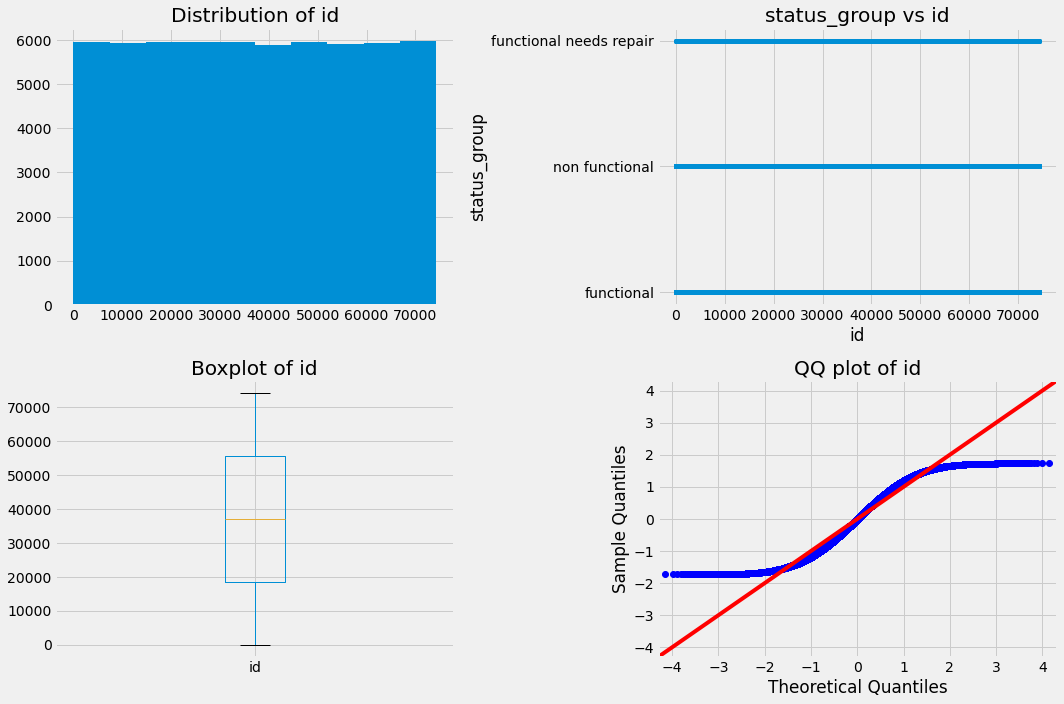

In [477]:
#eval id feature
col_eval(df_clean, num_col='id')

> **OBSERVATIONS**
> - `id` should be changed to categorical as it is a unique identifier for each well

> **ACTIONS**
> - Will recast `id` as categorical

Column Name: amount_tsh


Number of unique values: 98


There are 59302 duplicates


There are 0 null values


There are 41639 zeros


Value Counts Percentage 
 0.0         70.0
500.0        5.0
50.0         4.0
1,000.0      3.0
20.0         2.0
            ... 
8,500.0      0.0
6,300.0      0.0
220.0        0.0
138,000.0    0.0
12.0         0.0
Name: amount_tsh, Length: 98, dtype: float64


Descriptive Metrics: 
 count             59,400.0
mean     317.6503846801347
std     2,997.574558142169
min                    0.0
25%                    0.0
50%                    0.0
75%                   20.0
max              350,000.0
Name: amount_tsh, dtype: float64


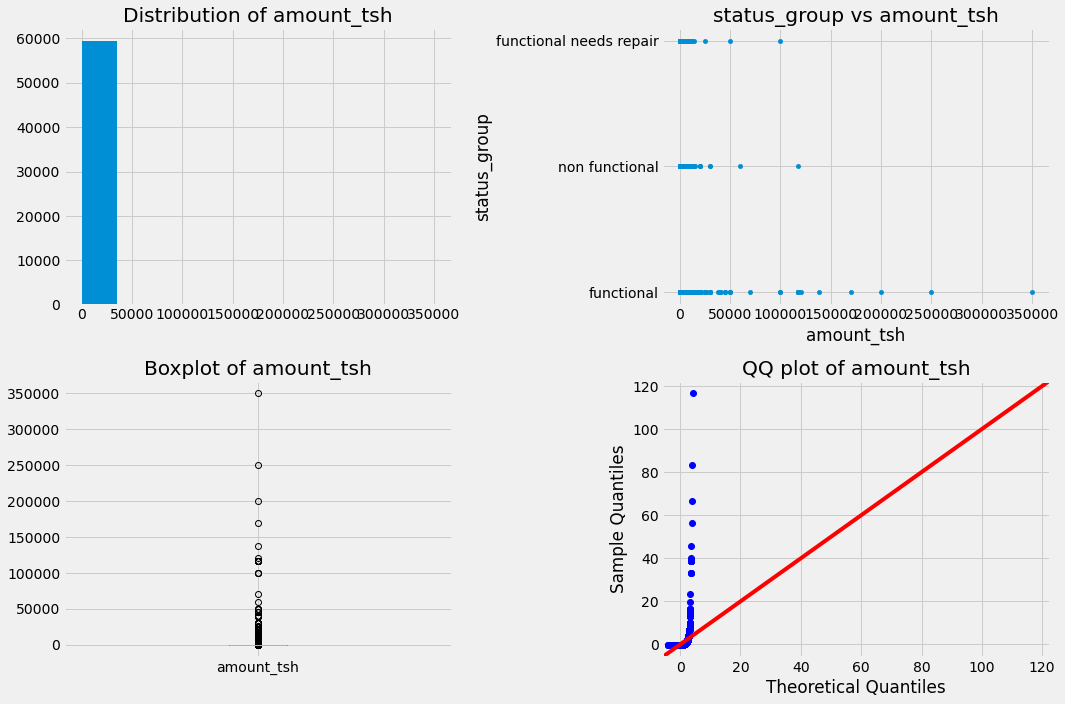

In [478]:
#eval amount_tsh feature
col_eval(df_clean, num_col='amount_tsh')

> **OBSERVATIONS**
> - `amount_tsh` has many 0's and needs to be evaluated for imputation and outliers
> - there are extreme outliers on the high end

> **ACTIONS**
> - I will remove outliers but keep 0's as I believe they do appropriately represent the amount of head on the waterpoint, especially because some of the water comes from rain water capture, lakes and rivers, all of which would have 0 static head.

Column Name: gps_height


Number of unique values: 2428


There are 56972 duplicates


There are 0 null values


There are 20438 zeros


Value Counts Percentage 
  0      34.0
-15      0.0
-16      0.0
-13      0.0
-20      0.0
        ... 
 2285    0.0
 2424    0.0
 2552    0.0
 2413    0.0
 2385    0.0
Name: gps_height, Length: 2428, dtype: float64


Descriptive Metrics: 
 count           59,400.0
mean    668.297239057239
std      693.11635032505
min                -90.0
25%                  0.0
50%                369.0
75%             1,319.25
max              2,770.0
Name: gps_height, dtype: float64


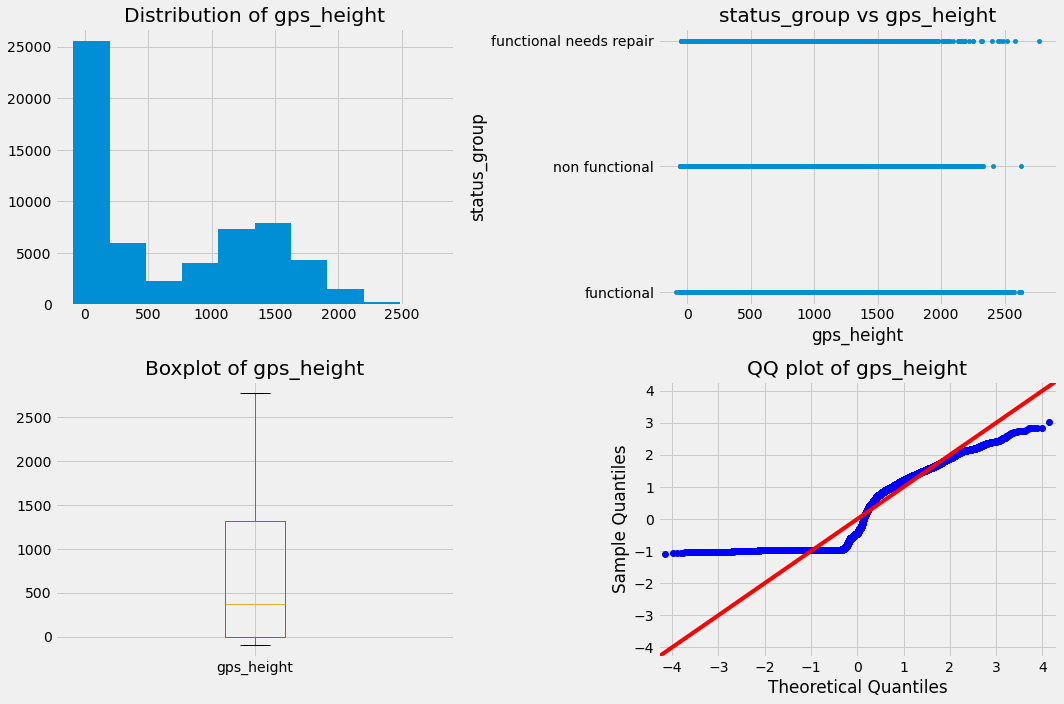

In [479]:
#eval gps_height
col_eval(df_clean, num_col='gps_height')

> **OBSERVATIONS**
> - There are many 0's which could mean the well is at sea level or it is a placeholder for unknown
> - Does not seem to have extreme outliers

> **ACTIONS**
> - I will keep the 0's as I believe they indicate wells which are at sea level and not missing values.

Column Name: longitude


Number of unique values: 57516


There are 1884 duplicates


There are 0 null values


There are 1812 zeros


Value Counts Percentage 
 0.0           3.0
39.08887513   0.0
39.10530661   0.0
37.54340145   0.0
38.18053774   0.0
               ..
38.71052037   0.0
40.11702941   0.0
34.67296206   0.0
39.43360353   0.0
34.89083819   0.0
Name: longitude, Length: 57516, dtype: float64


Descriptive Metrics: 
 count             59,400.0
mean    34.077426692028794
std      6.567431845646531
min                    0.0
25%            33.09034738
50%            34.90874343
75%            37.17838657
max            40.34519307
Name: longitude, dtype: float64


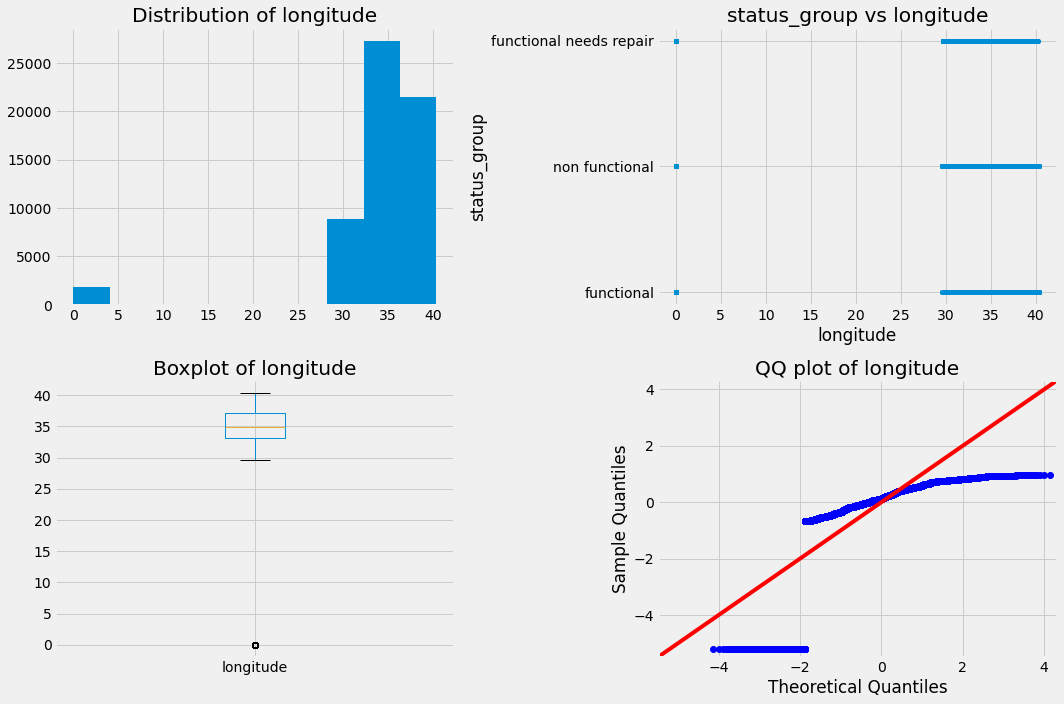

In [480]:
col_eval(df_clean, num_col='longitude')

> **OBSERVATIONS**
> - Every numerical column is 0 when longitude is 0 (1812 rows or 3% of the data). I do not see a valid way to impute these columns.

> - Drop 1812 rows

Column Name: num_private


Number of unique values: 65


There are 59335 duplicates


There are 0 null values


There are 58643 zeros


Value Counts Percentage 
 0     99.0
6      0.0
1      0.0
5      0.0
8      0.0
      ... 
180    0.0
213    0.0
23     0.0
55     0.0
94     0.0
Name: num_private, Length: 65, dtype: float64


Descriptive Metrics: 
 count              59,400.0
mean    0.47414141414141414
std      12.236229810496686
min                     0.0
25%                     0.0
50%                     0.0
75%                     0.0
max                 1,776.0
Name: num_private, dtype: float64


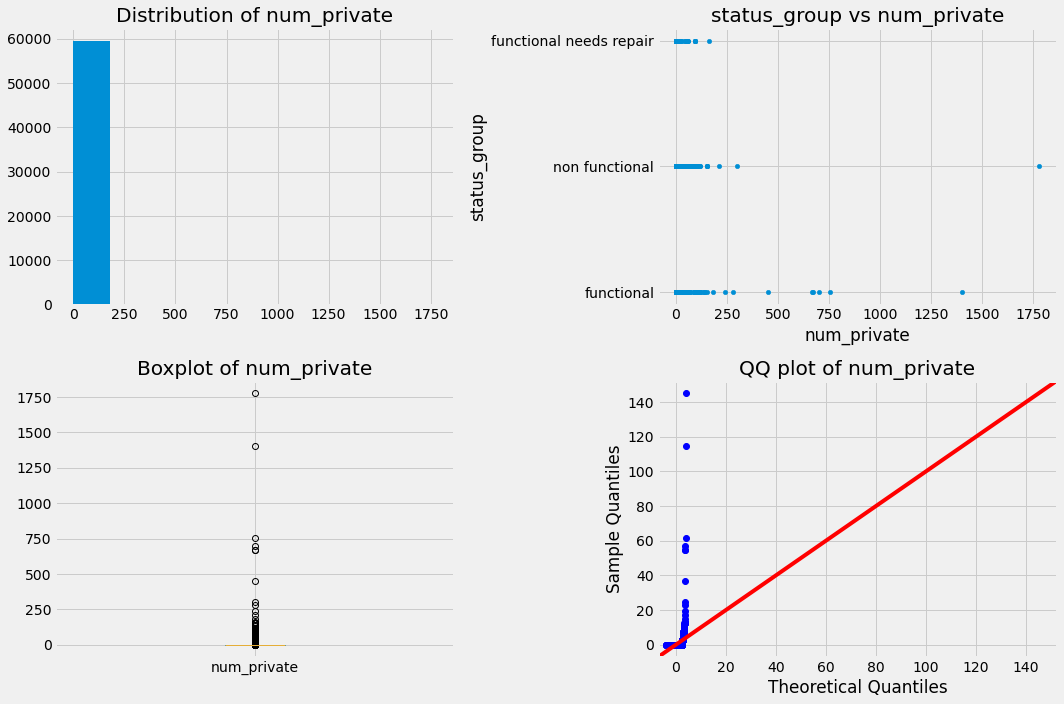

In [481]:
#eval num_private
col_eval(df_clean, num_col='num_private')

> **OBSERVATIONS**
> - Because `num_private` is dominated by a single value (98.7% zero) and the data schema does not clearly state what it means, I will drop this column from the analysis.

> **ACTIONS**
> - Drop `num_private` column

Column Name: region_code


Number of unique values: 27


There are 59373 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 11                 9.0
17                 8.0
12                 8.0
3    7.000000000000001
5    7.000000000000001
18                 6.0
19                 5.0
2                  5.0
16                 5.0
10                 4.0
4                  4.0
1                  4.0
13                 4.0
14                 3.0
20                 3.0
15                 3.0
6                  3.0
21                 3.0
80                 2.0
60                 2.0
90                 2.0
7                  1.0
99                 1.0
9                  1.0
24                 1.0
8                  1.0
40                 0.0
Name: region_code, dtype: float64


Descriptive Metrics: 
 count             59,400.0
mean    15.297003367003366
std      17.58740633733205
min                    1.0
25%                    5.0
50%                   12.0


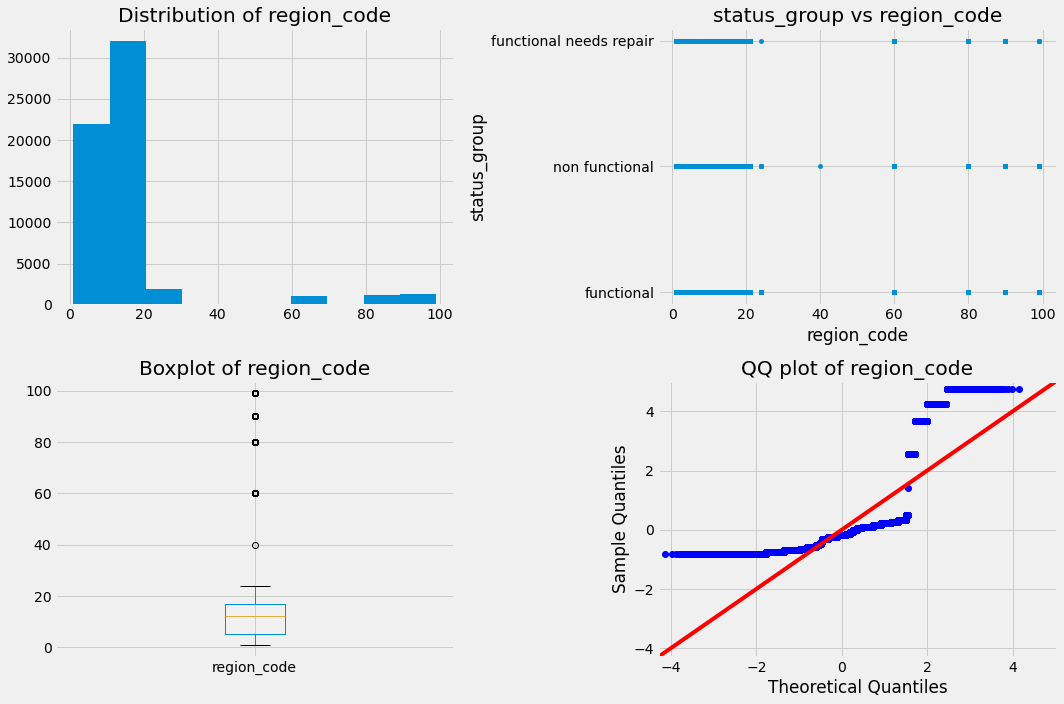

In [482]:
#eval region_code
col_eval(df_clean, num_col='region_code')

> **OBSERVATIONS**
> - `region_code` seems to represent a specific region and does not represent an actual numerical value.

> **ACTIONS**
> - convert `region_code` to a categorical feature

Column Name: district_code


Number of unique values: 20


There are 59380 duplicates


There are 0 null values


There are 23 zeros


Value Counts Percentage 
 1                 21.0
2                 19.0
3                 17.0
4                 15.0
5    7.000000000000001
6    7.000000000000001
7                  6.0
8                  2.0
30                 2.0
33                 1.0
53                 1.0
43                 1.0
13                 1.0
23                 0.0
63                 0.0
62                 0.0
60                 0.0
0                  0.0
80                 0.0
67                 0.0
Name: district_code, dtype: float64


Descriptive Metrics: 
 count            59,400.0
mean    5.629747474747475
std     9.633648629454566
min                   0.0
25%                   2.0
50%                   3.0
75%                   5.0
max                  80.0
Name: district_code, dtype: float64


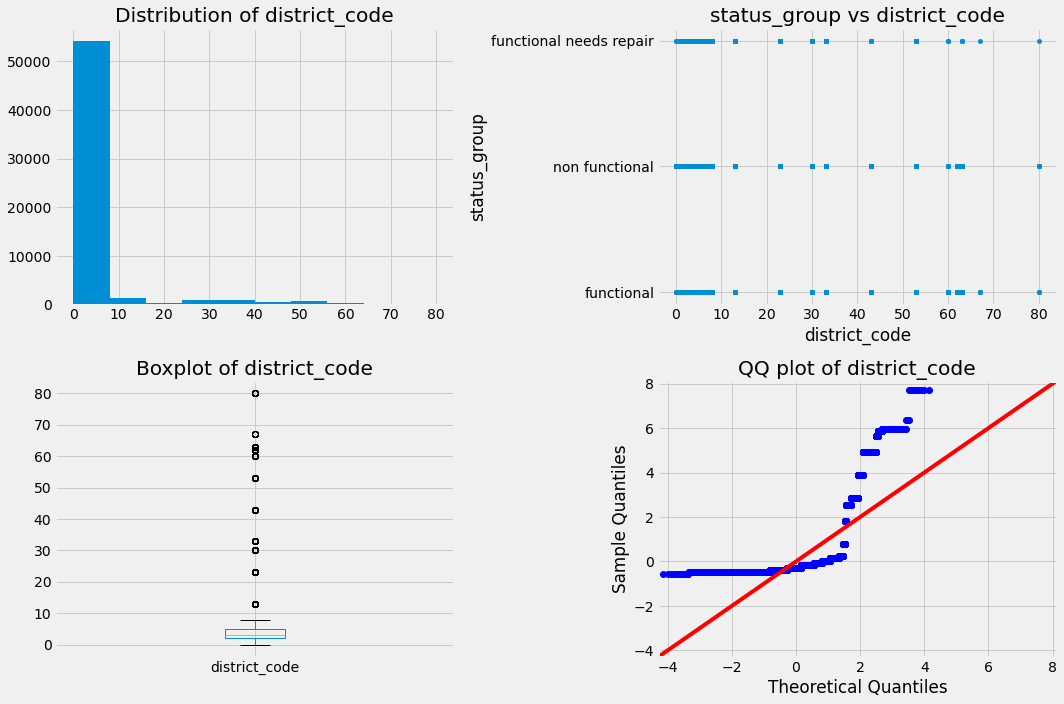

In [483]:
#eval district_code
col_eval(df_clean, num_col='district_code')

> **OBSERVATIONS**
> - `district_code` seems to represent a specific region and does not represent an actual numerical value.

> **ACTIONS**
> - convert `district_code` to a categorical feature

Column Name: population


Number of unique values: 1049


There are 58351 duplicates


There are 0 null values


There are 21381 zeros


Value Counts Percentage 
 0      36.0
1      12.0
200     3.0
150     3.0
250     3.0
       ... 
3241    0.0
1960    0.0
1685    0.0
2248    0.0
1439    0.0
Name: population, Length: 1049, dtype: float64


Descriptive Metrics: 
 count             59,400.0
mean    179.90998316498317
std     471.48217573848035
min                    0.0
25%                    0.0
50%                   25.0
75%                  215.0
max               30,500.0
Name: population, dtype: float64


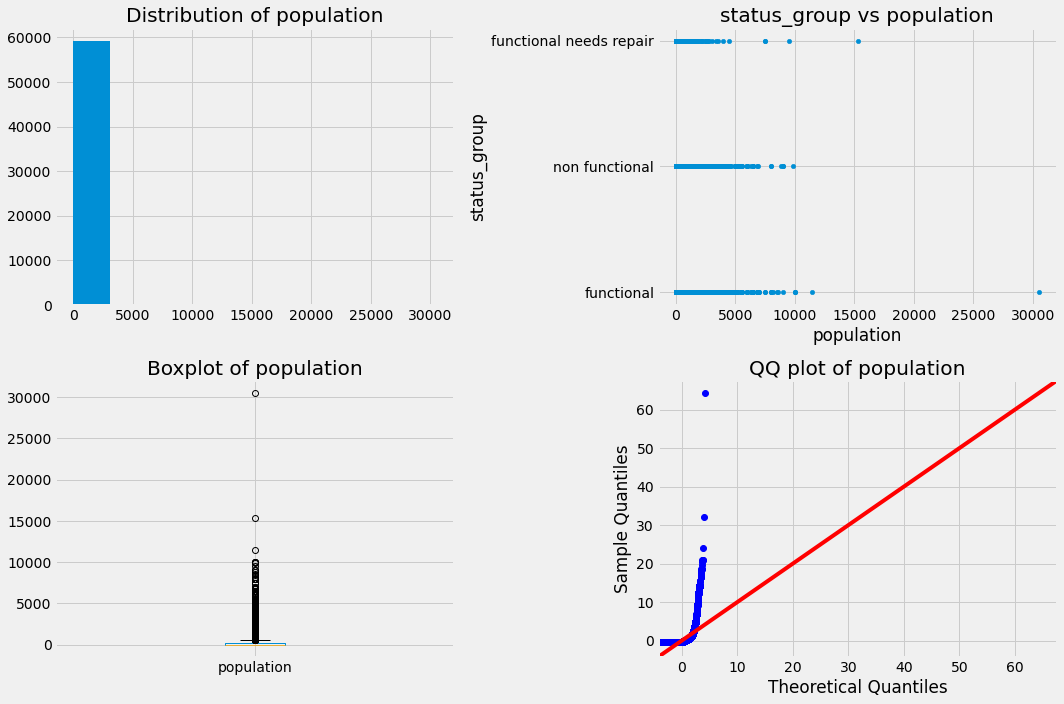

In [484]:
#eval population
col_eval(df_clean, num_col='population')

> **OBSERVATIONS**
> - `population` has many 0's which could either represent wells with no population around them or a placeholder for unknown.

> **ACTIONS**
> - I will leave the 0's as they are logical values 

Column Name: construction_year


Number of unique values: 55


There are 59345 duplicates


There are 0 null values


There are 20709 zeros


Value Counts Percentage 
 0      35.0
2010    4.0
2008    4.0
2009    4.0
2000    4.0
2007    3.0
2006    2.0
2003    2.0
2011    2.0
2004    2.0
2012    2.0
2002    2.0
1978    2.0
1995    2.0
2005    2.0
1999    2.0
1998    2.0
1990    2.0
1985    2.0
1980    1.0
1996    1.0
1984    1.0
1982    1.0
1994    1.0
1972    1.0
1974    1.0
1997    1.0
1992    1.0
1993    1.0
2001    1.0
1988    1.0
1983    1.0
1975    1.0
1986    1.0
1976    1.0
1970    1.0
1991    1.0
1989    1.0
1987    1.0
1981    0.0
1977    0.0
1979    0.0
1973    0.0
2013    0.0
1971    0.0
1960    0.0
1967    0.0
1963    0.0
1968    0.0
1969    0.0
1964    0.0
1962    0.0
1961    0.0
1965    0.0
1966    0.0
Name: construction_year, dtype: float64


Descriptive Metrics: 
 count              59,400.0
mean    1,300.6524747474748
std       951.6205473151729
min                    

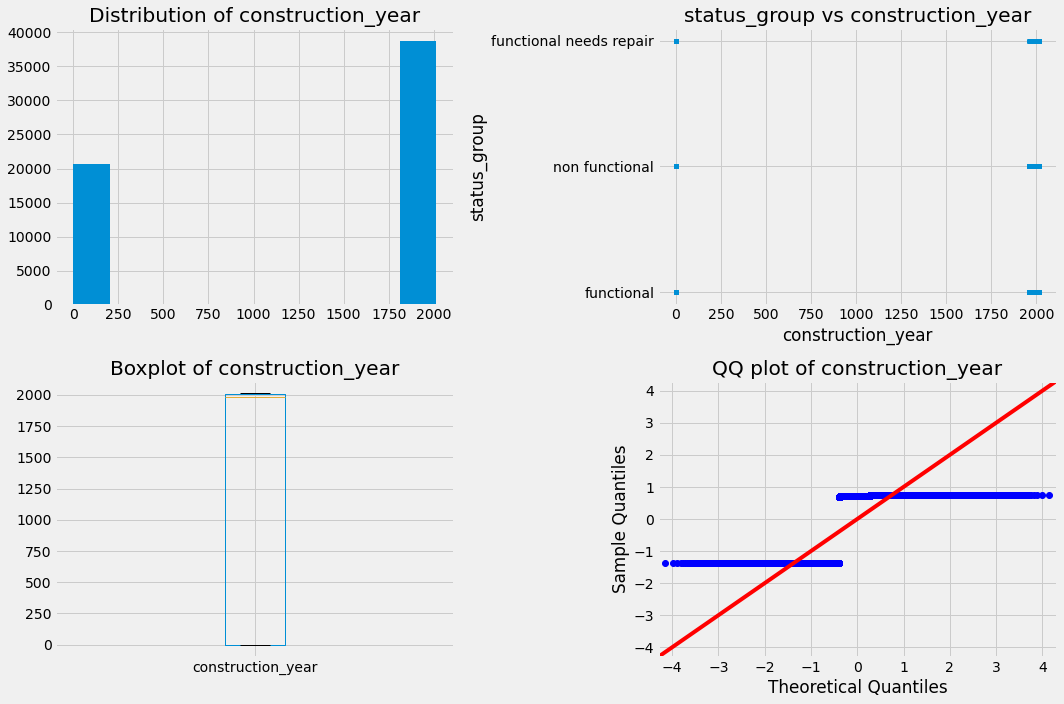

In [485]:
#eval construction_year
col_eval(df_clean, num_col='construction_year')

> **OBSERVATIONS**
> - `construction_year` has many 0's which have to be placeholders for unknown. Imputation could be done by geographic location or based on most common construction years that are known.

> **ACTIONS**
> - Impute `construction_year` to eliminate the 0's

Column Name: funder


Number of unique values: 1897


There are 57502 duplicates


There are 3635 null values


There are 777 zeros


Value Counts Percentage 
 Government Of Tanzania    9084
NaN                       3635
Danida                    3114
Hesawa                    2202
Rwssp                     1374
                          ... 
Norplan                      1
Drv Na Idara                 1
Holili Water Supply          1
Tlc/jenus Malecha            1
Wdsp                         1
Name: funder, Length: 1898, dtype: int64




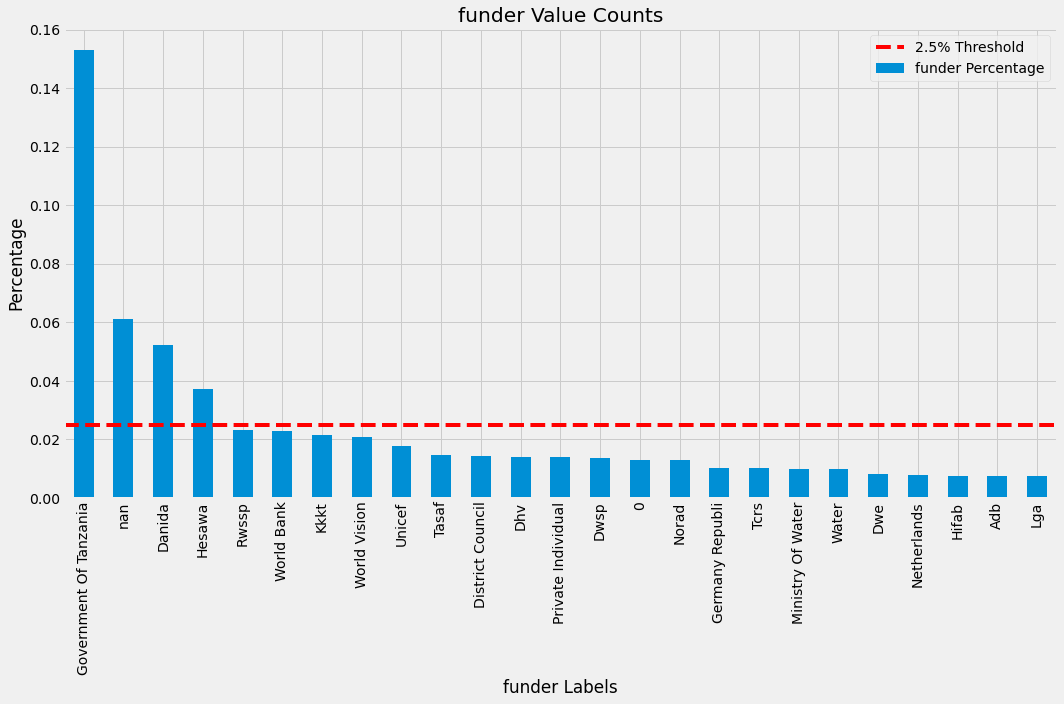

Column Name: installer


Number of unique values: 2145


There are 57254 duplicates


There are 3655 null values


There are 777 zeros


Value Counts Percentage 
 DWE               17402
NaN                3655
Government         1825
RWE                1206
Commu              1060
                  ...  
Central basin         1
Teonas Wambura        1
Mgaya Masese          1
HOLAND                1
KOYI                  1
Name: installer, Length: 2146, dtype: int64




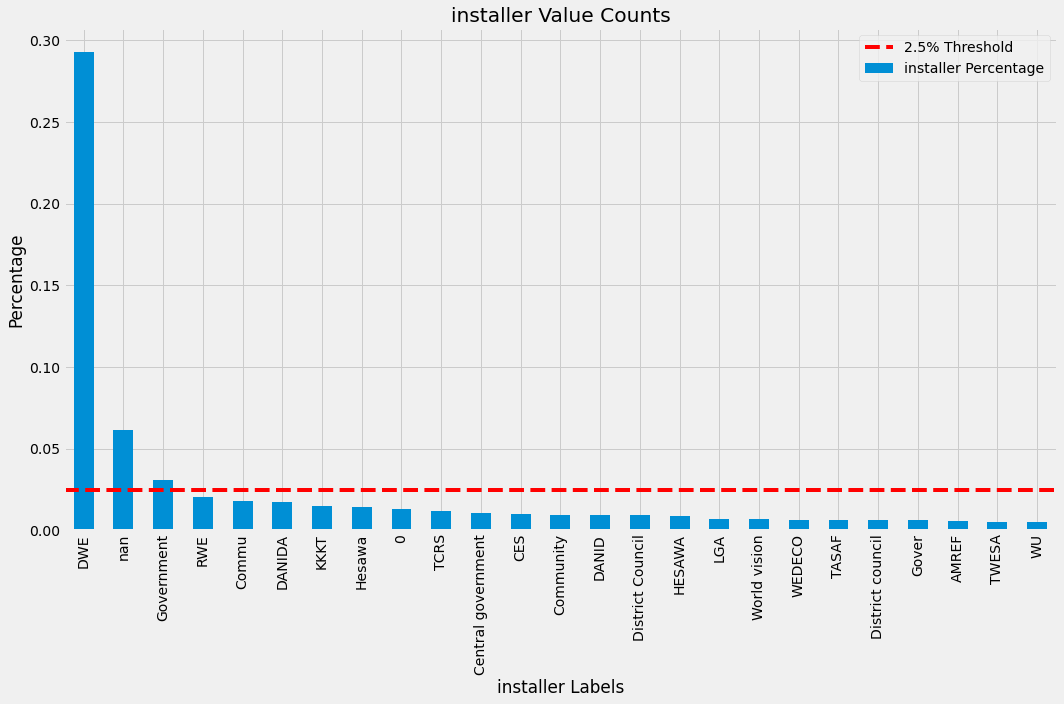

In [486]:
#eval funder
col_eval(df_clean, cat_col=['funder','installer'])

> **OBSERVATIONS**
> - These 2 columns are not similar but it does have a high cardinality (1897 unique labels) and rare labels.
> - `funder` has 3,635 missing values, which is 6% of the rows while `installer` has 3,655 missing values, which is 6% of the rows. 
> - There is also 777 "0" labels for both which could indicate a missing value.

> **ACTIONS**
> - I will combine both of the 0's with the "Unknown" label
> - I will combine labels in order to eliminate the high cardinality and rare labels.

Column Name: wpt_name


Number of unique values: 37400


There are 22000 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 none                            3563
Shuleni                         1748
Zahanati                         830
Msikitini                        535
Kanisani                         323
                                ... 
Shuleni Sekondari/Chifanzaki       1
Kwa Kasana                         1
Kwa Elifasi                        1
Mwakikuti                          1
Kwatito                            1
Name: wpt_name, Length: 37400, dtype: int64




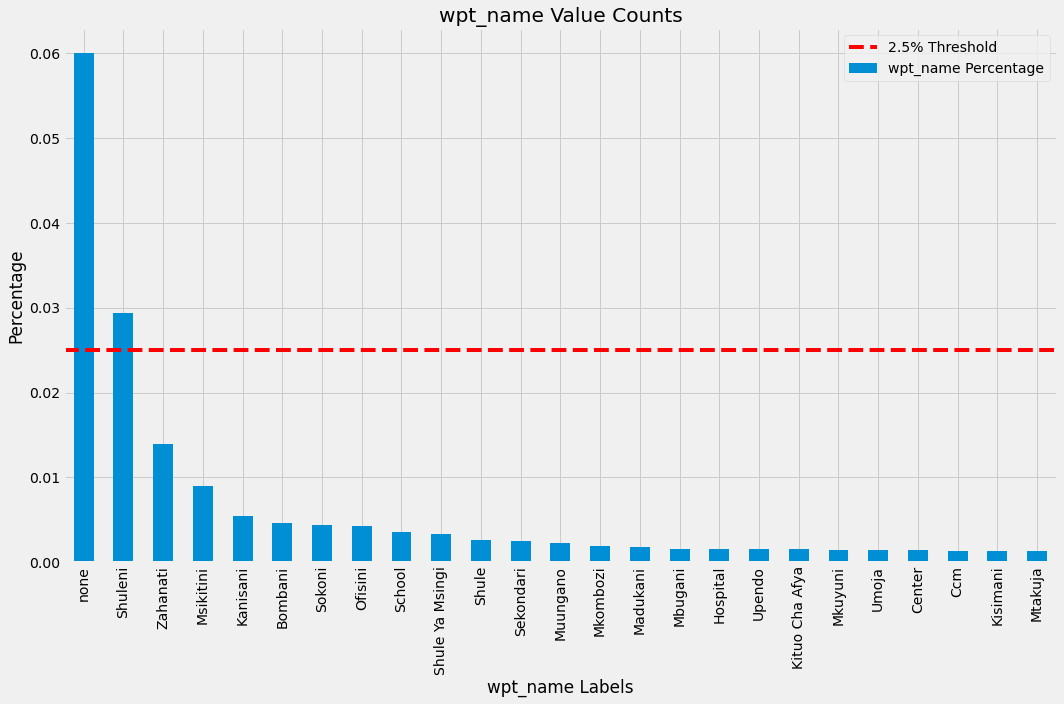

In [487]:
#eval wpt_name
col_eval(df_clean, cat_col=['wpt_name'])

> **OBSERVATIONS**
> - No issues with `wpt_name`.

Column Name: basin


Number of unique values: 9


There are 59391 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64




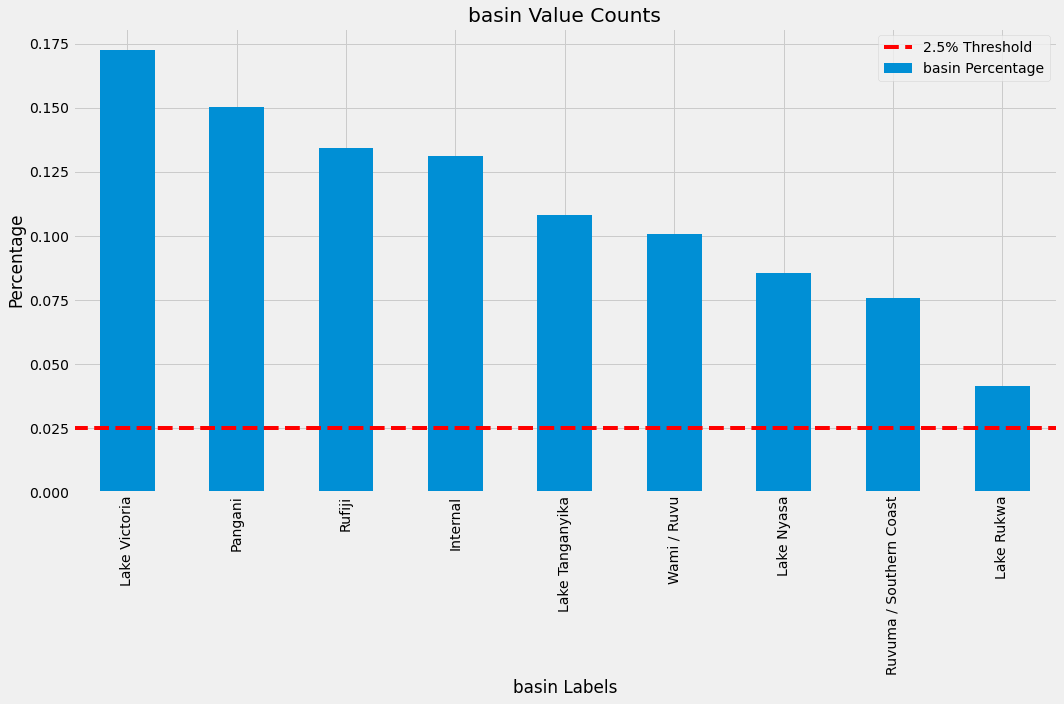

Column Name: subvillage


Number of unique values: 19287


There are 40112 duplicates


There are 371 null values


There are 0 zeros


Value Counts Percentage 
 Madukani             508
Shuleni              506
Majengo              502
Kati                 373
NaN                  371
                    ... 
Damwelu Magharibi      1
Ntanga Center          1
Nangunguru             1
Otogwangh'Olo          1
Mori                   1
Name: subvillage, Length: 19288, dtype: int64




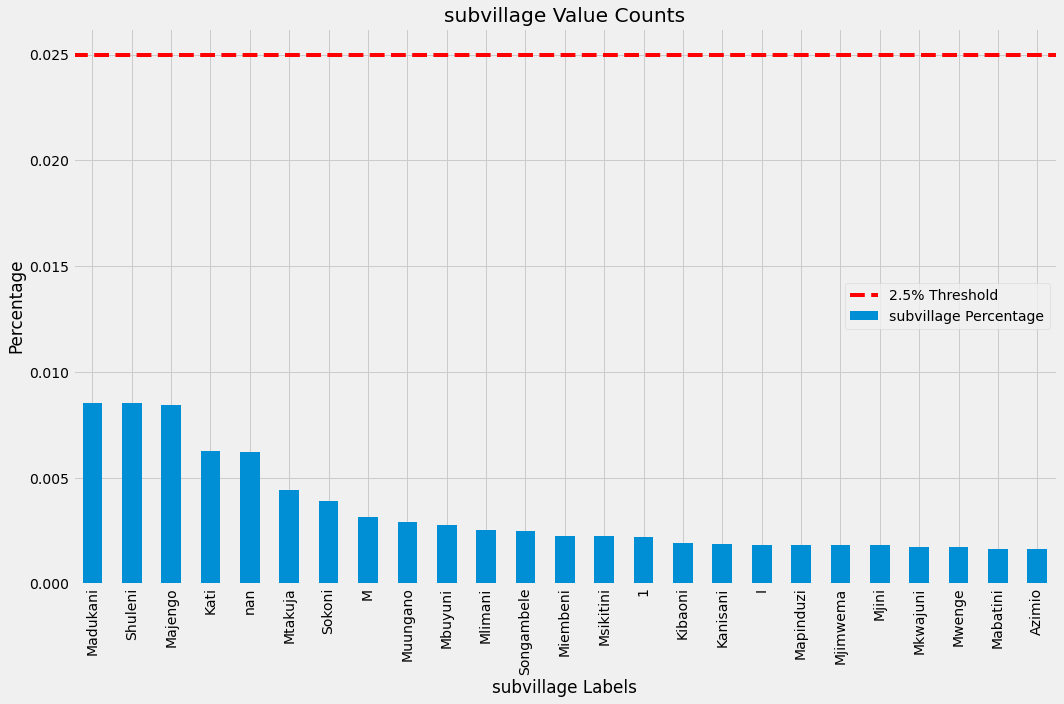

Column Name: region


Number of unique values: 21


There are 59379 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64




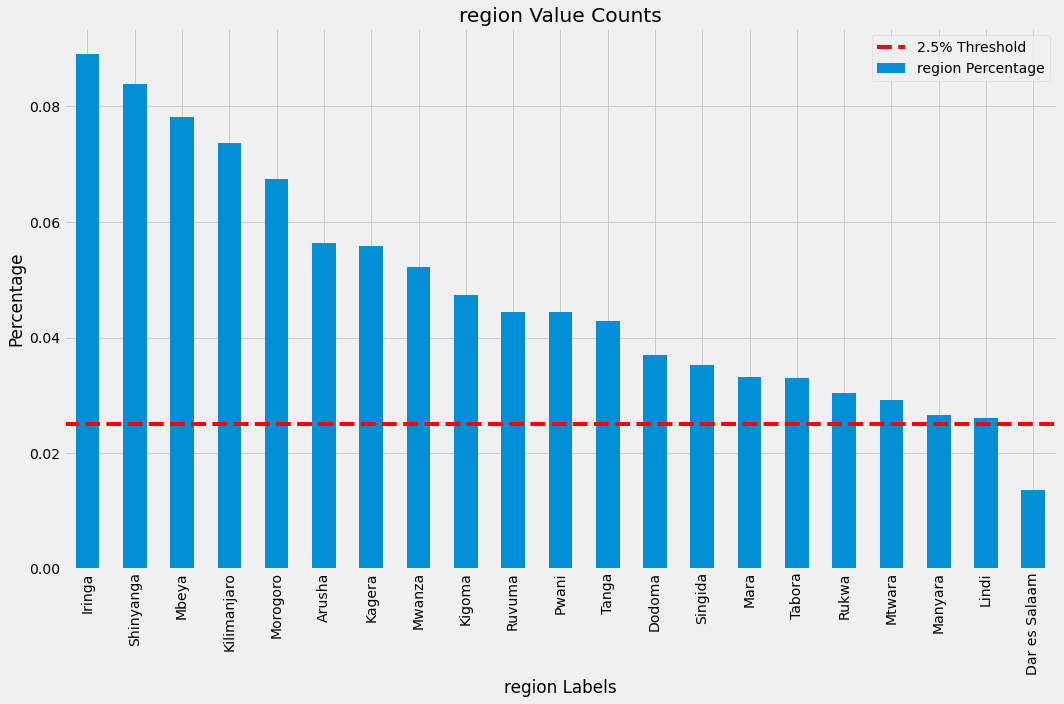

Column Name: region_code


Number of unique values: 27


There are 59373 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64




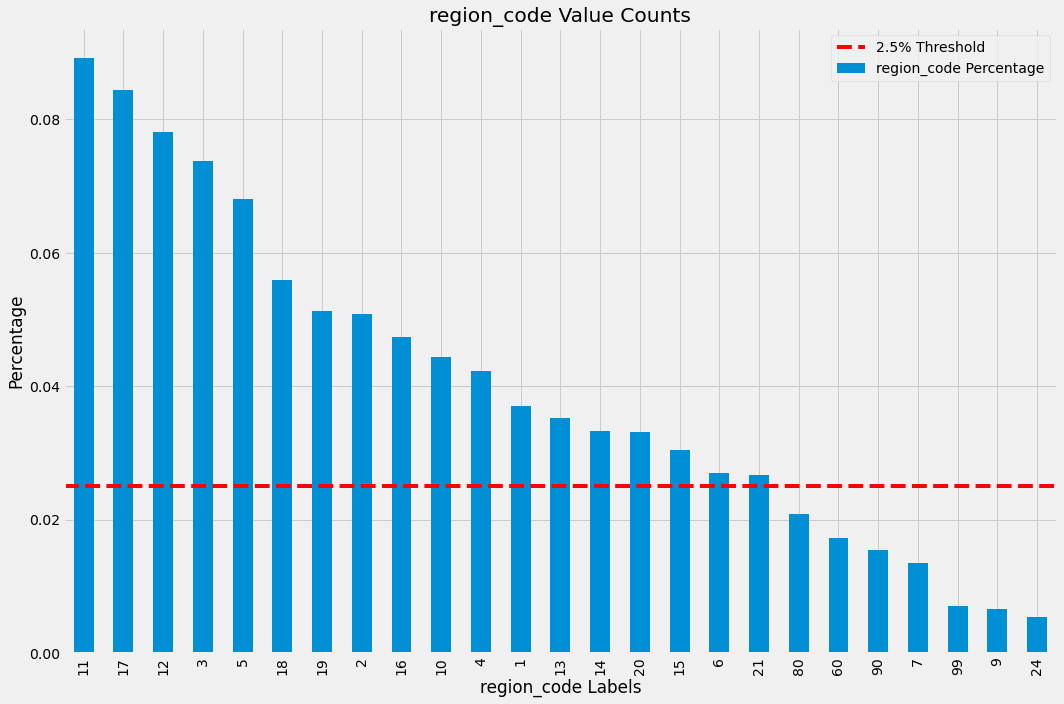

Column Name: district_code


Number of unique values: 20


There are 59380 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64




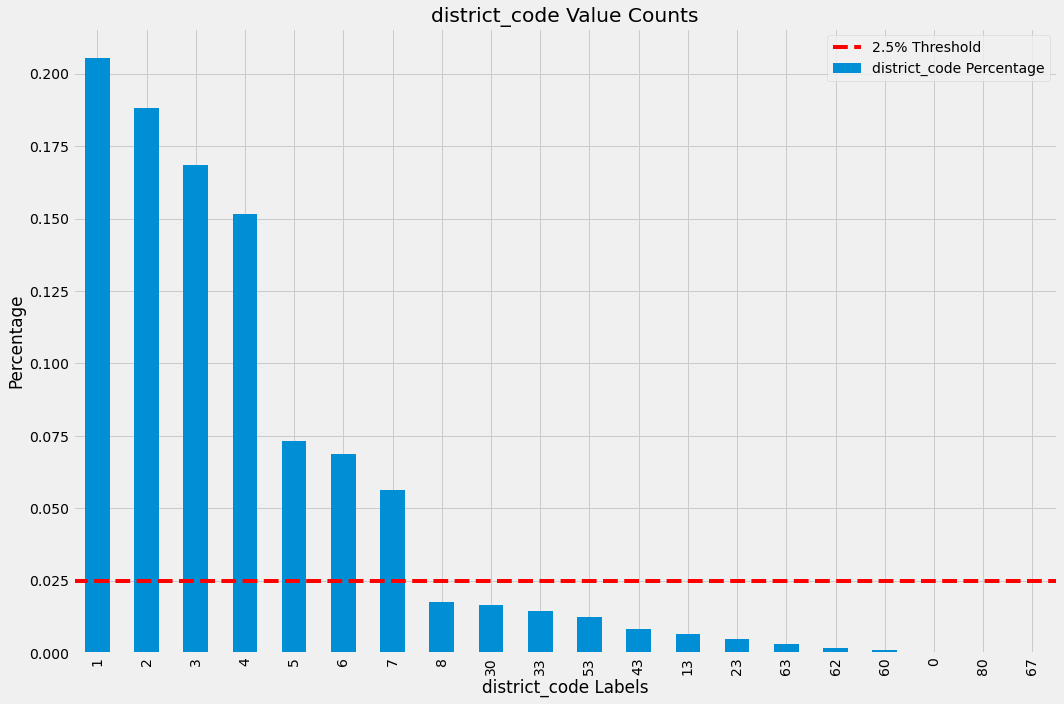

Column Name: lga


Number of unique values: 125


There are 59275 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64




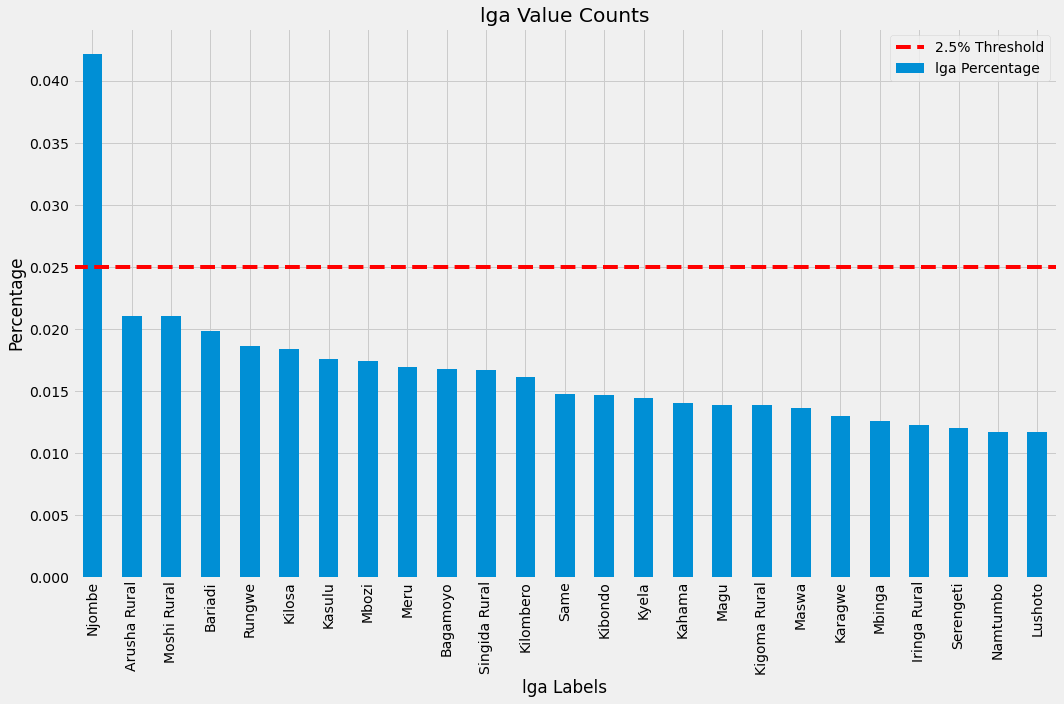

Column Name: ward


Number of unique values: 2092


There are 57308 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 Igosi              307
Imalinyi           252
Siha Kati          232
Mdandu             231
Nduruma            217
                  ... 
Simbay               1
Kihangimahuka        1
Chinugulu            1
Rasbura              1
Uwanja wa Ndege      1
Name: ward, Length: 2092, dtype: int64




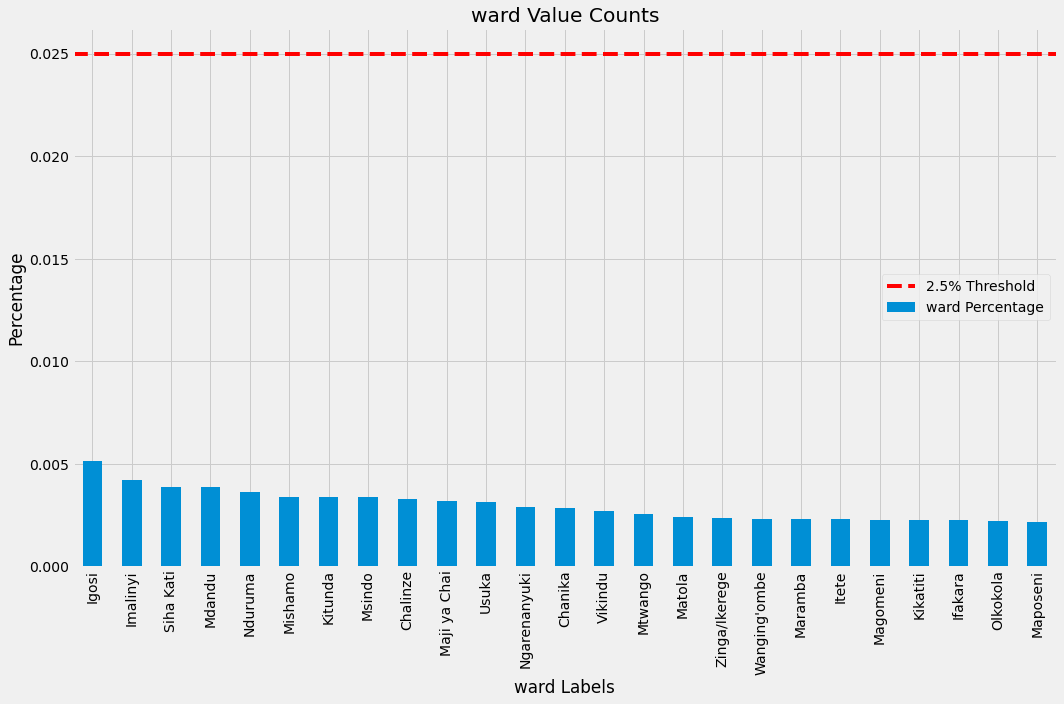

In [488]:
#eval geographic features
col_eval(df_clean, cat_col=['basin','subvillage','region','region_code','district_code','lga','ward'])

> **OBSERVATIONS**
> - `basin` seems normal
> - `subvillage` has 371 null values and high cardinality (19,286 unique values)
> - `region` seems normal
> - `region_code` is redundant 
> - `district_code` seems normal
> - `lga` seems normal
> - `ward` has high cardinality (2,092 unique values)

> **ACTIONS**
> - drop `subvillage` since it has too many unique values
> - drop `region_code`

Column Name: public_meeting


Number of unique values: 2


There are 59397 duplicates


There are 3334 null values


There are 0 zeros


Value Counts Percentage 
 True     51011
False     5055
NaN       3334
Name: public_meeting, dtype: int64




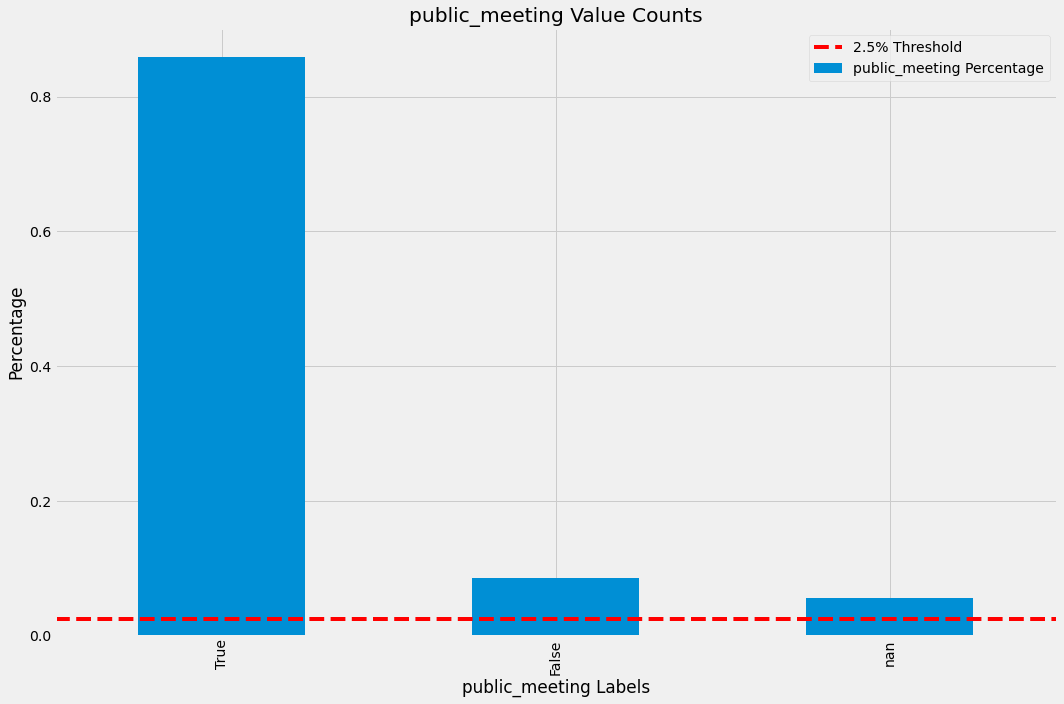

In [489]:
#eval public_meeting
col_eval(df_clean, cat_col=['public_meeting'])

> **OBSERVATIONS**
> - `public_meeting` looks to be a boolean feature
> - there are 3,333 missing values

> **ACTIONS**
> - convert to string
> - impute missing values as "unknown"

Column Name: recorded_by


Number of unique values: 1


There are 59399 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64




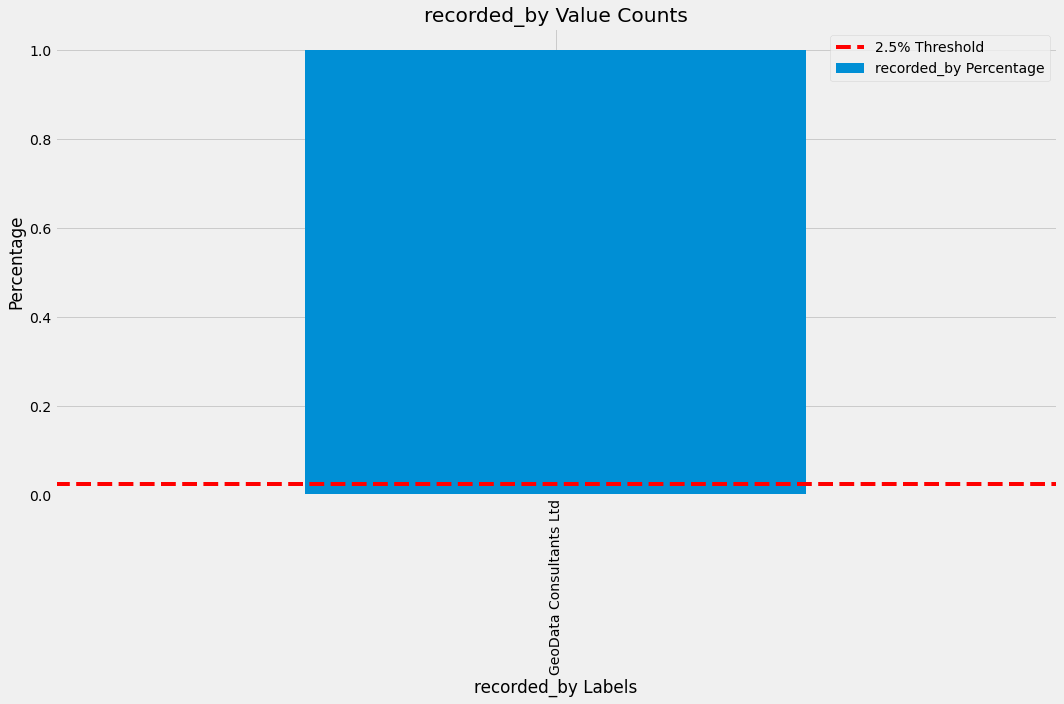

In [490]:
#eval recorded_by
col_eval(df_clean, cat_col=['recorded_by'])

> **OBSERVATIONS**
> - `recorded_by` has a single value and will not be beneficial for EDA or modeling

> **ACTIONS**
> - drop the feature

Column Name: scheme_management


Number of unique values: 12


There are 59387 duplicates


There are 3877 null values


There are 0 zeros


Value Counts Percentage 
 VWC                 36793
WUG                  5206
NaN                  3877
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64




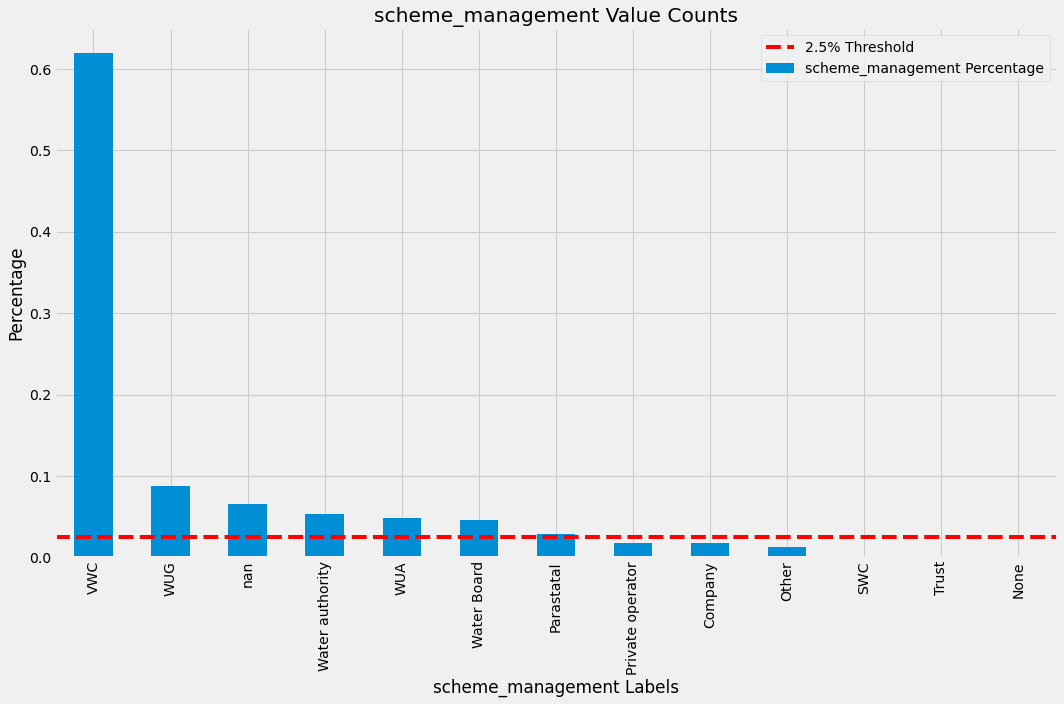

Column Name: scheme_name


Number of unique values: 2696


There are 56703 duplicates


There are 28166 null values


There are 0 zeros


Value Counts Percentage 
 NaN                     28166
K                         682
None                      644
Borehole                  546
Chalinze wate             405
                        ...  
Dindimu Water Supply        1
Fingan                      1
PADEP(MIFUGO)               1
fini water                  1
Fufu                        1
Name: scheme_name, Length: 2697, dtype: int64




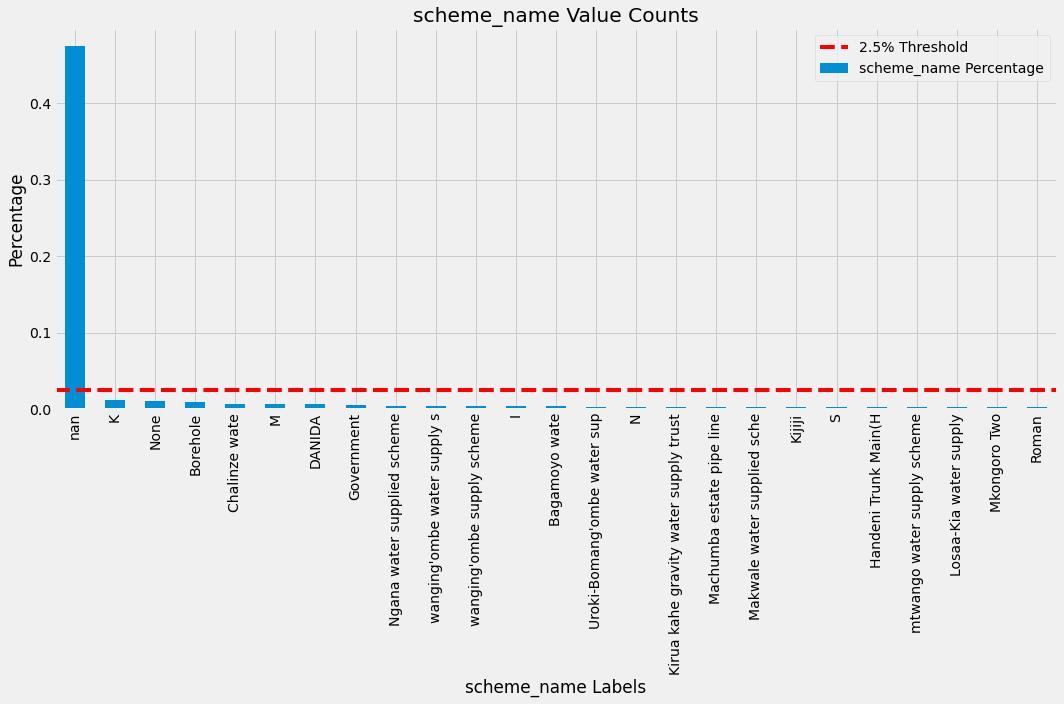

In [491]:
#eval scheme_name, scheme_management
col_eval(df_clean, cat_col=['scheme_management','scheme_name'])

> **OBSERVATIONS**
> - `scheme_management` has 3,877 missing values
> - `scheme_name` has 28,160 missing values

> **ACTIONS**
> - drop `scheme_name`
> - consolidate missing values in `scheme_management` with "unknown"

Column Name: permit


Number of unique values: 2


There are 59397 duplicates


There are 3056 null values


There are 0 zeros


Value Counts Percentage 
 True     38852
False    17492
NaN       3056
Name: permit, dtype: int64




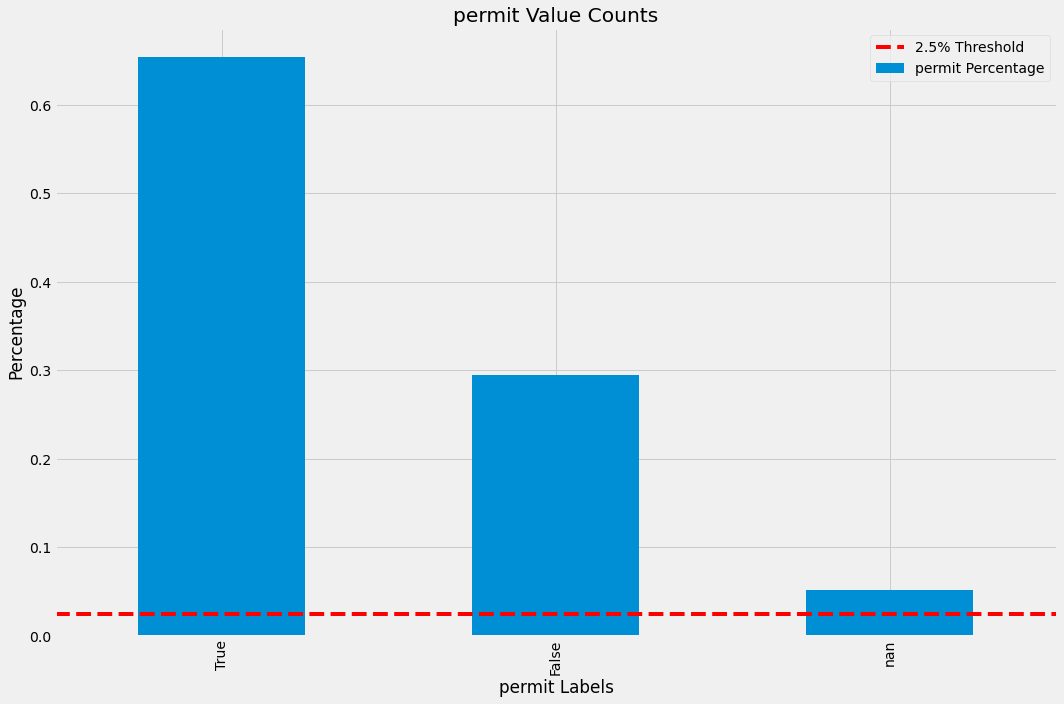

In [492]:
#eval permit
col_eval(df_clean, cat_col=['permit'])

> **OBSERVATIONS**
> - `permit` looks like a boolean feature
> - There are 3056 original missing values which were converted to string 'nan', which is 5% of the rows.

> **ACTIONS**
> - I will rename these "unknown"
> - I will also recast as a string

Column Name: extraction_type_class


Number of unique values: 7


There are 59393 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64




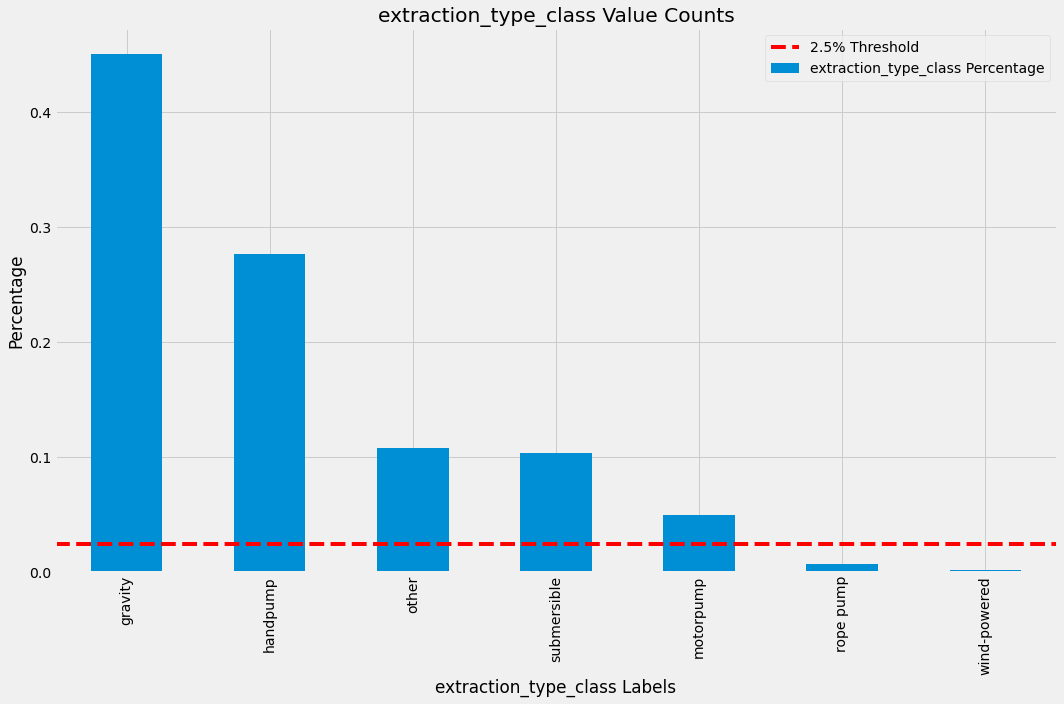

Column Name: extraction_type_group


Number of unique values: 13


There are 59387 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64




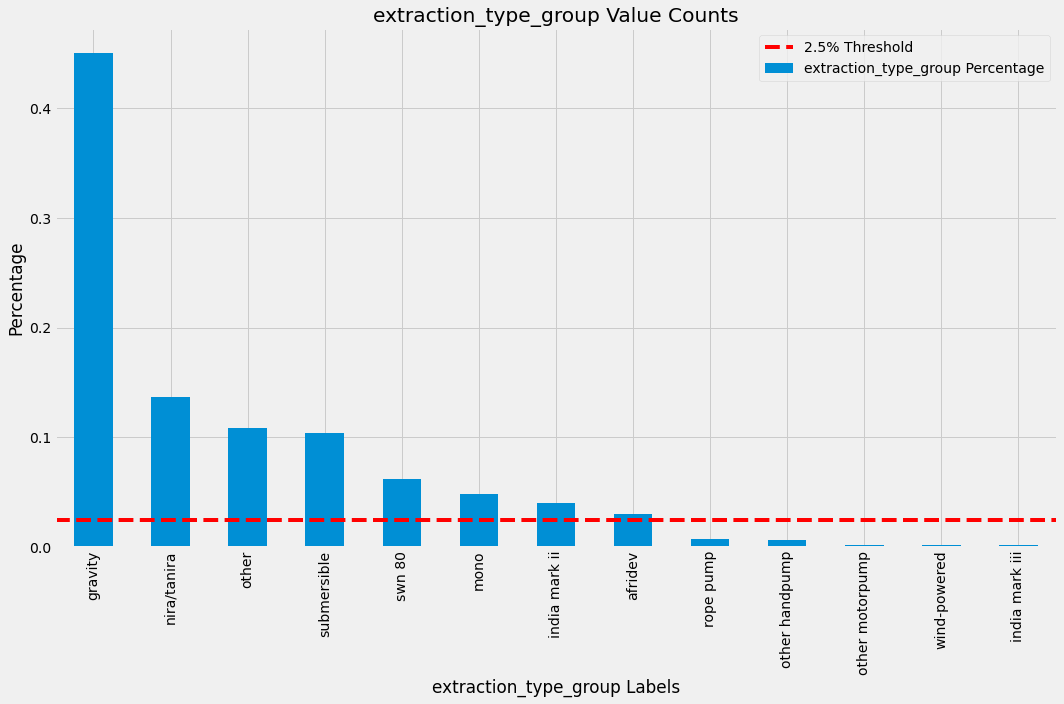

Column Name: extraction_type


Number of unique values: 18


There are 59382 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64




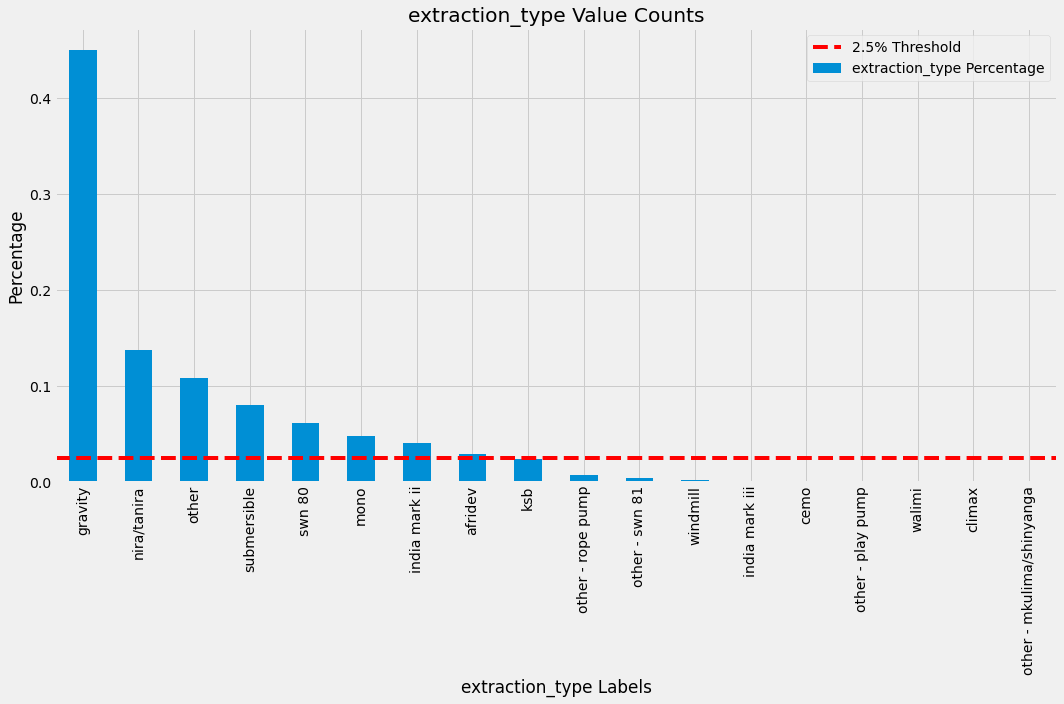

In [493]:
#eval extraction_type, extraction_type_group, extraction_type_class
col_eval(df_clean, cat_col=['extraction_type_class','extraction_type_group','extraction_type'])

In [494]:
#eval extraction_type_class, extraction_type_group and extraction_type
df_clean.groupby(by=['extraction_type_class','extraction_type_group','extraction_type']).count()

id  \
extraction_type_class extraction_type_group extraction_type                    
gravity               gravity               gravity                    26780   
handpump              afridev               afridev                     1770   
                      india mark ii         india mark ii               2400   
                      india mark iii        india mark iii                98   
                      nira/tanira           nira/tanira                 8154   
                      other handpump        other - mkulima/shinyanga      2   
                                            other - play pump             85   
                                            other - swn 81               229   
                                            walimi                        48   
                      swn 80                swn 80                      3670   
motorpump             mono                  mono                        2865   
                      other motorpump       cemo                          90   
                                            climax                        32   
other                 other                 other                       6430   
rope pump             rope pump             other - rope pump            451   
submersible           submersible           ksb                         1415   
                                            submersible                 4764   
wind-powered          wind-powered          windmill                     117   

                                                                       amount_tsh  \
extraction_type_class extraction_type_group extraction_type                         
gravity               gravity               gravity                         26780   
handpump              afridev               afridev                          1770   
                      india mark ii         india mark ii                    2400   
                      india mark iii        india mark iii                     98   
                      nira/tanira           nira/tanira                      8154   
                      other handpump        other - mkulima/shinyanga           2   
                                            other - play pump                  85   
                                            other - swn 81                    229   
                                            walimi                             48   
                      swn 80                swn 80                           3670   
motorpump             mono                  mono                             2865   
                      other motorpump       cemo                               90   
                                            climax                             32   
other                 other                 other                            6430   
rope pump             rope pump             other - rope pump                 451   
submersible           submersible           ksb                              1415   
                                            submersible                      4764   
wind-powered          wind-powered          windmill                          117   

                                                                       date_recorded  \
extraction_type_class extraction_type_group extraction_type                            
gravity               gravity               gravity                            26780   
handpump              afridev               afridev                             1770   
                      india mark ii         india mark ii                       2400   
                      india mark iii        india mark iii                        98   
                      nira/tanira           nira/tanira                         8154   
                      other handpump        other - mkulima/shinyanga              2   
                                            other - play pump       

> **OBSERVATIONS**
> - These columns are similar as they represent a hierarchical structure.

> **ACTIONS**
> - I will consolidate by removing the `extraction_type_group` feature as the labels are captured in more detail in the `extraction_type` feature. I will rename the columns and will also clean up the naming of the labels.

Column Name: management


Number of unique values: 12


There are 59388 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64




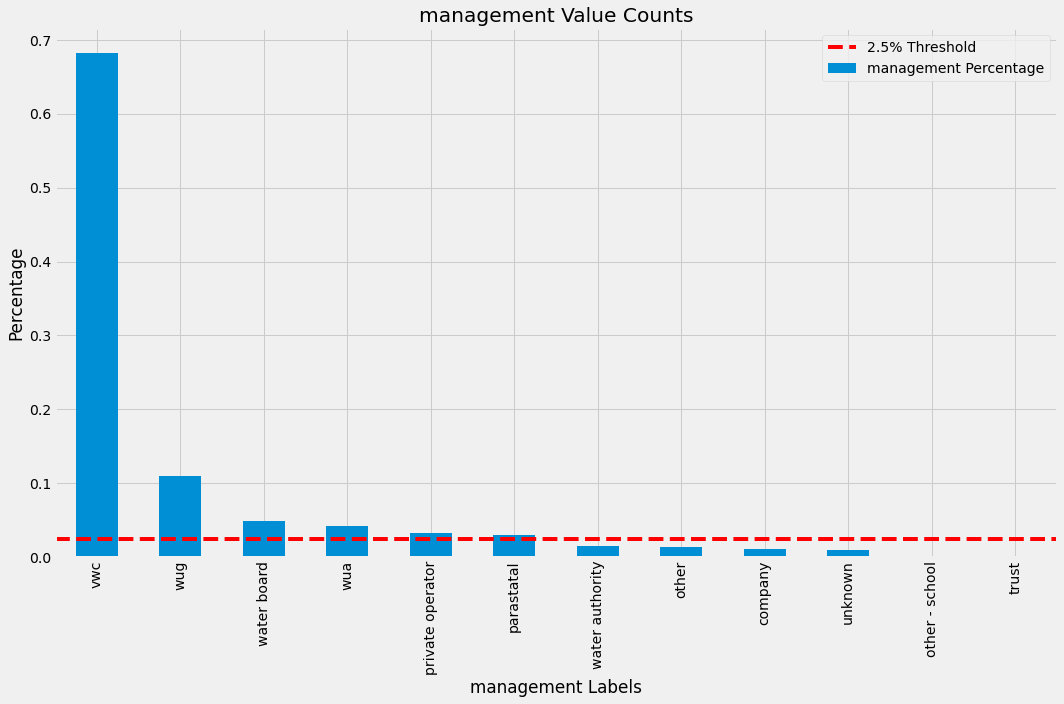

Column Name: management_group


Number of unique values: 5


There are 59395 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64




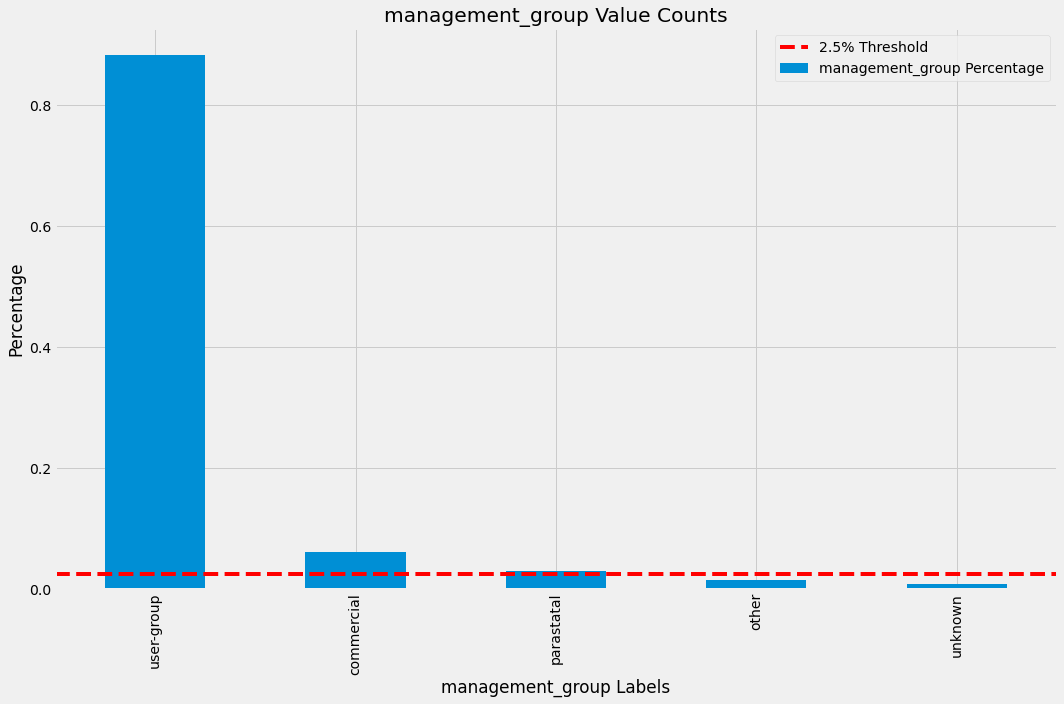

In [495]:
#evaluate management and management_group for dropping
col_eval(df_clean, cat_col=['management','management_group'])

In [496]:
#evaluate management and management_group for dropping
df_clean.groupby(by=['management','management_group']).count().index

MultiIndex([(         'company', 'commercial'),
            (           'other',      'other'),
            (  'other - school',      'other'),
            (      'parastatal', 'parastatal'),
            ('private operator', 'commercial'),
            (           'trust', 'commercial'),
            (         'unknown',    'unknown'),
            (             'vwc', 'user-group'),
            ( 'water authority', 'commercial'),
            (     'water board', 'user-group'),
            (             'wua', 'user-group'),
            (             'wug', 'user-group')],
           names=['management', 'management_group'])

> **OBSERVATIONS**
> - `management_group` is redundant

> **ACTIONS**
> - drop `management_group`

Column Name: payment


Number of unique values: 7


There are 59393 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64




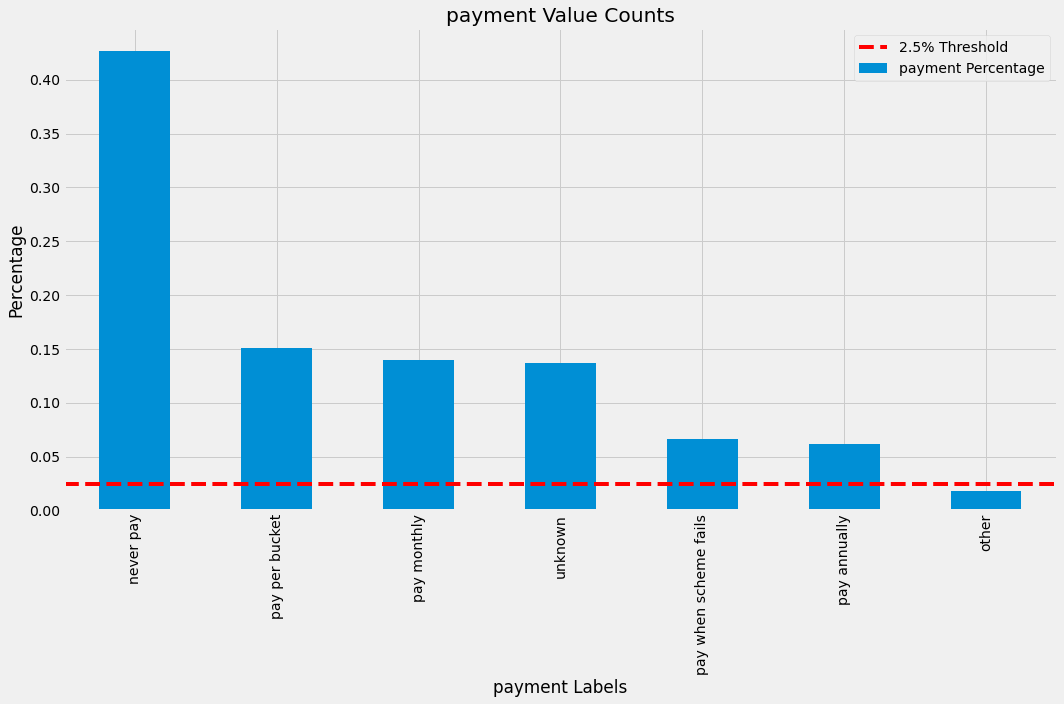

Column Name: payment_type


Number of unique values: 7


There are 59393 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64




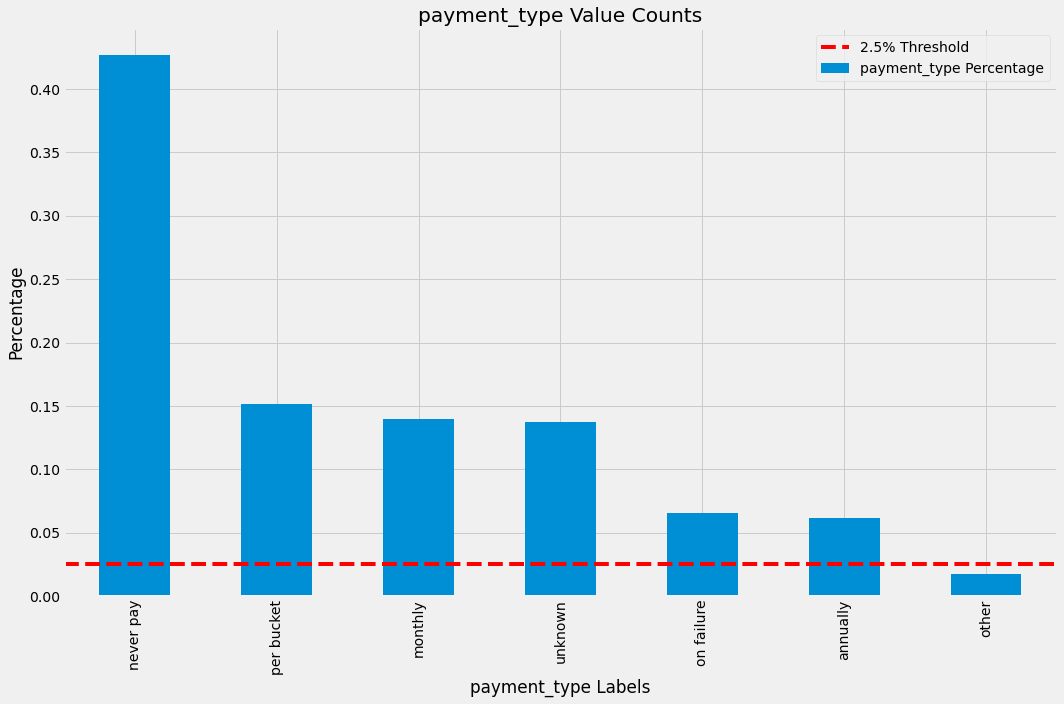

In [497]:
#evaluate payment, payment_type
col_eval(df_clean, cat_col=['payment','payment_type'])

In [498]:
#evaluate payment and payment_type
df_clean.groupby(by=['payment','payment_type']).count().index

MultiIndex([(            'never pay',  'never pay'),
            (                'other',      'other'),
            (         'pay annually',   'annually'),
            (          'pay monthly',    'monthly'),
            (       'pay per bucket', 'per bucket'),
            ('pay when scheme fails', 'on failure'),
            (              'unknown',    'unknown')],
           names=['payment', 'payment_type'])

> **OBSERVATIONS**
> - `payment_type` is redundant

> **ACTIONS**
> - drop `payment_type`

Column Name: water_quality


Number of unique values: 8


There are 59392 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64




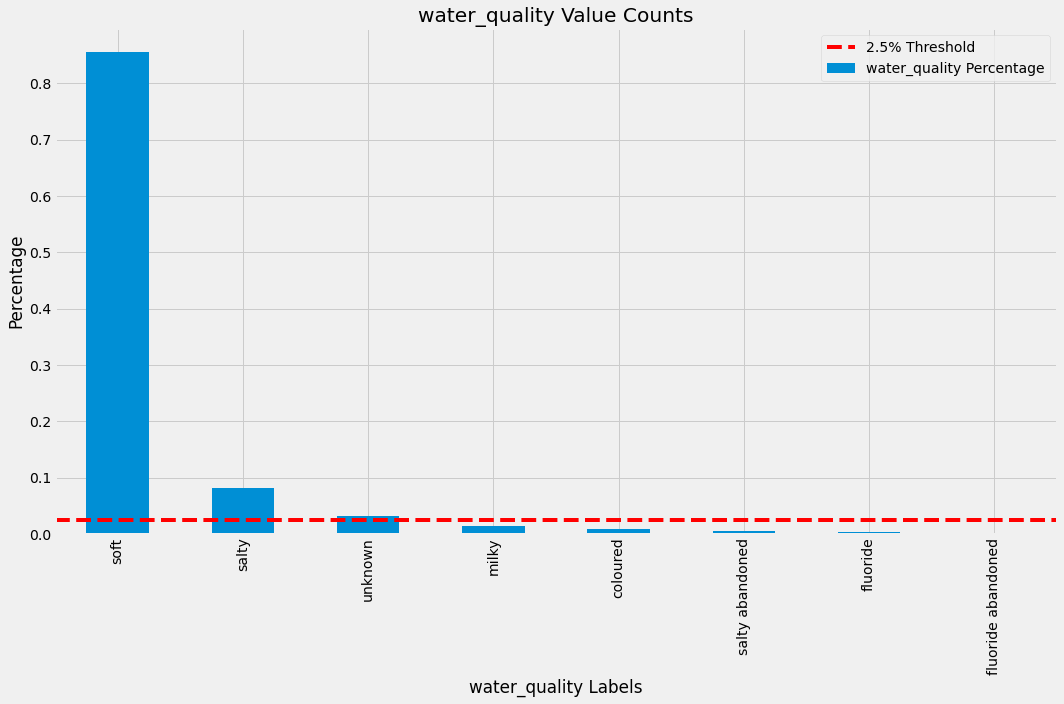

Column Name: quality_group


Number of unique values: 6


There are 59394 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64




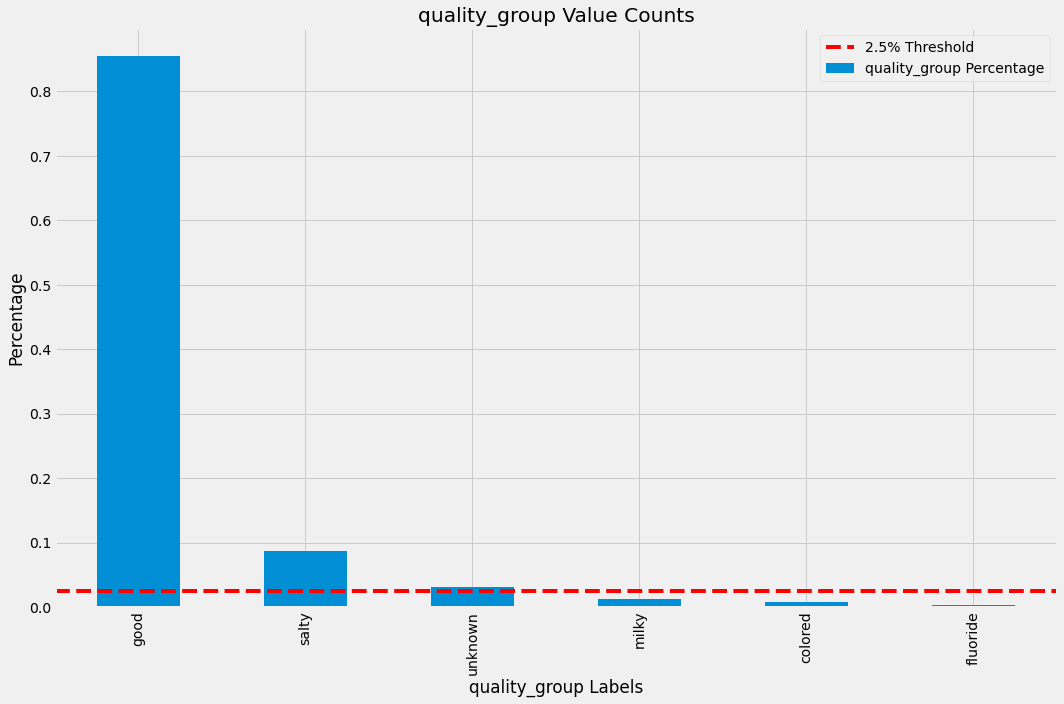

In [499]:
#eval water_quality and quality_group for dropping
col_eval(df_clean,cat_col=['water_quality','quality_group'])

In [500]:
#eval water_quality and quality_group
df_clean.groupby(by=['water_quality','quality_group']).count().index

MultiIndex([(          'coloured',  'colored'),
            (          'fluoride', 'fluoride'),
            ('fluoride abandoned', 'fluoride'),
            (             'milky',    'milky'),
            (             'salty',    'salty'),
            (   'salty abandoned',    'salty'),
            (              'soft',     'good'),
            (           'unknown',  'unknown')],
           names=['water_quality', 'quality_group'])

> **OBSERVATIONS**
> - `quality_group` is redundant, need to update "soft" label to "soft-good".

> **ACTIONS**
> - drop `quality_group`, update "soft" label to "soft-good" on `water_quality` feature

Column Name: quantity


Number of unique values: 5


There are 59395 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64




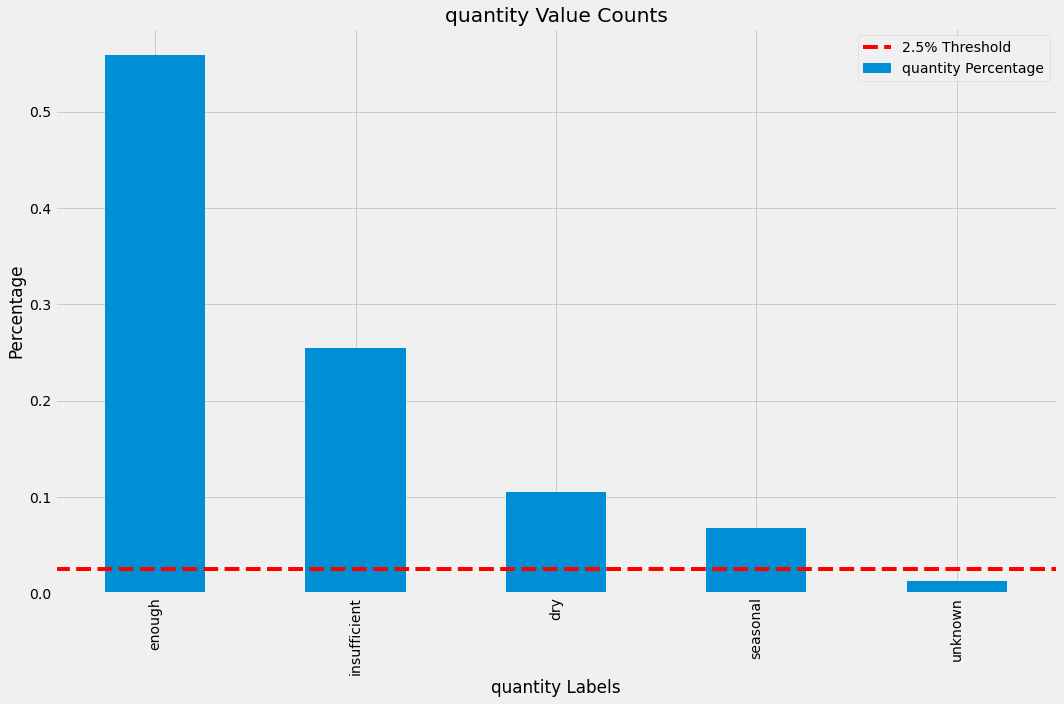

Column Name: quantity_group


Number of unique values: 5


There are 59395 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64




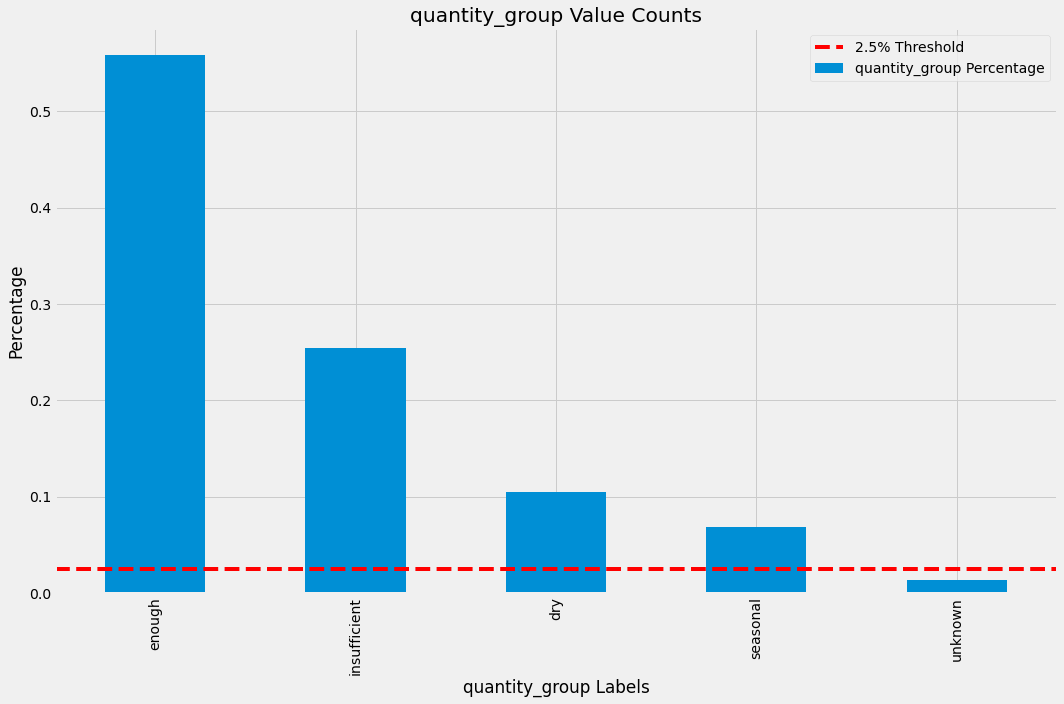

In [501]:
#evaluate quantity and quantity group
col_eval(df_clean, cat_col=['quantity','quantity_group'])

In [502]:
#eval quantity and quantity_group
df_clean.groupby(by=['quantity','quantity_group']).count().index

MultiIndex([(         'dry',          'dry'),
            (      'enough',       'enough'),
            ('insufficient', 'insufficient'),
            (    'seasonal',     'seasonal'),
            (     'unknown',      'unknown')],
           names=['quantity', 'quantity_group'])

> **OBSERVATIONS**
> - `quantity` and `quantity_group` are the same. 

> **ACTIONS**
> - I will drop `quantity_group`

Column Name: source


Number of unique values: 10


There are 59390 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64




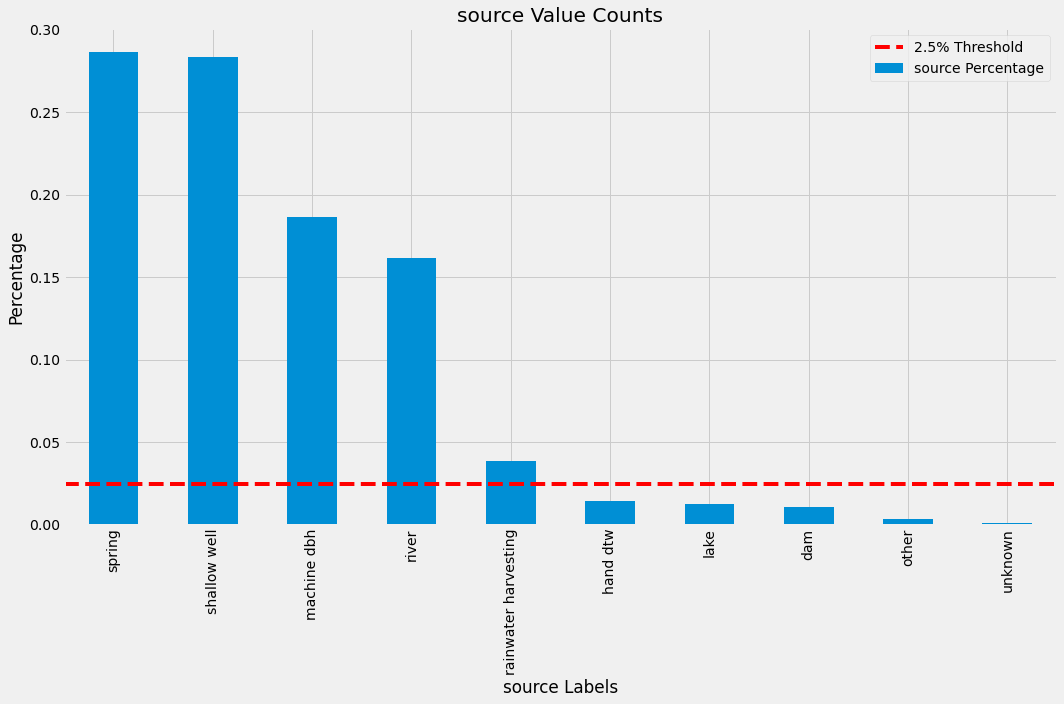

Column Name: source_type


Number of unique values: 7


There are 59393 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64




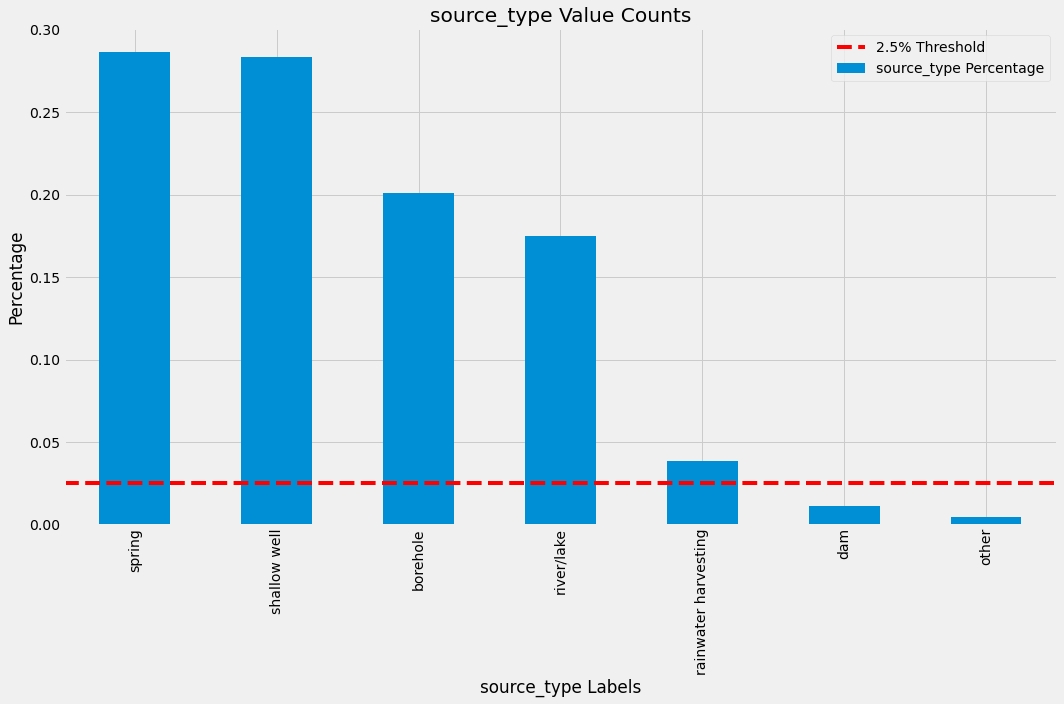

Column Name: source_class


Number of unique values: 3


There are 59397 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64




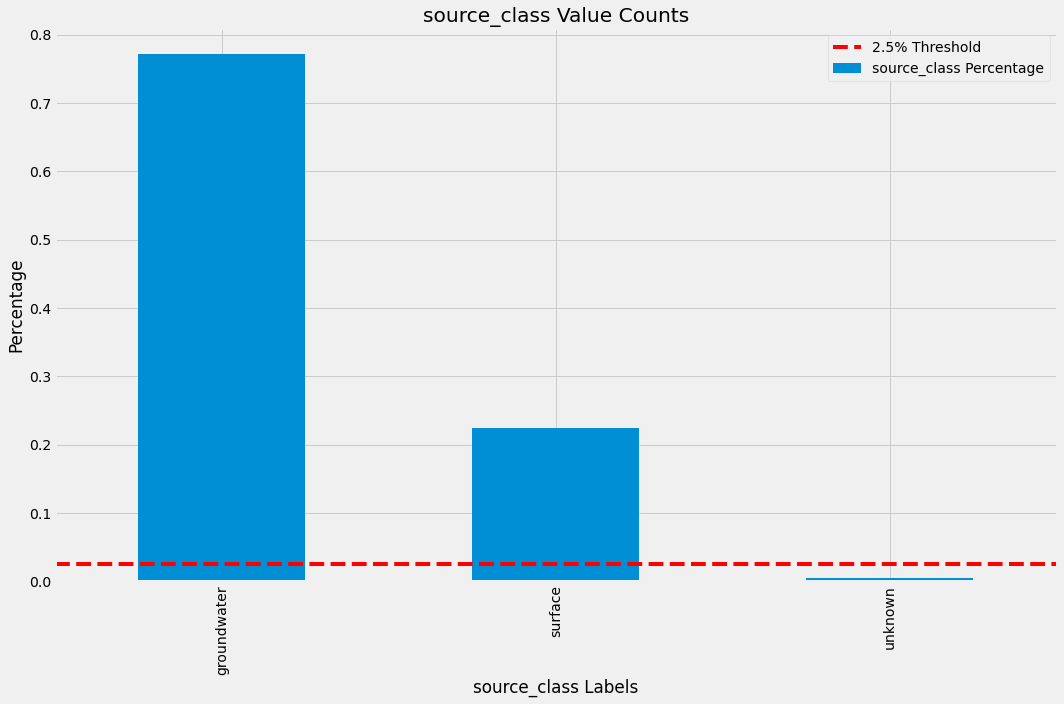

In [503]:
#evaluate the source, source_type, source_class features
col_eval(df_clean, cat_col=['source','source_type','source_class'])

In [504]:
#groupby to see redundancy
df_clean.groupby(by=['source_class','source_type','source']).count().index

MultiIndex([('groundwater',             'borehole',             'hand dtw'),
            ('groundwater',             'borehole',          'machine dbh'),
            ('groundwater',         'shallow well',         'shallow well'),
            ('groundwater',               'spring',               'spring'),
            (    'surface',                  'dam',                  'dam'),
            (    'surface', 'rainwater harvesting', 'rainwater harvesting'),
            (    'surface',           'river/lake',                 'lake'),
            (    'surface',           'river/lake',                'river'),
            (    'unknown',                'other',                'other'),
            (    'unknown',                'other',              'unknown')],
           names=['source_class', 'source_type', 'source'])

> **OBSERVATIONS**
> - `source_type` is redundant information

> **ACTIONS**
> - I will remove `source_type` and rename `source_class` as `source_type_1` and `source` as `source_type_2`

Column Name: waterpoint_type


Number of unique values: 7


There are 59393 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64




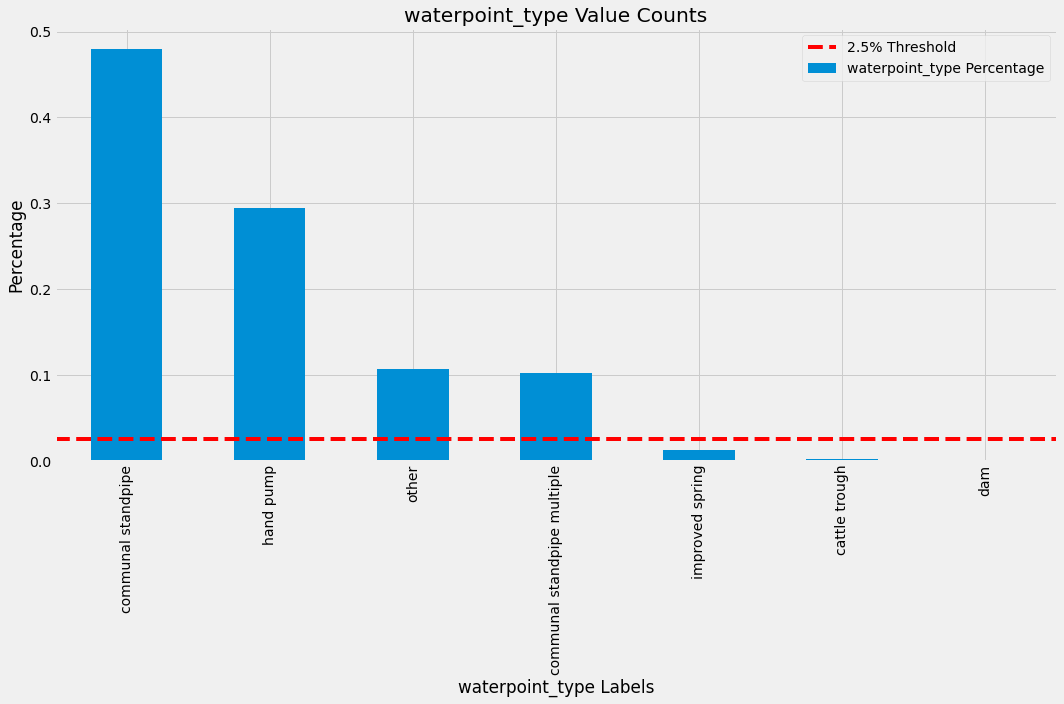

Column Name: waterpoint_type_group


Number of unique values: 6


There are 59394 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64




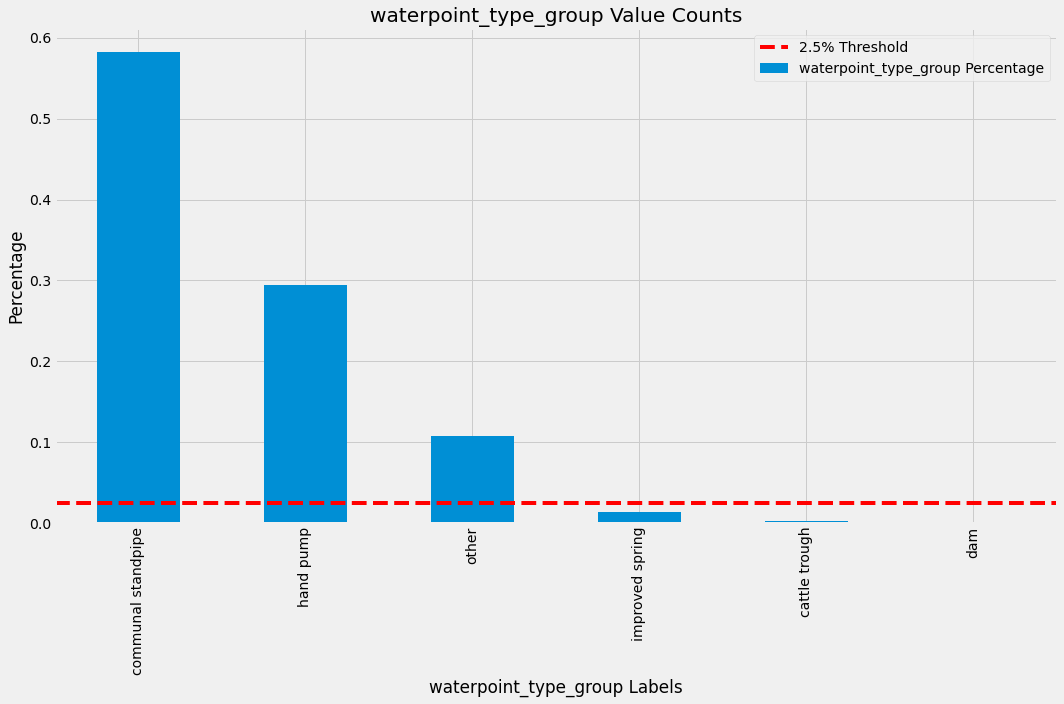

In [505]:
#evaluation waterpoint_type and waterpoint_type_group
col_eval(df_clean, cat_col=['waterpoint_type','waterpoint_type_group'])

In [506]:
#groupby to see redundancy
df_clean.groupby(by=['waterpoint_type','waterpoint_type_group']).count().index

MultiIndex([(              'cattle trough',      'cattle trough'),
            (         'communal standpipe', 'communal standpipe'),
            ('communal standpipe multiple', 'communal standpipe'),
            (                        'dam',                'dam'),
            (                  'hand pump',          'hand pump'),
            (            'improved spring',    'improved spring'),
            (                      'other',              'other')],
           names=['waterpoint_type', 'waterpoint_type_group'])

> **OBSERVATIONS**
> - features are the essentially the same. `waterpoint_type` has more granularity so will keep

> **ACTIONS**
> - Remove `waterpoint_type_group` feature

Column Name: status_group


Number of unique values: 3


There are 59397 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64




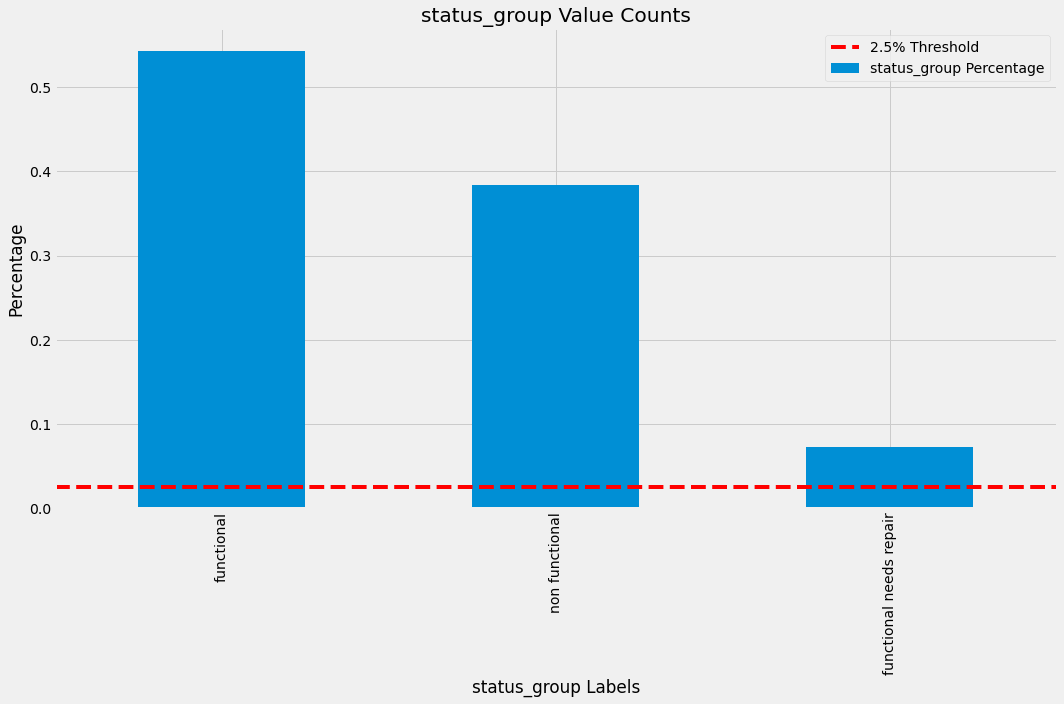

In [507]:
col_eval(df_clean, cat_col=['status_group'])

> **OBSERVATIONS**
> - I believe "functional needs repair" is equivalent to "non functional" since it suggests the waterpoint has a failure but is still somehow functional. To me, functional with a failure means that the waterpoint is operating at a degraded state and not as optimal as it could.

> **ACTIONS**
> - I will combine "functional needs repair" to the "non functional" group which will simplify the modeling as well.

==============================================================================================

> **SUMMARY OF ACTIONS TO TAKE**
> - recast `public_meeting` as string
> - recast `permit` as a string
> - recast `id` as categorical
> - recast `region_code` as categorical
> - recast `district_code` as categorical
> - drop `num_private`
> - drop `region_code`
> - drop `recorded_by`
> - drop `extraction_type_group`
> - drop `management_group`
> - drop `payment_type`
> - drop `quality_group`
> - drop `quantity_group`
> - drop `source_type`
> - drop `waterpoint_type_group`
> - drop `scheme_name`
> - drop `subvillage`
> - impute `construction_year`
> - impute `subvillage` and consolidate rare labels
> - impute 0's in `funder` and `installer` as "Unknown"
> - impute `public_meeting` missing values as "unknown"
> - impute null values in the `scheme_management` and `scheme_name` features as "Unknown"
> - impute `permit` nulls as "unknown"
> - impute missing values in `scheme_management` with "unknown"
> - rename `extraction_type_class` as `extraction_type_1` and `extraction_type` as `extraction_type_2` and rename labels
> - rename "soft" label to "soft-good" on `water_quality` feature
> - rename `source_class` as `source_type_1` and `source` as `source_type_2`
> - rename "functional needs repair" to "non functional" for the `status_group` feature
> - rename `payment` to `water_cost`
> - rename `quantity` as `water_quantity`
> - reduce cardinality in `funder` and `installer` features by consolidating rare labels
> - remove rows where longitude = 0

## Data Type Recasting

I will change data types of features here.

In [508]:
df_clean.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [509]:
#convert id to categorical
df_clean['id'] = df_clean['id'].astype('object')

In [510]:
#convert region_code to categorical
df_clean['region_code'] = df_clean['region_code'].astype('object')

In [511]:
#convert district_code to categorical
df_clean['district_code'] = df_clean['district_code'].astype('object')

In [512]:
df_clean['public_meeting'].value_counts(dropna=False)

True     51011
False     5055
NaN       3334
Name: public_meeting, dtype: int64

In [513]:
#convert public meeting to string type
df_clean['public_meeting'] = df_clean['public_meeting'].astype(str)

#convert 'nan' to nulls
df_clean['public_meeting'].replace('nan',np.nan, inplace=True)

In [514]:
df_clean['public_meeting'].value_counts(dropna=False)

True     51011
False     5055
NaN       3334
Name: public_meeting, dtype: int64

In [515]:
df_clean['permit'].value_counts(dropna=False)

True     38852
False    17492
NaN       3056
Name: permit, dtype: int64

In [516]:
#convert permit to string type
df_clean['permit'] = df_clean['permit'].astype(str)

#convert 'nan' to nulls
df_clean['permit'].replace('nan',np.nan, inplace=True)

In [517]:
df_clean['permit'].value_counts(dropna=False)

True     38852
False    17492
NaN       3056
Name: permit, dtype: int64

In [518]:
#extract the year from date_recorded feature
df_clean['date_recorded_yr'] = pd.to_datetime(df_clean['date_recorded']).dt.year
df_clean['date_recorded_yr'] = pd.to_datetime(df_clean['date_recorded']).dt.year
df_clean[['date_recorded_yr','date_recorded']].head()

date_recorded_yr date_recorded
0              2011    2011-03-14
1              2013    2013-03-06
2              2013    2013-02-25
3              2013    2013-01-28
4              2011    2011-07-13

In [519]:
#review dataframe
df_clean

id  amount_tsh date_recorded           funder  gps_height  \
0      69572     6,000.0    2011-03-14            Roman        1390   
1       8776         0.0    2013-03-06          Grumeti        1399   
2      34310        25.0    2013-02-25     Lottery Club         686   
3      67743         0.0    2013-01-28           Unicef         263   
4      19728         0.0    2011-07-13      Action In A           0   
...      ...         ...           ...              ...         ...   
59395  60739        10.0    2013-05-03  Germany Republi        1210   
59396  27263     4,700.0    2011-05-07      Cefa-njombe        1212   
59397  37057         0.0    2011-04-11              NaN           0   
59398  31282         0.0    2011-03-08            Malec           0   
59399  26348         0.0    2011-03-23       World Bank         191   

          installer   longitude     latitude              wpt_name  \
0             Roman 34.93809275  -9.85632177                  none   
1           GRUMETI  34.6987661  -2.14746569              Zahanati   
2      World vision 37.46066446  -3.82132853           Kwa Mahundi   
3            UNICEF 38.48616088 -11.15529772  Zahanati Ya Nanyumbu   
4           Artisan 31.13084671  -1.82535885               Shuleni   
...             ...         ...          ...                   ...   
59395           CES 37.16980689  -3.25384746   Area Three Namba 27   
59396          Cefa 35.24999126   -9.0706288     Kwa Yahona Kuvala   
59397           NaN 34.01708706  -8.75043433               Mashine   
59398          Musa 35.86131531  -6.37857327                Mshoro   
59399         World 38.10404822  -6.74746425       Kwa Mzee Lugawa   

       num_private                    basin    subvillage       region  \
0                0               Lake Nyasa      Mnyusi B       Iringa   
1                0            Lake Victoria       Nyamara         Mara   
2                0                  Pangani       Majengo      Manyara   
3                0  Ruvuma / Southern Coast    Mahakamani       Mtwara   
4                0            Lake Victoria    Kyanyamisa       Kagera   
...            ...                      ...           ...          ...   
59395            0                  Pangani      Kiduruni  Kilimanjaro   
59396            0                   Rufiji      Igumbilo       Iringa   
59397            0                   Rufiji     Madungulu        Mbeya   
59398            0                   Rufiji        Mwinyi       Dodoma   
59399            0              Wami / Ruvu  Kikatanyemba     Morogoro   

      region_code district_code             lga              ward  population  \
0              11             5          Ludewa          Mundindi         109   
1              20             2       Serengeti             Natta         280   
2              21             4       Simanjiro           Ngorika         250   
3              90            63        Nanyumbu          Nanyumbu          58   
4              18             1         Karagwe        Nyakasimbi           0   
...           ...           ...             ...               ...         ...   
59395           3             5             Hai  Masama Magharibi         125   
59396          11             4          Njombe            Ikondo          56   
59397          12             7         Mbarali           Chimala           0   
59398           1             4        Chamwino      Mvumi Makulu           0   
59399           5             2  Morogoro Rural        Ngerengere         150   

      public_meeting              recorded_by  ... permit construction_year  \
0               True  GeoData Consultants Ltd  ...  False              1999   
1                NaN  GeoData Consultants Ltd  ...   True              2010   
2               True  GeoData Consultants Ltd  ...   True              2009   
3               True  GeoData Consultants Ltd  ...   True              1986   
4               True  GeoData Consultants Ltd  ...   True  

## Feature/Row Drop

I will drop any unecessary features here. 

In [520]:
#drop all features outlined in feature evaluation for training set
df_clean = df_clean.drop(columns=['region_code','recorded_by','extraction_type_group',
                       'management_group','payment_type','quality_group',
                       'source_type','waterpoint_type_group','scheme_name',
                      'num_private','subvillage'])

In [521]:
#remove rows where longitude == 0 
df_clean.drop(df_clean.loc[df_clean['longitude'] == 0].index, inplace=True)

In [522]:
#check for date_recorded_year year earlier than construction year
df_clean.loc[df_clean['date_recorded_yr'] < df_clean['construction_year'], 
                       ['id']].count()

id    9
dtype: int64

In [523]:
#drop date_recorded
df_clean.drop(columns='date_recorded', inplace=True)

> **OBSERVATIONS**
> - There are some records where the `date_recorded_yr` is prior to the `construction_year`. 

> **ACTIONS**
> - I will remove these rows.

In [524]:
#drop rows
df_clean.drop(df_clean.loc[df_clean['date_recorded_yr'] < 
                           df_clean['construction_year']].index, inplace=True)

In [525]:
#check for date_recorded_year year earlier than construction year
df_clean.loc[df_clean['date_recorded_yr'] < df_clean['construction_year'], 
                       ['id']].count()

id    0
dtype: int64

## Feature and Label Renaming

I will rename features and labels here to make descriptions more concise.

In [526]:
#rename features
df_clean.rename(columns={'amount_tsh':'head','gps_height':'well_elevation'},
                inplace=True)

In [527]:
#rename extraction_type_class feature as extraction_type_1
df_clean.rename(columns={'extraction_type_class':'extraction_type_1'}, inplace=True)
df_clean.rename(columns={'extraction_type':'extraction_type_2'}, inplace=True)

In [528]:
#rename labels in extraction_type_2
df_clean.loc[df_clean['extraction_type_2'] == 'other - mkulima/shinyanga',
             ['extraction_type_2']] = 'mkulima/shinyanga'

df_clean.loc[df_clean['extraction_type_2'] == 'other - play pump',
             ['extraction_type_2']] = 'play pump'

df_clean.loc[df_clean['extraction_type_2'] == 'other - swn 81',
             ['extraction_type_2']] = 'swn 81'

df_clean.loc[df_clean['extraction_type_2'] == 'other - rope pump',
             ['extraction_type_2']] = 'rope pump'

In [529]:
#rename soft label as soft-good for water_quality feature
df_clean.loc[df_clean['water_quality'] == 'soft','water_quality'] = 'soft-good'

In [530]:
#rename source features
df_clean.rename(columns={'source_class':'source_type_1',
                         'source':'source_type_2'},inplace=True)

In [531]:
#update status_group labels
status_group_dict = {'functional':'functional',
                     'non functional':'non functional',
                     'functional needs repair':'non functional'}
df_clean['status_group'] = df_clean['status_group'].map(status_group_dict)
df_clean['status_group'].value_counts()

functional        31385
non functional    26194
Name: status_group, dtype: int64

In [532]:
#rename payment to water_cost
df_clean.rename(columns={'payment':'water_cost'},inplace=True)

In [533]:
#rename quantity to water_quantity
df_clean.rename(columns={'quantity':'water_quantity'}, inplace=True)

Column Name: funder


Number of unique values: 19


There are 57559 duplicates


There are 3622 null values


There are 777 zeros


Value Counts Percentage 
 Rare                      26754
Government Of Tanzania     8841
NaN                        3622
Danida                     3114
Hesawa                     1914
World Bank                 1345
Kkkt                       1286
World Vision               1224
Rwssp                      1187
Unicef                     1035
District Council            843
Tasaf                       834
Dhv                         829
Private Individual          824
0                           777
Norad                       765
Germany Republi             610
Tcrs                        602
Ministry Of Water           590
Water                       583
Name: funder, dtype: int64




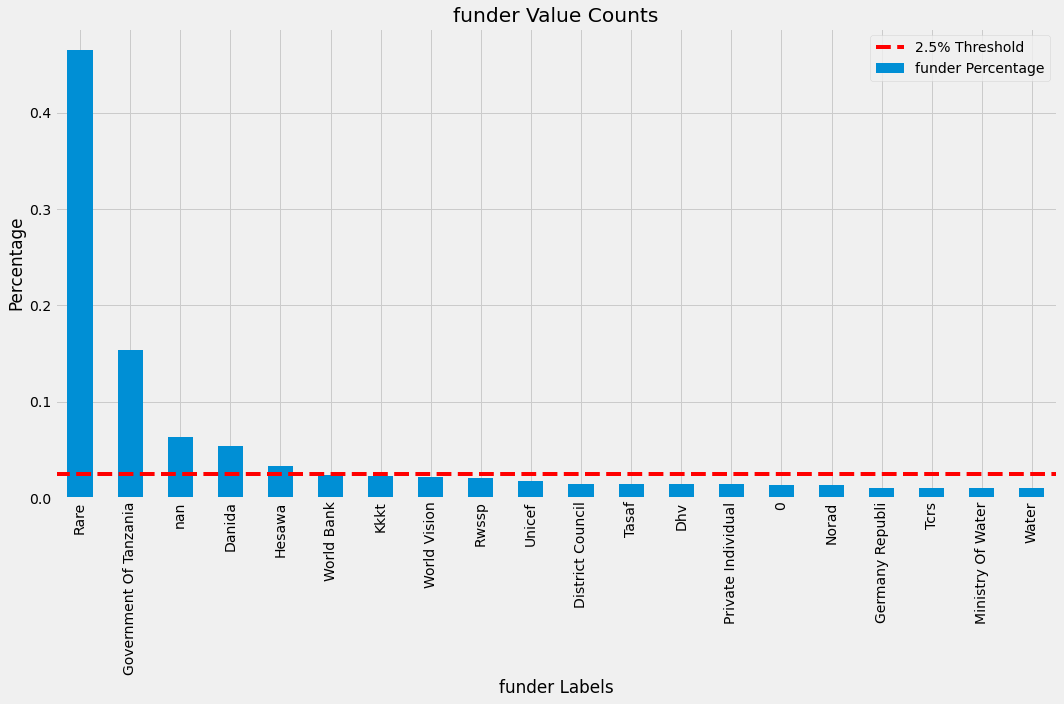

In [534]:
#create 'rare' consolidated label for funder
df_clean['funder'] = rare_labels(df_clean, 'funder', thresh=.01)
col_eval(df_clean, cat_col=['funder'])

Column Name: installer


Number of unique values: 14


There are 57564 duplicates


There are 3636 null values


There are 777 zeros


Value Counts Percentage 
 Rare                  27213
DWE                   16253
NaN                    3636
Government             1670
RWE                    1181
Commu                  1060
DANIDA                 1050
KKKT                    897
Hesawa                  803
0                       777
TCRS                    707
Central government      619
CES                     610
DANID                   552
District Council        551
Name: installer, dtype: int64




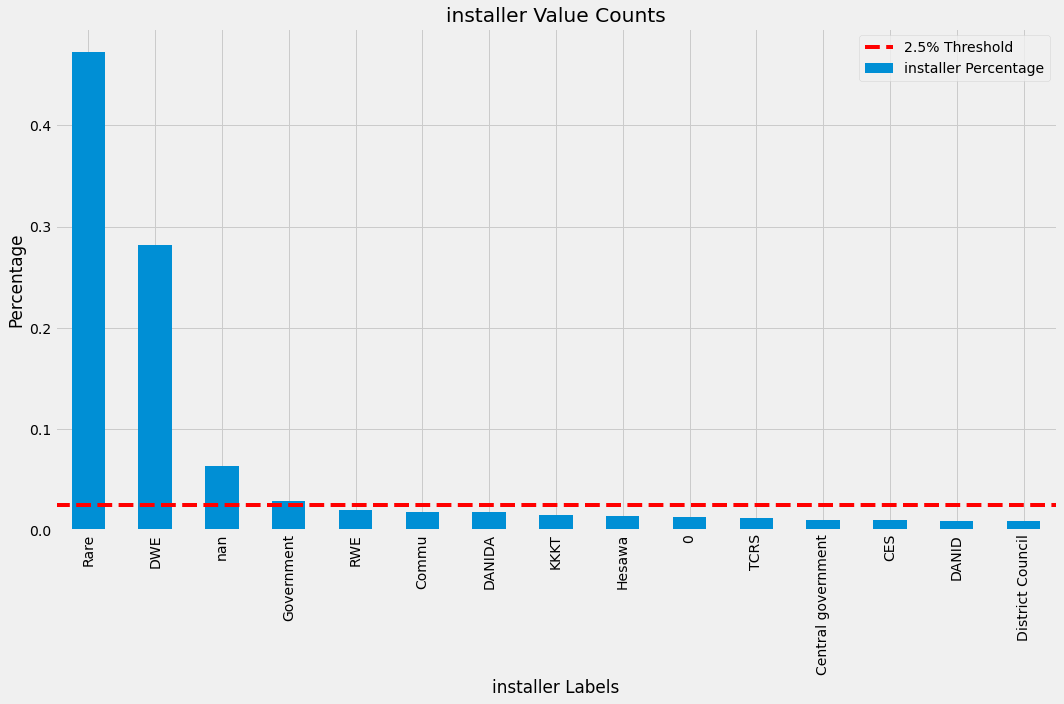

In [535]:
#create 'rare' consolidated label for installer
df_clean['installer'] = rare_labels(df_clean, 'installer', thresh=.01)
col_eval(df_clean, cat_col=['installer'])

Column Name: lga


Number of unique values: 87


There are 57492 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 Rare            6288
Njombe          2502
Arusha Rural    1252
Moshi Rural     1251
Rungwe          1106
                ... 
Nachingwea       300
Chunya           298
Mbulu            297
Ruangwa          291
Mkinga           288
Name: lga, Length: 87, dtype: int64




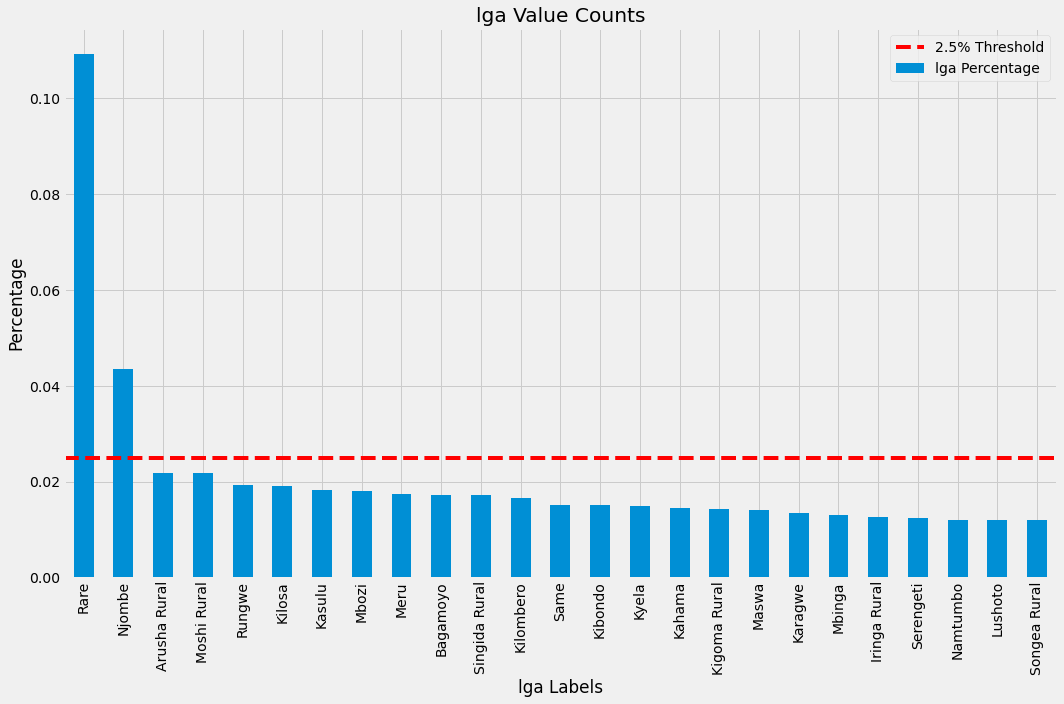

In [536]:
#create 'rare' consolidated label for lga
df_clean['lga'] = rare_labels(df_clean, 'lga', thresh=.005)
col_eval(df_clean, cat_col=['lga'])

Column Name: ward


Number of unique values: 223


There are 57356 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 Rare              37837
Igosi               307
Imalinyi            252
Siha Kati           232
Mdandu              231
                  ...  
Madibira             58
Masange              58
Sanje                58
Siha Kaskazini       58
Msongola             58
Name: ward, Length: 223, dtype: int64




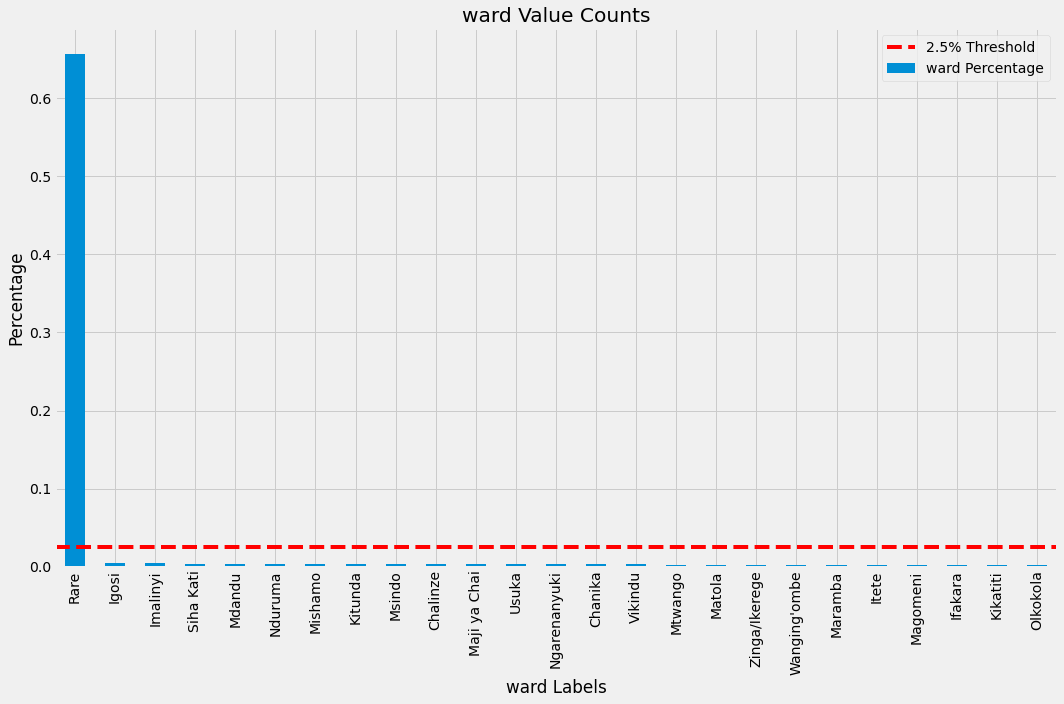

In [537]:
#create 'rare' consolidated label for ward
df_clean['ward'] = rare_labels(df_clean, 'ward', thresh=.001)
col_eval(df_clean, cat_col=['ward'])

Column Name: scheme_management


Number of unique values: 10


There are 57568 duplicates


There are 3750 null values


There are 0 zeros


Value Counts Percentage 
 VWC                 36136
WUG                  4249
NaN                  3750
Water authority      3151
WUA                  2882
Water Board          2747
Parastatal           1607
Private operator     1062
Company              1061
Other                 764
Rare                  170
Name: scheme_management, dtype: int64




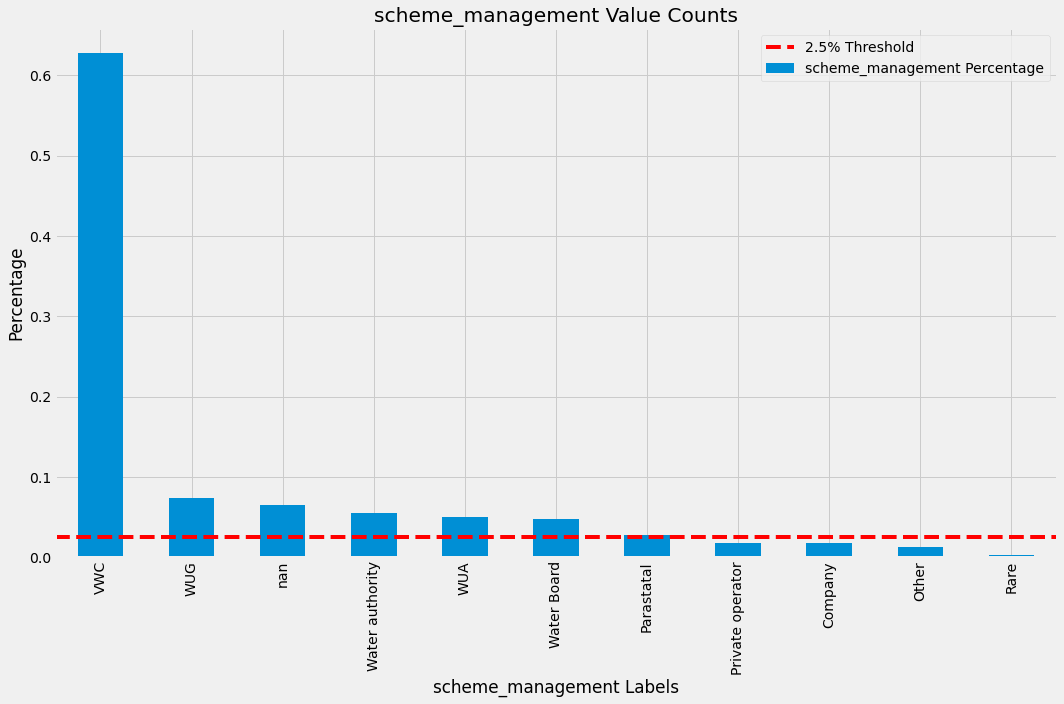

In [538]:
#create 'rare' consolidated label for scheme_management
df_clean['scheme_management'] = rare_labels(df_clean, 'scheme_management', thresh=.01)
col_eval(df_clean, cat_col=['scheme_management'])

Column Name: extraction_type_2


Number of unique values: 11


There are 57568 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 gravity          26693
nira/tanira       7360
other             6159
submersible       4688
swn 80            3447
mono              2817
india mark ii     2283
afridev           1659
ksb               1358
Rare               665
rope pump          450
Name: extraction_type_2, dtype: int64




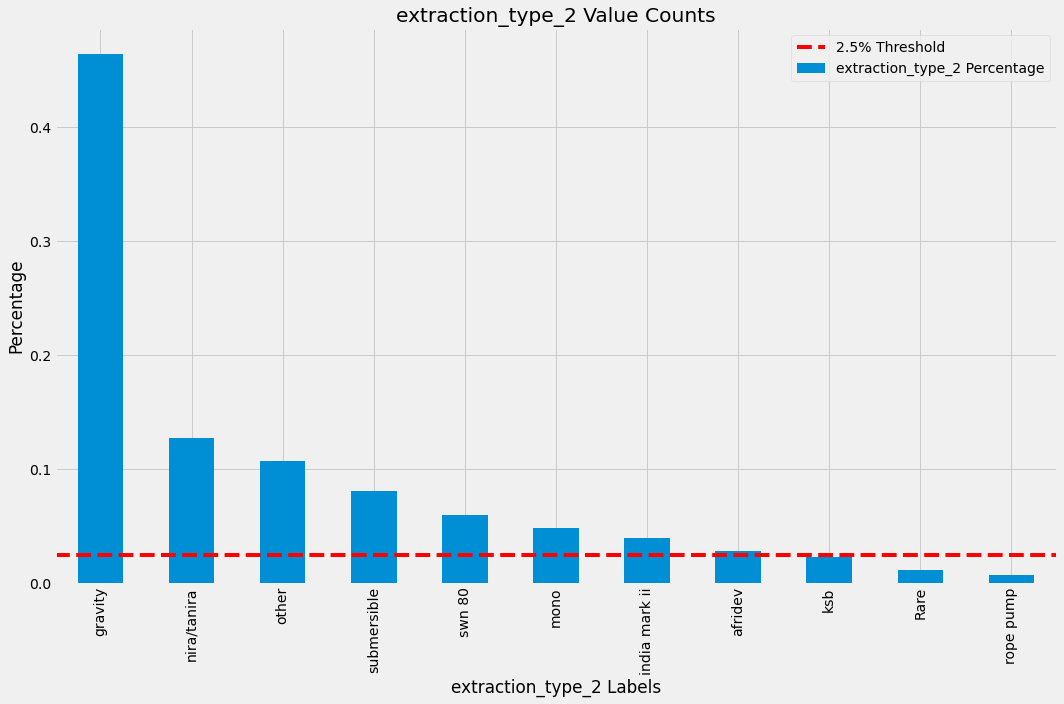

In [539]:
#create 'rare' consolidated label for extraction_type_2
df_clean['extraction_type_2'] = rare_labels(df_clean, 'extraction_type_2', thresh=.005)
col_eval(df_clean, cat_col=['extraction_type_2'])

Column Name: waterpoint_type


Number of unique values: 5


There are 57574 duplicates


There are 0 null values


There are 0 zeros


Value Counts Percentage 
 communal standpipe             28373
hand pump                      16176
other                           6289
communal standpipe multiple     5958
improved spring                  783
Name: waterpoint_type, dtype: int64




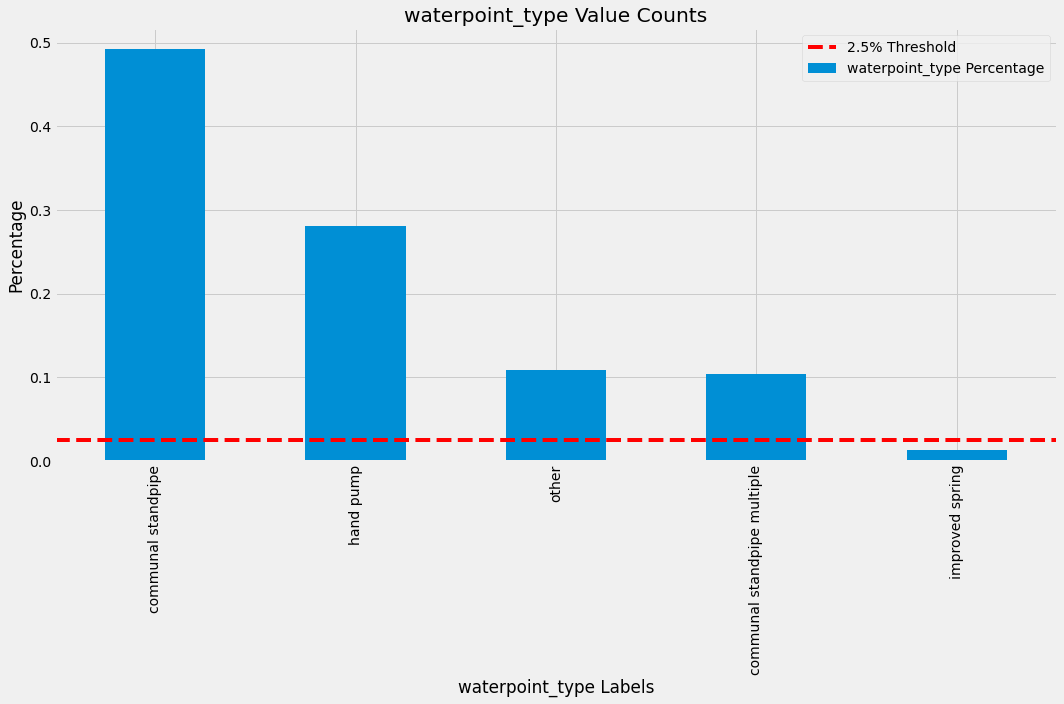

In [540]:
#move rare waterpoint_type into 'other' label
df_clean.loc[(df_clean['waterpoint_type'] == 'dam') | 
             (df_clean['waterpoint_type'] == 'cattle trough'),
                       'waterpoint_type'] = 'other'
col_eval(df_clean, cat_col=['waterpoint_type'])

In [541]:
#see how many columns have values equal to 0
for col in df_clean:
    count_num = (df_clean[col] == 0).sum()
    count_cat = (df_clean[col] == '0').sum()
    print(col,count_num, count_cat)

id 1 0
head 39822 0
funder 0 777
well_elevation 18626 0
installer 0 777
longitude 0 0
latitude 0 0
wpt_name 0 0
basin 0 0
region 0 0
district_code 23 0
lga 0 0
ward 0 0
population 19569 0
public_meeting 0 0
scheme_management 0 0
permit 0 0
construction_year 18897 0
extraction_type_2 0 0
extraction_type_1 0 0
management 0 0
water_cost 0 0
water_quality 0 0
water_quantity 0 0
quantity_group 0 0
source_type_2 0 0
source_type_1 0 0
waterpoint_type 0 0
status_group 0 0
date_recorded_yr 0 0


> **OBSERVATIONS**
> - `head`, `well_elevation`, `population`, `construction_year`, `funder` and `installer` all have 0's. It is only acceptable to have 0's for `head`, `well_elevation` and `population`

> **ACTIONS**
> - I will investigate if these columns have 0's together or separate and if they truly mean 0 for the columns that it could make sense for

In [542]:
#see how many values are equal to 0
for col in df_clean[['head','population','construction_year','well_elevation']]:
    count_num = (df_clean[col] == 0).sum()
    print(col,count_num)

head 39822
population 19569
construction_year 18897
well_elevation 18626


In [543]:
#review 0's in numeric categories
df_clean.groupby(['head','population','construction_year','well_elevation']).count()[['id']]

id
head      population construction_year well_elevation       
0.0       0          0                  0              17856
                                        150                1
                                        1332               1
                                        1363               1
                                        1456               1
...                                                      ...
138,000.0 587        2007              -7                  1
170,000.0 150        2008               127                1
200,000.0 800        0                  98                 1
250,000.0 80         2003               285                1
350,000.0 886        1990               1558               1

[38045 rows x 1 columns]

In [544]:
#check for null values
df_clean[['head','population','construction_year','well_elevation']].isna().sum()

head                 0
population           0
construction_year    0
well_elevation       0
dtype: int64

In [545]:
#find the rows where construction_year, head, population 
#and well_elevation are 0 and convert to null
df_clean.loc[(df_clean['head'] == 0) 
               & (df_clean['construction_year'] == 0) 
               & (df_clean['well_elevation'] == 0) 
               & (df_clean['population'] == 0),['head','construction_year',
                                                  'well_elevation','population']] = np.nan

In [546]:
#check changes were made
df_clean.loc[(df_clean['head'] == 0) 
               & (df_clean['construction_year'] == 0) 
               & (df_clean['well_elevation'] == 0) 
               & (df_clean['population'] == 0),['head','construction_year',
                                                  'well_elevation','population']]

Empty DataFrame
Columns: [head, construction_year, well_elevation, population]
Index: []

In [547]:
#recheck null counts
df_clean[['head','population','construction_year','well_elevation']].isna().sum()

head                 17856
population           17856
construction_year    17856
well_elevation       17856
dtype: int64

In [548]:
#see how many 0's are remaining
for col in df_clean[['head','population','construction_year','well_elevation']]:
    count_num = (df_clean[col] == 0).sum()
    print(col,count_num)

head 21966
population 1713
construction_year 1041
well_elevation 770


> **OBSERVATIONS**
> - I believe the remaining rows of 0's in `head`, `population` and `well_elevation` columns are reasonable. However, a `construction_year` of 0 does not make any sense

> **ACTIONS**
> - Convert the remaining 0's in `construction_year` to null
> - Eval methods for imputing null values in `head`, `population` and `well_elevation` 

In [549]:
#convert remaining 0's in construction_year to nulls
df_clean.loc[df_clean['construction_year'] == 0,['construction_year']] = np.nan

In [550]:
#check construction_year column for 0's
(df_clean['construction_year'] == 0).sum()

0

In [551]:
#convert original 0's to nulls
cat_conversion_list = ['installer','funder']
for col in cat_conversion_list:
    df_clean[col].replace('0', np.nan, inplace=True)

In [552]:
#change status_group to binary
df_clean['status_group'] = df_clean['status_group'].map({'functional':0, 'non functional':1})

In [553]:
#reorder features
df_clean = df_clean[['id','wpt_name','construction_year','waterpoint_type',
                     'water_quality','water_quantity','head',
                     'source_type_1','source_type_2','extraction_type_1',
                     'extraction_type_2','well_elevation','population',
                     'status_group','latitude','longitude','basin',
                     'district_code','region','lga','ward',
                     'funder','installer','permit','public_meeting',
                     'scheme_management','management','water_cost',
                     'date_recorded_yr']]

In [554]:
#state of the dataframe
df_clean

id              wpt_name  construction_year  \
0      69572                  none            1,999.0   
1       8776              Zahanati            2,010.0   
2      34310           Kwa Mahundi            2,009.0   
3      67743  Zahanati Ya Nanyumbu            1,986.0   
4      19728               Shuleni                nan   
...      ...                   ...                ...   
59395  60739   Area Three Namba 27            1,999.0   
59396  27263     Kwa Yahona Kuvala            1,996.0   
59397  37057               Mashine                nan   
59398  31282                Mshoro                nan   
59399  26348       Kwa Mzee Lugawa            2,002.0   

                   waterpoint_type water_quality water_quantity    head  \
0               communal standpipe     soft-good         enough 6,000.0   
1               communal standpipe     soft-good   insufficient     0.0   
2      communal standpipe multiple     soft-good         enough    25.0   
3      communal standpipe multiple     soft-good            dry     0.0   
4               communal standpipe     soft-good       seasonal     nan   
...                            ...           ...            ...     ...   
59395           communal standpipe     soft-good         enough    10.0   
59396           communal standpipe     soft-good         enough 4,700.0   
59397                    hand pump      fluoride         enough     nan   
59398                    hand pump     soft-good   insufficient     nan   
59399                    hand pump         salty         enough     0.0   

      source_type_1         source_type_2 extraction_type_1 extraction_type_2  \
0       groundwater                spring           gravity           gravity   
1           surface  rainwater harvesting           gravity           gravity   
2           surface                   dam           gravity           gravity   
3       groundwater           machine dbh       submersible       submersible   
4           surface  rainwater harvesting           gravity           gravity   
...             ...                   ...               ...               ...   
59395   groundwater                spring           gravity           gravity   
59396       surface                 river           gravity           gravity   
59397   groundwater           machine dbh          handpump            swn 80   
59398   groundwater          shallow well          handpump       nira/tanira   
59399   groundwater          shallow well          handpump       nira/tanira   

       well_elevation  population  status_group     latitude   longitude  \
0             1,390.0       109.0             0  -9.85632177 34.93809275   
1             1,399.0       280.0             0  -2.14746569  34.6987661   
2               686.0       250.0             0  -3.82132853 37.46066446   
3               263.0        58.0             1 -11.15529772 38.48616088   
4                 nan         nan             0  -1.82535885 31.13084671   
...               ...         ...           ...          ...         ...   
59395         1,210.0       125.0             0  -3.25384746 37.16980689   
59396         1,212.0        56.0             0   -9.0706288 35.24999126   
59397             nan         nan             0  -8.75043433 34.01708706   
59398             nan         nan             0  -6.37857327 35.86131531   
59399           191.0       150.0             0  -6.74746425 38.10404822   

                         basin district_code       region             lga  \
0                   Lake Nyasa             5       Iringa          Ludewa   
1                Lake Victoria             2         Mara       Serengeti   
2                      Pangani             4      Manyara       Simanjiro   
3      Ruvuma / Southern Coast            63       Mtwara            Rare   
4                Lake Victoria             1       Kagera         Karagwe   
...                        ...           ...          ...             ...   

## Outlier Removal

I will investigate removing outliers for the `head` feature as there are many values on the high extreme end that could not make sense. Instead of removing outlier rows, I will set the outlier value for `head` to null and then impute based on the remaining reasonable values.

array([[<AxesSubplot:title={'center':'head'}>]], dtype=object)

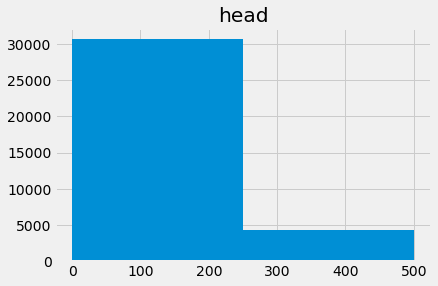

In [555]:
#head
df_clean.loc[df_clean['head'] <= 500, ['head']].hist(bins=2)

In [556]:
#percentage of head values below threshold
display((df_clean['head'] < 500).sum()/(len(df_clean)-
                                        df_clean['head'].isna().sum())*100,
        len(df_clean.loc[df_clean['head'] < 500]))

80.24318404954307

31875

In [557]:
#average head value above 500
df_clean.loc[df_clean['head'] >= 500,['head']].mean()

head   2,292.395514780836
dtype: float64

> **OBSERVATIONS**
> - 80% of the values for `head` are below 500 ft. of head (216.5 psi). This is extremely reasonable since most water wells supply water at a pressure of around 50-100 psi. For reference, a fire hose shoots water at around 150 psi or 345 ft. of head.  

> **ACTIONS**
> I will convert the values of `head` above 500 to null and then impute later with the remaining distribution

In [680]:
#current number of nulls in head
df_clean['head'].isna().sum()

25704

In [559]:
#convert head >= 500 to null
df_clean.loc[df_clean['head'] >= 500,['head']] = np.nan

In [560]:
#current number of nulls in head
df_clean['head'].isna().sum()

25704

## Train-Test Split

In [561]:
# #create train-test split
X = df_clean.drop(columns='status_group')
y = df_clean['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [562]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40305, 28), (17274, 28), (40305,), (17274,))

In [563]:
X_train_tf = X_train.copy()
X_test_tf = X_test.copy()

In [564]:
print(X_train_tf.shape,y_train.shape)

(40305, 28) (40305,)


## Imputation

In [565]:
#check for null values
X_train_tf.isnull().sum()

id                       0
wpt_name                 0
construction_year    13242
waterpoint_type          0
water_quality            0
water_quantity           0
head                 18017
source_type_1            0
source_type_2            0
extraction_type_1        0
extraction_type_2        0
well_elevation       12502
population           12502
latitude                 0
longitude                0
basin                    0
district_code            0
region                   0
lga                      0
ward                     0
funder                3103
installer             3111
permit                2175
public_meeting        2090
scheme_management     2589
management               0
water_cost               0
date_recorded_yr         0
dtype: int64

> **OBSERVATIONS**
> - null values in numeric features `construction_year`, `head`, `well_elevation` and `population`
> - null values in categorical features `funder`, `installer`, `permit`, `public_meeting` and `scheme_management`

> **ACTIONS**
> - impute null values for numeric features by using the current distribution of values
> - impute null values for categorical features by making them "Unknown"

### Impute Numeric Columns 

construction_year


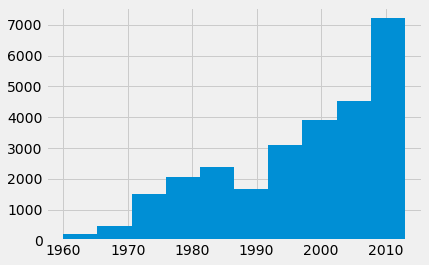

head


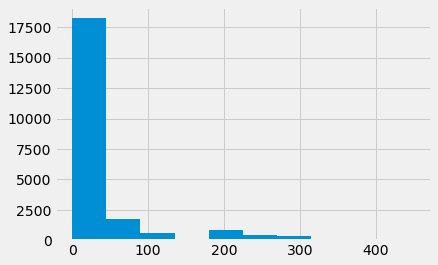

population


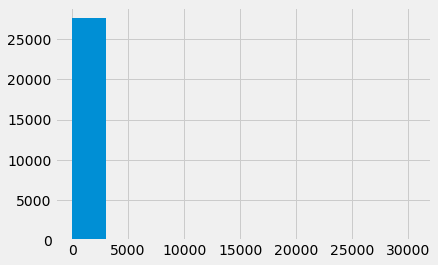

well_elevation


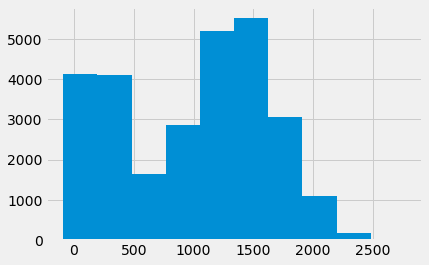

In [566]:
#current distribution of numeric columns
for col in ['construction_year','head','population','well_elevation']:
    print(col)
    X_train_tf[col].hist()
    plt.show()

In [567]:
#slice out numeric columns with nulls
impute_num = ['construction_year','head','population','well_elevation']

In [568]:
#random sample imputation
rs_imputer_construction_year = mdi.RandomSampleImputer(random_state = 123)
rs_imputer_head = mdi.RandomSampleImputer(random_state = 123)
rs_imputer_population = mdi.RandomSampleImputer(random_state = 123)
rs_imputer_well_elevation = mdi.RandomSampleImputer(random_state = 123)

In [569]:
#impute construction year
X_train_tf['construction_year'] = rs_imputer_construction_year.fit_transform(X_train_tf[['construction_year']])
X_test_tf['construction_year'] = rs_imputer_construction_year.transform(X_test_tf[['construction_year']])

In [570]:
#impute head
X_train_tf['head'] = rs_imputer_head.fit_transform(X_train_tf[['head']])
X_test_tf['head'] = rs_imputer_head.transform(X_test_tf[['head']])

In [571]:
#impute population
X_train_tf['population'] = rs_imputer_population.fit_transform(X_train_tf[['population']])
X_test_tf['population'] = rs_imputer_population.transform(X_test_tf[['population']])

In [572]:
#impute well_elevation
X_train_tf['well_elevation'] = rs_imputer_well_elevation.fit_transform(X_train_tf[['well_elevation']])
X_test_tf['well_elevation'] = rs_imputer_well_elevation.transform(X_test_tf[['well_elevation']])

construction_year


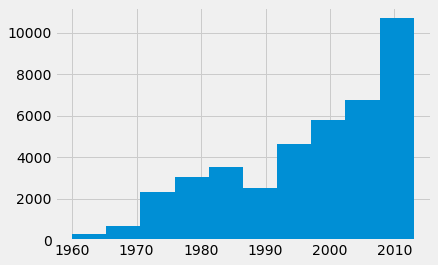

head


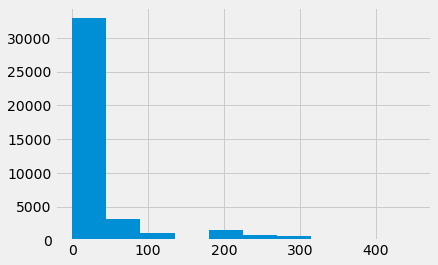

population


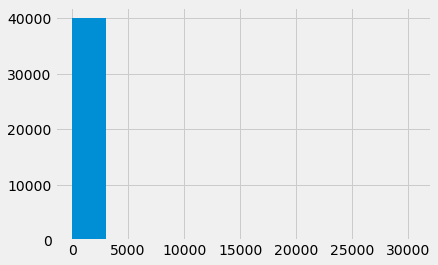

well_elevation


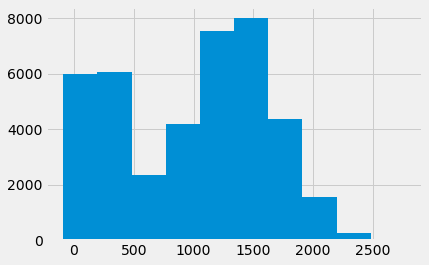

In [573]:
#current distribution of numeric columns
for col in ['construction_year','head','population','well_elevation']:
    print(col)
    X_train_tf[col].hist()
    plt.show()

In [574]:
#check for nulls in training set
X_train_tf.isna().sum()

id                      0
wpt_name                0
construction_year       0
waterpoint_type         0
water_quality           0
water_quantity          0
head                    0
source_type_1           0
source_type_2           0
extraction_type_1       0
extraction_type_2       0
well_elevation          0
population              0
latitude                0
longitude               0
basin                   0
district_code           0
region                  0
lga                     0
ward                    0
funder               3103
installer            3111
permit               2175
public_meeting       2090
scheme_management    2589
management              0
water_cost              0
date_recorded_yr        0
dtype: int64

In [575]:
#check for nulls in test set
X_test_tf.isna().sum()

id                      0
wpt_name                0
construction_year       0
waterpoint_type         0
water_quality           0
water_quantity          0
head                    0
source_type_1           0
source_type_2           0
extraction_type_1       0
extraction_type_2       0
well_elevation          0
population              0
latitude                0
longitude               0
basin                   0
district_code           0
region                  0
lga                     0
ward                    0
funder               1296
installer            1302
permit                881
public_meeting        885
scheme_management    1161
management              0
water_cost              0
date_recorded_yr        0
dtype: int64

### Impute Categorical Variables

In [576]:
#set columns to impuate
impute_cat = ['funder', 'installer', 'permit', 'public_meeting', 'scheme_management']

In [577]:
#categorical imputer with "Unknown"
unknown_imputer = mdi.CategoricalImputer(fill_value='Unknown')
X_train_tf[impute_cat] = unknown_imputer.fit_transform(X_train_tf[impute_cat])
X_test_tf[impute_cat] = unknown_imputer.transform(X_test_tf[impute_cat])

In [578]:
#check for missing values
X_train_tf[impute_cat].isna().sum()

funder               0
installer            0
permit               0
public_meeting       0
scheme_management    0
dtype: int64

## Feature Engineering

In this section I will develop new features which I believe will improve the ability to gain insights into the data and possibly help modeling.

### `well_age`

`well_age` will allow insight into how age of the well impacts operability. This feature will be created by taking the max of `recorded_date` and subtracting the `construction_year`. 

In [579]:
X_train_tf['construction_year'].value_counts()

2,010.0    2744
2,008.0    2702
2,009.0    2603
2,000.0    2187
2,007.0    1673
2,006.0    1565
2,011.0    1361
2,003.0    1327
2,004.0    1160
2,012.0    1128
1,978.0    1115
2,002.0    1088
1,995.0    1072
2,005.0    1036
1,999.0    1008
1,998.0     999
1,990.0     980
1,985.0     954
1,980.0     870
1,996.0     809
1,982.0     796
1,984.0     777
1,994.0     773
1,972.0     760
1,974.0     715
1,997.0     682
1,992.0     654
1,993.0     632
1,988.0     552
2,001.0     528
1,983.0     518
1,975.0     481
1,986.0     473
1,976.0     454
1,970.0     450
1,989.0     362
1,991.0     327
1,987.0     289
1,981.0     224
1,977.0     203
1,979.0     195
1,973.0     193
2,013.0     170
1,971.0     162
1,960.0      97
1,967.0      94
1,963.0      83
1,968.0      82
1,969.0      53
1,964.0      39
1,961.0      34
1,962.0      30
1,965.0      24
1,966.0      18
Name: construction_year, dtype: int64

In [580]:
#create well_age feature
max_date_recorded = df_clean['date_recorded_yr'].max()

X_train_tf['well_age'] = max_date_recorded - X_train_tf['construction_year']
X_test_tf['well_age'] = max_date_recorded - X_test_tf['construction_year']
X_train_tf['well_age'].value_counts()

3.0     2744
5.0     2702
4.0     2603
13.0    2187
6.0     1673
7.0     1565
2.0     1361
10.0    1327
9.0     1160
1.0     1128
35.0    1115
11.0    1088
18.0    1072
8.0     1036
14.0    1008
15.0     999
23.0     980
28.0     954
33.0     870
17.0     809
31.0     796
29.0     777
19.0     773
41.0     760
39.0     715
16.0     682
21.0     654
20.0     632
25.0     552
12.0     528
30.0     518
38.0     481
27.0     473
37.0     454
43.0     450
24.0     362
22.0     327
26.0     289
32.0     224
36.0     203
34.0     195
40.0     193
0.0      170
42.0     162
53.0      97
46.0      94
50.0      83
45.0      82
44.0      53
49.0      39
52.0      34
51.0      30
48.0      24
47.0      18
Name: well_age, dtype: int64

In [581]:
#drop date_recorded_yr feature
X_train_tf.drop(columns='date_recorded_yr', inplace=True)
X_test_tf.drop(columns='date_recorded_yr', inplace=True)

In [582]:
#drop construction year
X_train_tf.drop(columns='construction_year', inplace=True)
X_test_tf.drop(columns='construction_year', inplace=True)

### `impact_rating`

I want to create a feature which summarizes the impact each well has on the community. This feature will weigh the following features:
1. `status_group`
    - functional +0
    - broken +10
    - not functional +15
2. `population`
    - 25th percentile +0
    - 50th percentile +1
    - 75th percentile +2
    - 100th percentile +3
3. `amount_tsh`
    - 25th percentile +3
    - 50th percentile +2
    - 75th percentile +1
    - 100th percentile +0
4. `water_quality`
    - 25th percentile +3
    - 50th percentile +2
    - 75th percentile +1
    - 100th percentile +0
5. `quantity`
    - 25th percentile +3
    - 50th percentile +2
    - 75th percentile +1
    - 100th percentile +0
6. `well_age`
    - 25th percentile +0
    - 50th percentile +1
    - 75th percentile +2
    - 100th percentile +3
    
These metrics all describe how impactful water is to the surrounding community and will help bring insight into which water wells need to be prioritized amongst the rest.

# DATA EXPLORATION

In this section I will explore the clean data to try and examine insights that will help my stakeholder understand the reliability of the water wells.

In [583]:
#create data exploration df
df_explore = pd.concat([X_train_tf, X_test_tf], axis=0)
df_explore['status_group'] = pd.concat([y_train, y_test])

In [584]:
#make a copy for linear assumptions checks
df_explore_binary = df_explore.copy()

In [585]:
#convert status group back to words for EDA
df_explore['status_group'] = df_explore['status_group'].map({0:'functional',1:'non functional'})

In [586]:
#explore the dataframe
df_explore

id                      wpt_name     waterpoint_type water_quality  \
54135  15943               Kwa Mzee Hatibu  communal standpipe     soft-good   
48894  60505    Sangamwalugesha Dispensary  communal standpipe     soft-good   
42712  46820                        Matini  communal standpipe     soft-good   
13607  60027           Kwa Nasta Mtelekele  communal standpipe     soft-good   
32769  48531                        Eliabu  communal standpipe     soft-good   
...      ...                           ...                 ...           ...   
57277  55065                     Kwa Mkiwa           hand pump     soft-good   
18529  73535  Kota Za Watumishi Mbalimbali  communal standpipe     soft-good   
38833  37749                     Nyashenye     improved spring     soft-good   
24890   6125        Kwa Mzee Amoni Nsekelo  communal standpipe     soft-good   
34547  73102                  Kwakatembo 1               other     soft-good   

      water_quantity  head source_type_1         source_type_2  \
54135         enough   0.0   groundwater                spring   
48894       seasonal   0.0       surface  rainwater harvesting   
42712   insufficient   0.0   groundwater                spring   
13607         enough  10.0       surface                 river   
32769         enough   0.0   groundwater                spring   
...              ...   ...           ...                   ...   
57277         enough   0.0   groundwater          shallow well   
18529       seasonal   0.0       surface                   dam   
38833         enough  50.0   groundwater                spring   
24890         enough  20.0   groundwater                spring   
34547   insufficient   0.0   groundwater          shallow well   

      extraction_type_1 extraction_type_2  well_elevation  population  \
54135           gravity           gravity           973.0         1.0   
48894           gravity           gravity           287.0       250.0   
42712           gravity           gravity         1,813.0       150.0   
13607           gravity           gravity         1,293.0        60.0   
32769           gravity           gravity           290.0       300.0   
...                 ...               ...             ...         ...   
57277          handpump            swn 80         1,015.0       200.0   
18529             other             other           750.0       150.0   
38833           gravity           gravity         1,490.0       300.0   
24890           gravity           gravity             0.0       200.0   
34547             other             other            34.0       256.0   

          latitude          longitude                    basin district_code  \
54135   -4.4381008         38.3417691                  Pangani             1   
48894  -3.41527115        34.09722151                 Internal             2   
42712  -3.26306705        36.63840223                  Pangani             2   
13607  -9.08679269        35.23747759                   Rufiji             4   
32769  -2.52280475        30.85073141            Lake Victoria            30   
...            ...                ...                      ...           ...   
57277 -10.47122748        35.68695641               Lake Nyasa             5   
18529  -5.60955895          32.745182          Lake Tanganyika             5   
38833  -1.39787776 31.807050399999994            Lake Victoria             2   
24890  -9.21892401        33.59424569               Lake Nyasa             4   
34547  -8.52583866        39.17491936  Ruvuma / Southern Coast            13   

          region           lga      ward                  funder installer  \
54135      Tanga       Lushoto      Rare  Government Of Tanzania       DWE   
48894  Shinyanga         Maswa      Rare                    Rare      Rare   
42712     Arusha  Arusha Rural  Olkokola            World Vision       DWE   
13607     Iringa        Njombe      Rare                    Rare      Rare   
32769     Kagera         Nga

In [587]:
#export original dataframe to Tableau
# df_explore.to_csv(r'Data/water_well_data_for_tableau_imputed.csv', index=False, header=True)

## Functional vs Not Functional

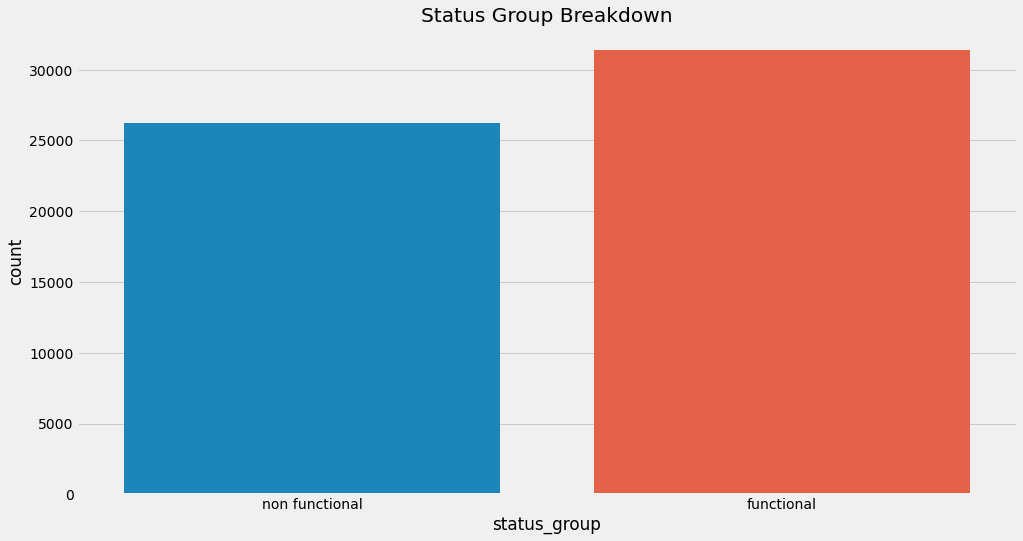

In [588]:
#create plot
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.countplot(data=df_explore, x='status_group');
ax.set_title('Status Group Breakdown');

## Number of Functional/Not Functional Water Wells by Well Age

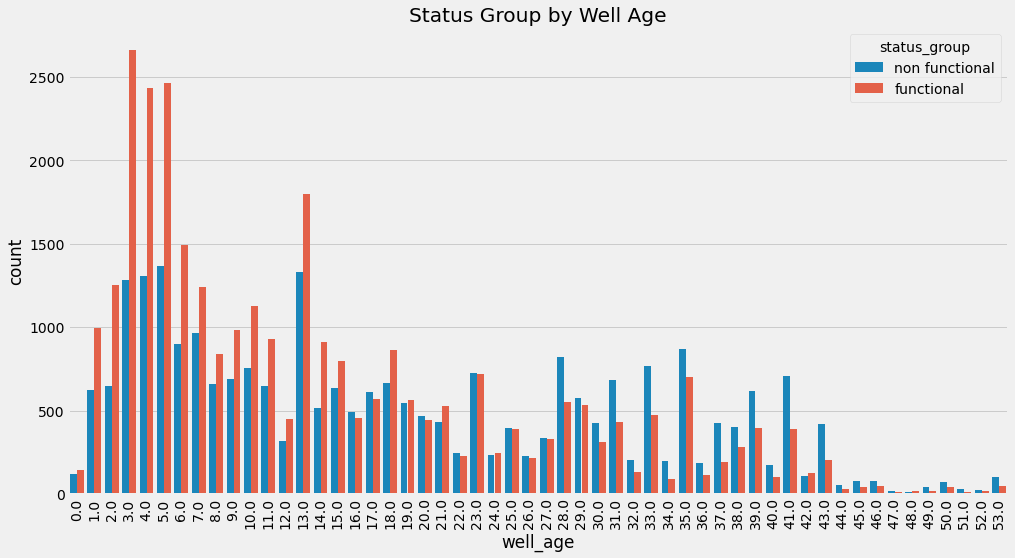

In [589]:
#create a barplot
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.countplot(data=df_explore, x='well_age', hue='status_group');
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Status Group by Well Age');

## What age do wells start to not function more than they function?

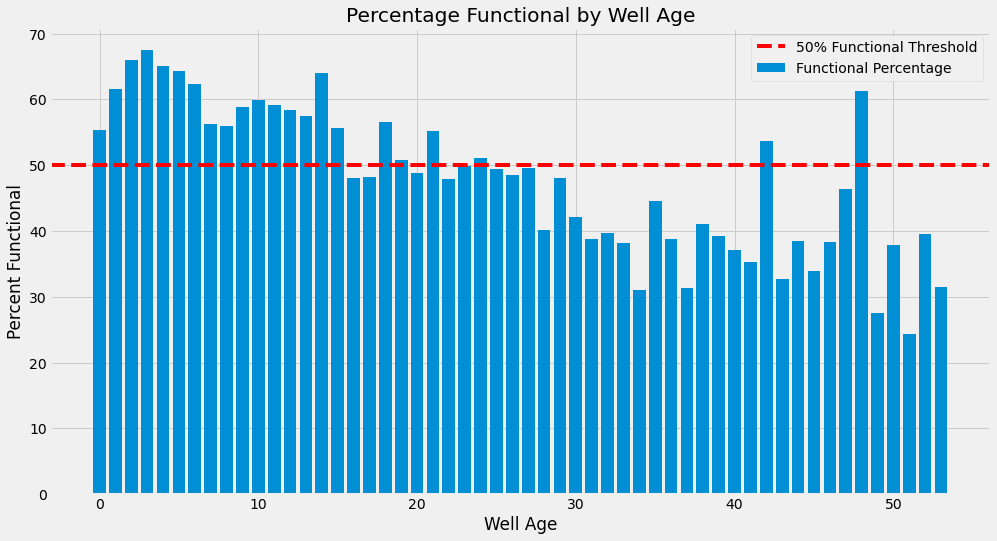

In [590]:
fig, ax = plt.subplots(figsize=(15,8))
status_group_ratio_df = pd.DataFrame(df_explore.groupby(by=['well_age','status_group'])[['id']].count())
percent_df = status_group_ratio_df.groupby(level=0).apply(lambda x: x / float(x.sum())*100)
percent_df.reset_index(inplace=True)
functional_percent_df = percent_df.loc[(percent_df['status_group'] == 'functional') & (percent_df['well_age'] != 2013)]
functional_percent_df
plt.bar(data=functional_percent_df, x='well_age',height='id', label='Functional Percentage')
ax.axhline(y=50, color='red', linestyle='--', 
                        label=f'50% Functional Threshold');
ax.set_title('Percentage Functional by Well Age')
ax.set_xlabel('Well Age')
ax.set_ylabel('Percent Functional')
plt.legend();

> **OBSERVATIONS**
> - The ratio of functional to non-functional wells consistently goes below 50% around a well age of 25 years.

## Which technologies are most reliable?

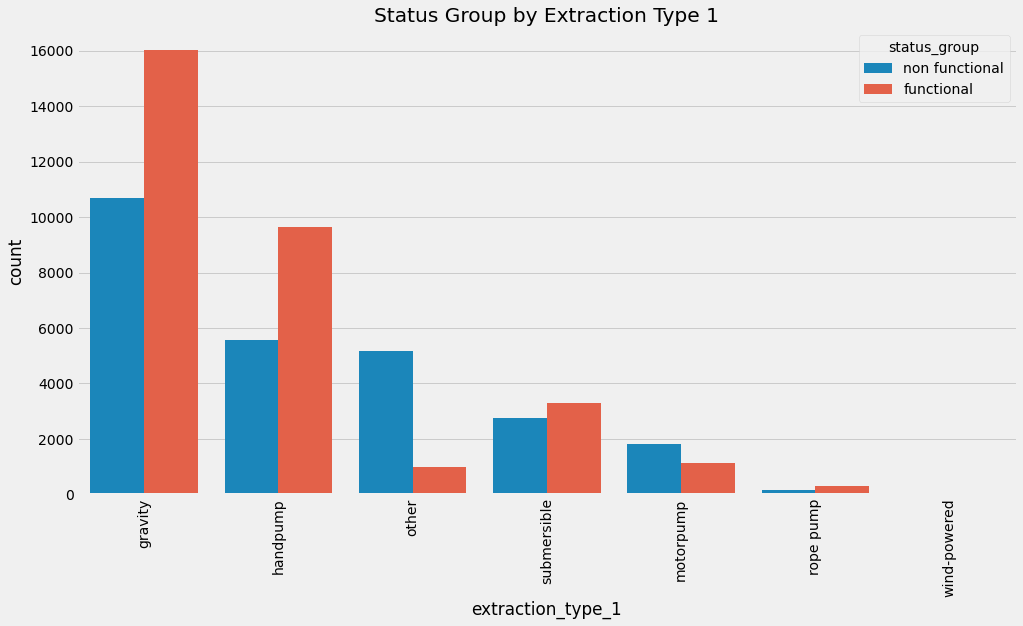

In [591]:
#create a barplot
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.countplot(data=df_explore, x='extraction_type_1', hue='status_group', 
                   order=df_explore['extraction_type_1'].value_counts().index);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Status Group by Extraction Type 1');

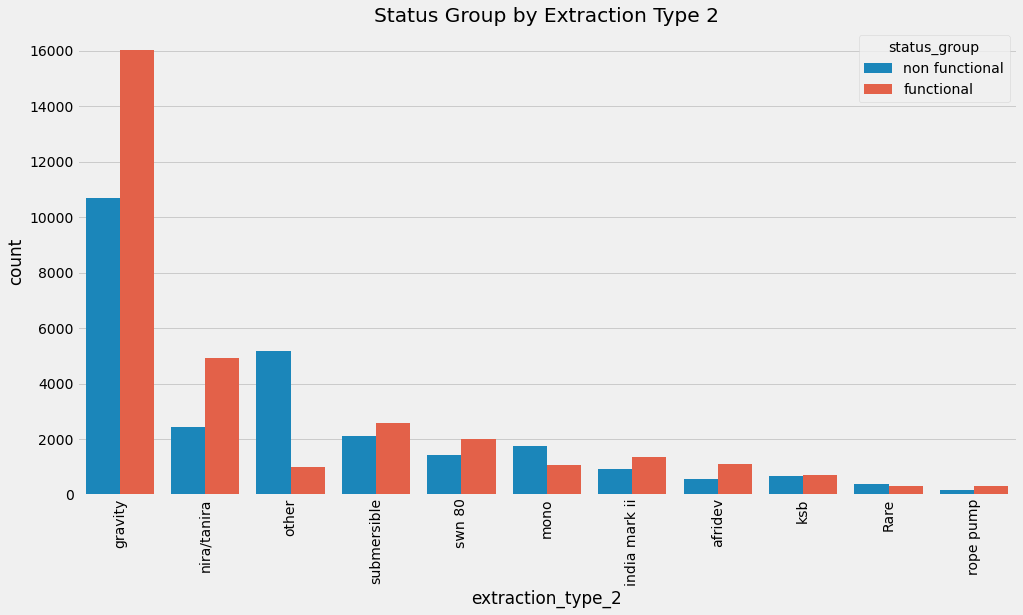

In [592]:
#create a barplot
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.countplot(data=df_explore, x='extraction_type_2', hue='status_group',
                  order=df_explore['extraction_type_2'].value_counts().index);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Status Group by Extraction Type 2');

## What regions have the most failures

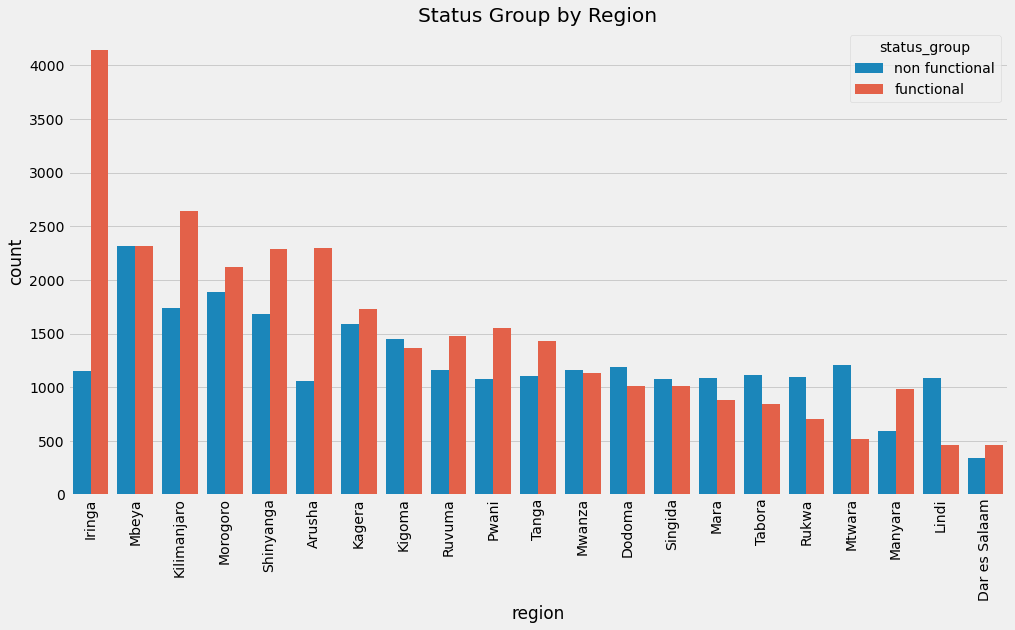

In [593]:
#create a barplot
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.countplot(data=df_explore, x='region', hue='status_group',
                  order=df_explore['region'].value_counts().index);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Status Group by Region');

## How does water quality affect reliability?

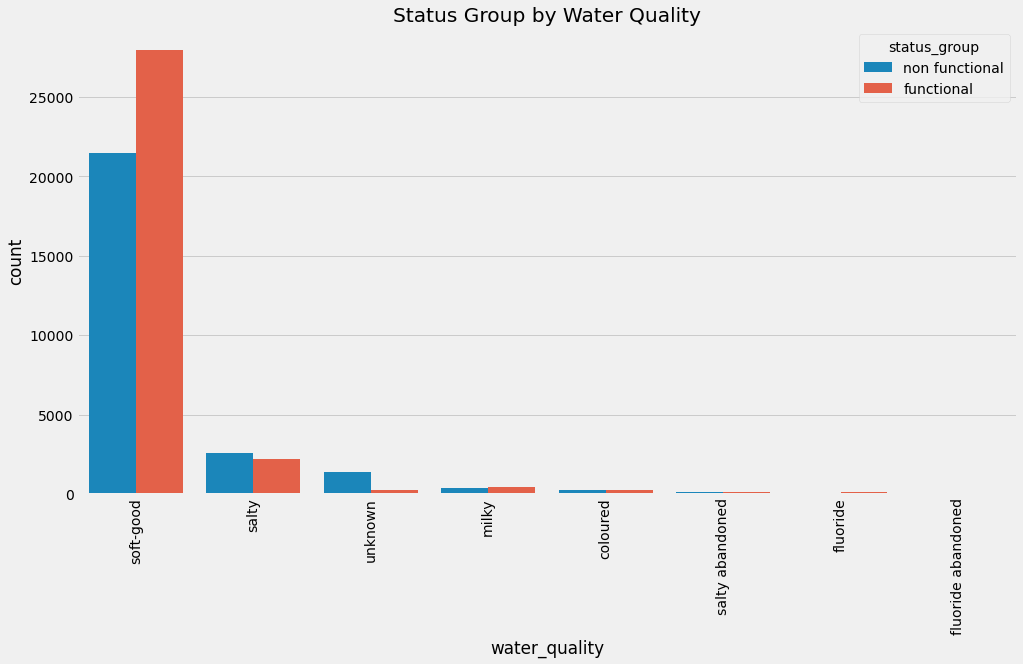

In [594]:
#create a barplot
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.countplot(data=df_explore, x='water_quality', hue='status_group',
                  order=df_explore['water_quality'].value_counts().index);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Status Group by Water Quality');

> **OBSERVATIONS**
> - It seems that reliability goes down as your water quality degrades beyond 'soft-good'. Salty water specifically is highly corrosive and will lead to the corrosion of any metal components.

## How does the operator affect reliability?

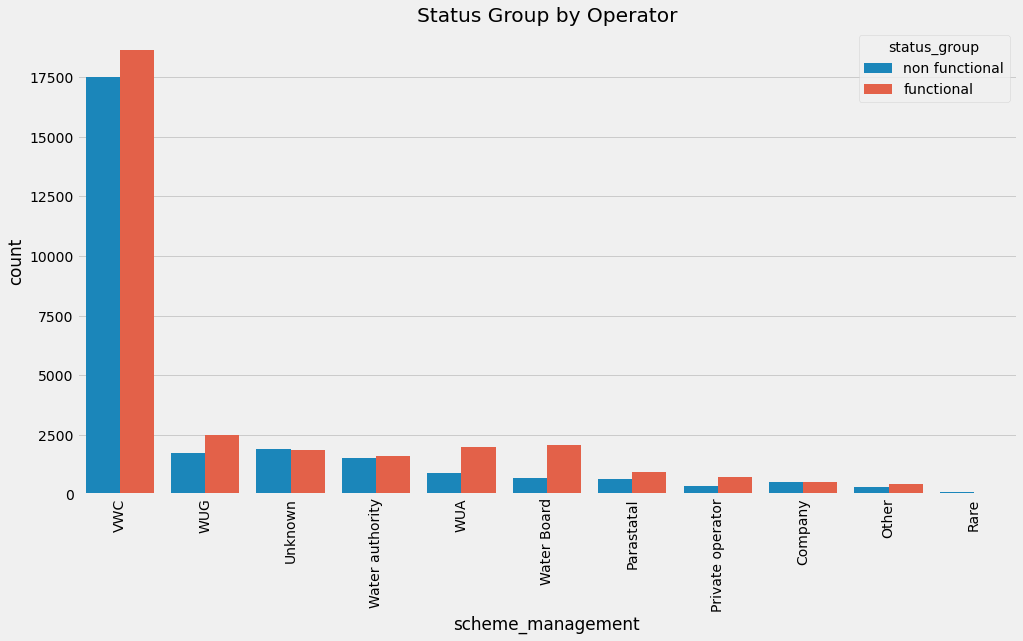

In [595]:
#create a barplot
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.countplot(data=df_explore, x='scheme_management', hue='status_group',
                  order=df_explore['scheme_management'].value_counts().index[:50]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Status Group by Operator');

In [596]:
df_explore.columns

Index(['id', 'wpt_name', 'waterpoint_type', 'water_quality', 'water_quantity',
       'head', 'source_type_1', 'source_type_2', 'extraction_type_1',
       'extraction_type_2', 'well_elevation', 'population', 'latitude',
       'longitude', 'basin', 'district_code', 'region', 'lga', 'ward',
       'funder', 'installer', 'permit', 'public_meeting', 'scheme_management',
       'management', 'water_cost', 'well_age', 'status_group'],
      dtype='object')

## Which Technologies cost the most

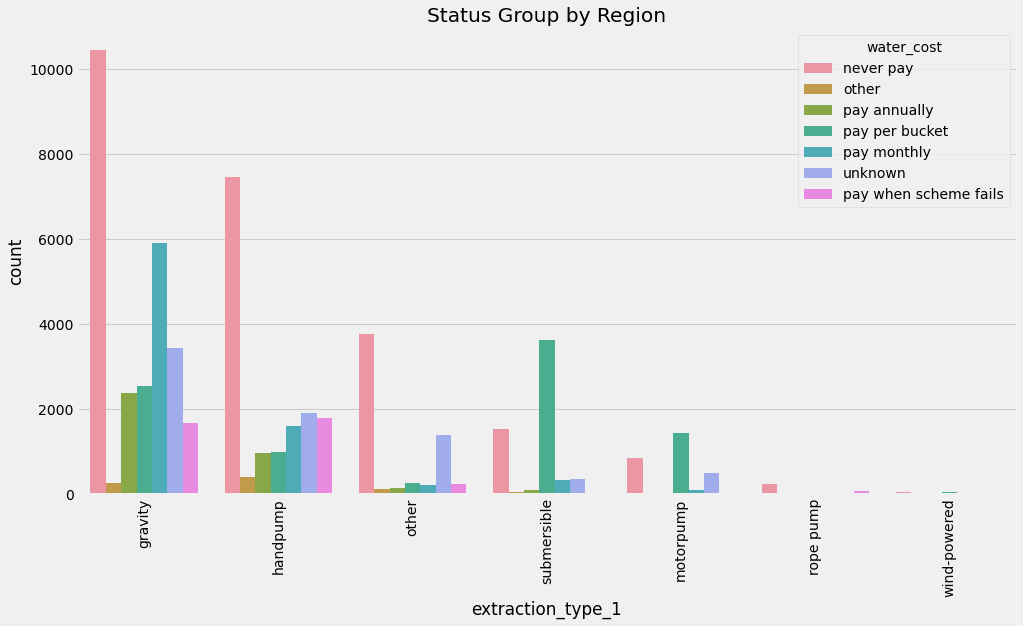

In [597]:
#create a barplot
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.countplot(data=df_explore, x='extraction_type_1', hue='water_cost',
                  order=df_explore['extraction_type_1'].value_counts().index[:50]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Status Group by Region');

## How does water source affect reliability?

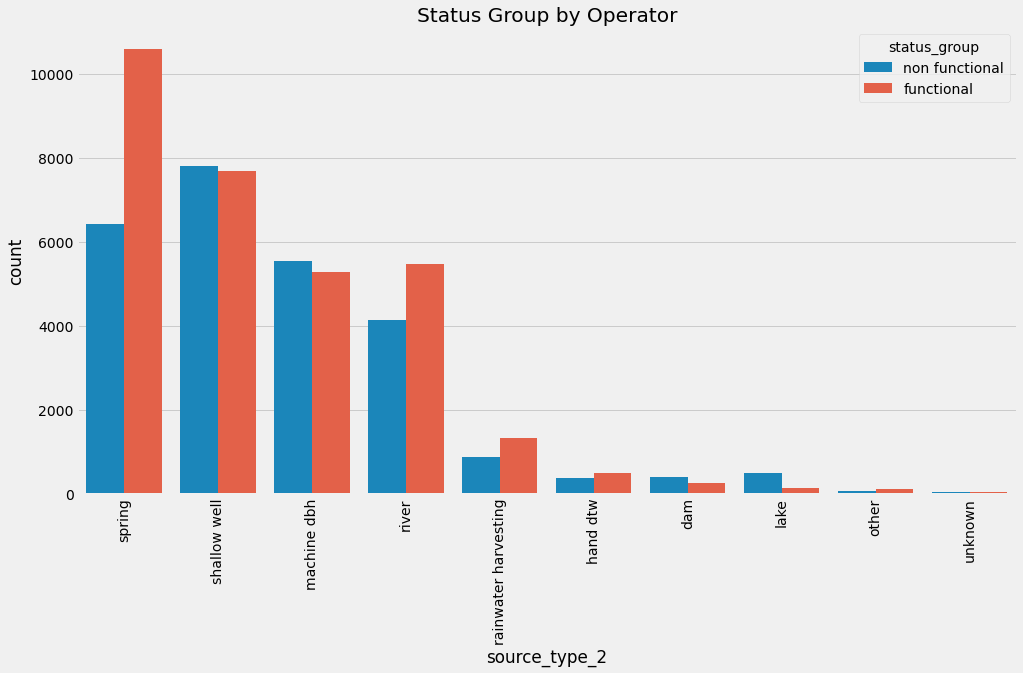

In [598]:
#create a barplot
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.countplot(data=df_explore, x='source_type_2', hue='status_group',
                  order=df_explore['source_type_2'].value_counts().index[:50]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Status Group by Operator');

## How does water source affect water quality

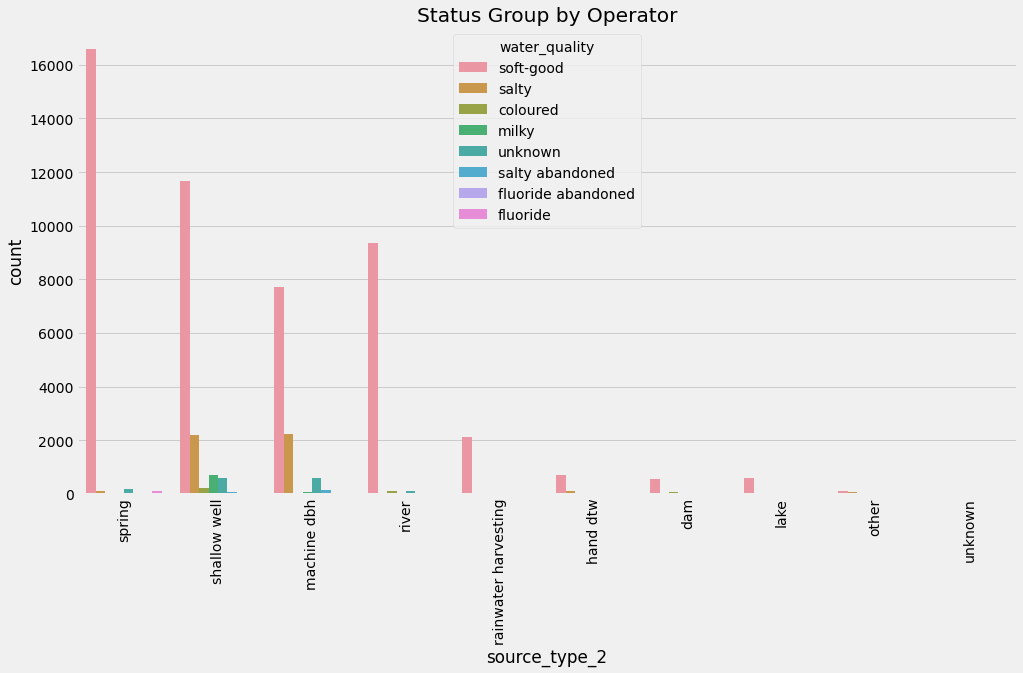

In [599]:
#create a barplot
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.countplot(data=df_explore, x='source_type_2', hue='water_quality',
                  order=df_explore['source_type_2'].value_counts().index[:50]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Status Group by Operator');

## How does water source affect water quantity

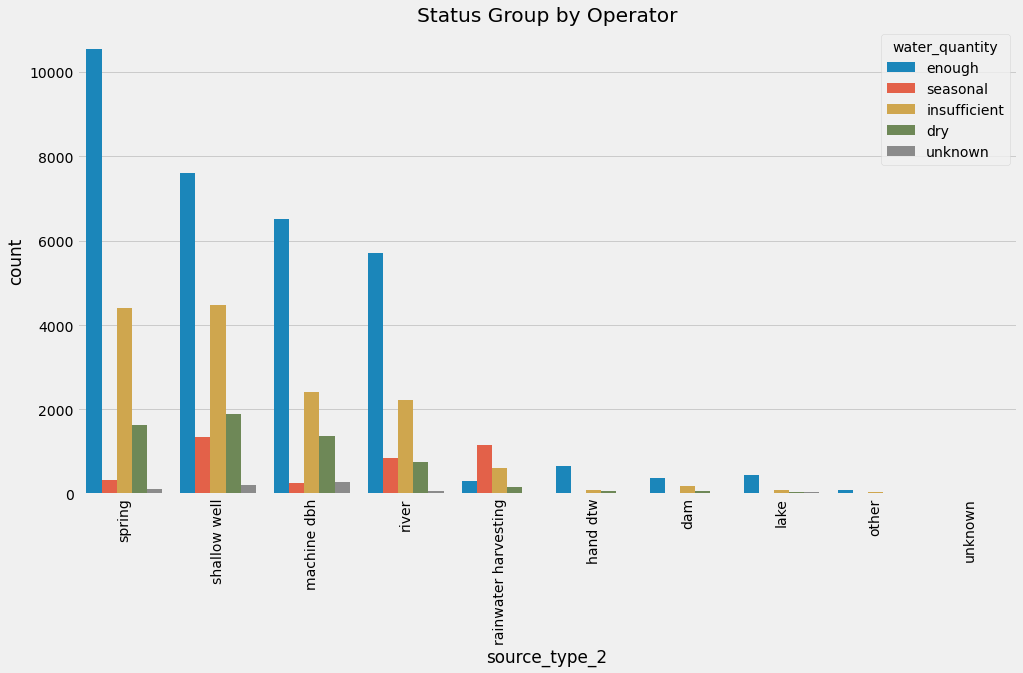

In [600]:
#create a barplot
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.countplot(data=df_explore, x='source_type_2', hue='water_quantity',
                  order=df_explore['source_type_2'].value_counts().index[:50]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Status Group by Operator');

## Size of population left without water (around a non-functional well)

In [601]:
df_explore.loc[df_explore['status_group'] == 'non functional',['population']].sum()

population   6,957,300.0
dtype: float64

# MODELING

As stated before, I will be modeling whether or not a water well is functional or not functional based on characteristics of the well. Since it is more important to identify the water wells that are not functional as opposed to functional, I will be tuning a model to ensure that the it correctly identifies non functional wells even if it means that the model predicts a false positive. Although this will mean more funding and time will be allocated to water well maintenance, it will ensure that the water wells are as reliable as they can be, and subsequently, that the Tanzanian citizens have a reliable water supply.

## Model Preprocessing

I will take 2 major steps in preprocessing my data to prepare for modeling:
1. Scale numerical data
2. Encode categorical data

In [602]:
#training columns
X_train_tf.columns

Index(['id', 'wpt_name', 'waterpoint_type', 'water_quality', 'water_quantity',
       'head', 'source_type_1', 'source_type_2', 'extraction_type_1',
       'extraction_type_2', 'well_elevation', 'population', 'latitude',
       'longitude', 'basin', 'district_code', 'region', 'lga', 'ward',
       'funder', 'installer', 'permit', 'public_meeting', 'scheme_management',
       'management', 'water_cost', 'well_age'],
      dtype='object')

In [603]:
#remove features
X_train_tf.drop(columns=['id','wpt_name'],
                inplace=True)
X_test_tf.drop(columns=['id','wpt_name'], 
               inplace=True)

In [604]:
#create dataframe for decision tree models
X_train_dt = X_train_tf.copy()
X_test_dt = X_test_tf.copy()
print(X_train_dt.shape,X_test_dt.shape)

(40305, 25) (17274, 25)


In [605]:
#separate out categorical and numerical data
cat_cols = X_train_tf.select_dtypes(include='object').columns
num_cols = X_train_tf.select_dtypes(exclude='object').columns
cat_cols

Index(['waterpoint_type', 'water_quality', 'water_quantity', 'source_type_1',
       'source_type_2', 'extraction_type_1', 'extraction_type_2', 'basin',
       'district_code', 'region', 'lga', 'ward', 'funder', 'installer',
       'permit', 'public_meeting', 'scheme_management', 'management',
       'water_cost'],
      dtype='object')

In [606]:
#one hot encode categorical columns 
ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_train_tf[cat_cols])

train_ohe_df = pd.DataFrame(ohe.transform(X_train_tf[cat_cols]),
                            columns=ohe.get_feature_names(cat_cols),
                            index=X_train_tf.index)

test_ohe_df = pd.DataFrame(ohe.transform(X_test_tf[cat_cols]),
                            columns=ohe.get_feature_names(cat_cols),
                            index=X_test_tf.index)

train_ohe_df

waterpoint_type_communal standpipe multiple  waterpoint_type_hand pump  \
54135                                          0.0                        0.0   
48894                                          0.0                        0.0   
42712                                          0.0                        0.0   
13607                                          0.0                        0.0   
32769                                          0.0                        0.0   
...                                            ...                        ...   
9332                                           0.0                        1.0   
14981                                          0.0                        0.0   
58137                                          0.0                        1.0   
48367                                          0.0                        0.0   
20930                                          0.0                        0.0   

       waterpoint_type_improved spring  waterpoint_type_other  \
54135                              0.0                    0.0   
48894                              0.0                    0.0   
42712                              0.0                    0.0   
13607                              0.0                    0.0   
32769                              0.0                    0.0   
...                                ...                    ...   
9332                               0.0                    0.0   
14981                              0.0                    0.0   
58137                              0.0                    0.0   
48367                              0.0                    0.0   
20930                              0.0                    0.0   

       water_quality_fluoride  water_quality_fluoride abandoned  \
54135                     0.0                               0.0   
48894                     0.0                               0.0   
42712                     0.0                               0.0   
13607                     0.0                               0.0   
32769                     0.0                               0.0   
...                       ...                               ...   
9332                      0.0                               0.0   
14981                     0.0                               0.0   
58137                     0.0                               0.0   
48367                     0.0                               0.0   
20930                     0.0                               0.0   

       water_quality_milky  water_quality_salty  \
54135                  0.0                  0.0   
48894                  0.0                  0.0   
42712                  0.0                  0.0   
13607                  0.0                  0.0   
32769                  0.0                  0.0   
...                    ...                  ...   
9332                   0.0                  0.0   
14981                  0.0                  0.0   
58137                  0.0                  0.0   
48367                  0.0                  0.0   
20930                  0.0                  0.0   

       water_quality_salty abandoned  water_quality_soft-good  \
54135                            0.0                      1.0   
48894                            0.0                      1.0   
42712                            0.0                      1.0   
13607                            0.0                      1.0   
32769                            0.0                      1.0   
...                              ...                      ...   
9332                             0.0                      1.0   
14981                            0.0                      1.0   
58137                            0.0                      1.0   
48367                            0.0                      1.0   
20930                            0.0                      1.0   

       water_quality_unknown  water_quantity_enough  \

In [607]:
#scale numeric data
scaler = StandardScaler()
scaler.fit(X_train_tf[num_cols])

train_scale_df = pd.DataFrame(scaler.transform(X_train_tf[num_cols]),
                              columns=num_cols, index=X_train_tf.index)

test_scale_df = pd.DataFrame(scaler.transform(X_test_tf[num_cols]),
                             columns=num_cols, index=X_test_tf.index)

train_scale_df

head       well_elevation           population  \
54135 -0.41240994318969293 -0.03557955693739182  -0.4814323256867438   
48894 -0.41240994318969293     -1.1373533229027 -0.03574711620234145   
42712 -0.41240994318969293   1.3135311768976794 -0.21473716017198097   
13607  -0.2626108655923748   0.4783673892854925 -0.37582819974465653   
32769 -0.41240994318969293  -1.1325350702818606   0.0537479057824783   
...                    ...                  ...                  ...   
9332     2.583571608756671  -1.1357472386957534  -0.4814323256867438   
14981 -0.41240994318969293  0.41251793680068544 -0.26843417336287284   
58137 -0.41240994318969293   0.7497956202594532   0.7518090772640724   
48367  -0.2626108655923748   1.2011052824114237   0.2774854607445277   
20930 -0.41240994318969293   0.7562199570872393  0.15219242996578003   

                 latitude            longitude            well_age  
54135  0.5080443736149773   1.2224059569052224 -0.6592033403756834  
48894  0.8715122209647588 -0.40390143154765445 0.05875999834584862  
42712  0.9255987412223705   0.5697573371905228  0.5374022241602033  
13607 -1.1438925195428296  0.03299009771714374  0.8564970413697731  
32769  1.1886548079439385  -1.6478009813154797 -0.9782981575852532  
...                   ...                  ...                 ...  
9332  -0.8834224011290683   0.5843539499924211 -0.1805611145613287  
14981 -1.0075627026806246 -0.15004401274859777  1.3351392671841278  
58137  0.5178548639578999  -0.2775675466498335 -0.8187507489804683  
48367  0.4849906473647923  0.11111856129547441  -1.137845566190038  
20930  0.6004609888948351  -0.1960033887039784 -0.8187507489804683  

[40305 rows x 6 columns]

In [608]:
#review scaling of numeric features
train_scale_df.describe()

head         well_elevation             population  \
count              40,305.0               40,305.0               40,305.0   
mean  4.372028246334322e-17 -5.288743846372164e-17 2.8206633847318206e-18   
std      1.0000124056396043     1.0000124056396043     1.0000124056396043   
min    -0.41240994318969293    -1.7428470689215356    -0.4832222261264402   
25%    -0.41240994318969293    -1.0185030915886581   -0.43847471513403036   
50%    -0.41240994318969293    0.24709126348519456   -0.21473716017198097   
75%    -0.11281178799505658     0.7947659780539557    0.07164691017944226   
max       6.328548548689626      2.850553762945493     54.108741184613606   

                   latitude              longitude              well_age  
count              40,305.0               40,305.0              40,305.0  
mean  8.796943931132366e-17 -7.693359381856041e-16 5.359260430990459e-17  
std      1.0000124056396043     1.0000124056396043    1.0000124056396043  
min      -2.032104247733685     -2.124292595929056    -1.297392974794823  
25%     -0.9796281121800893    -0.7171609381929472   -0.8985244532828607  
50%       0.261577389801413   -0.05421430841776053   -0.2603348188637212  
75%      0.8888573114261233     0.8035495356518143    0.7767233370673806  
max      1.7303371142950548     1.9900220892559948    2.9306133532319767

In [609]:
#concat num and cat
X_train_tf = pd.concat([train_ohe_df,train_scale_df],axis=1)
X_test_tf = pd.concat([test_ohe_df,test_scale_df],axis=1)

In [610]:
#review dataframe
X_train_tf

waterpoint_type_communal standpipe multiple  waterpoint_type_hand pump  \
54135                                          0.0                        0.0   
48894                                          0.0                        0.0   
42712                                          0.0                        0.0   
13607                                          0.0                        0.0   
32769                                          0.0                        0.0   
...                                            ...                        ...   
9332                                           0.0                        1.0   
14981                                          0.0                        0.0   
58137                                          0.0                        1.0   
48367                                          0.0                        0.0   
20930                                          0.0                        0.0   

       waterpoint_type_improved spring  waterpoint_type_other  \
54135                              0.0                    0.0   
48894                              0.0                    0.0   
42712                              0.0                    0.0   
13607                              0.0                    0.0   
32769                              0.0                    0.0   
...                                ...                    ...   
9332                               0.0                    0.0   
14981                              0.0                    0.0   
58137                              0.0                    0.0   
48367                              0.0                    0.0   
20930                              0.0                    0.0   

       water_quality_fluoride  water_quality_fluoride abandoned  \
54135                     0.0                               0.0   
48894                     0.0                               0.0   
42712                     0.0                               0.0   
13607                     0.0                               0.0   
32769                     0.0                               0.0   
...                       ...                               ...   
9332                      0.0                               0.0   
14981                     0.0                               0.0   
58137                     0.0                               0.0   
48367                     0.0                               0.0   
20930                     0.0                               0.0   

       water_quality_milky  water_quality_salty  \
54135                  0.0                  0.0   
48894                  0.0                  0.0   
42712                  0.0                  0.0   
13607                  0.0                  0.0   
32769                  0.0                  0.0   
...                    ...                  ...   
9332                   0.0                  0.0   
14981                  0.0                  0.0   
58137                  0.0                  0.0   
48367                  0.0                  0.0   
20930                  0.0                  0.0   

       water_quality_salty abandoned  water_quality_soft-good  \
54135                            0.0                      1.0   
48894                            0.0                      1.0   
42712                            0.0                      1.0   
13607                            0.0                      1.0   
32769                            0.0                      1.0   
...                              ...                      ...   
9332                             0.0                      1.0   
14981                            0.0                      1.0   
58137                            0.0                      1.0   
48367                            0.0                      1.0   
20930                            0.0                      1.0   

       water_quality_unknown  water_quantity_enough  \

## Dummy Classifier

The dummy model will predict the exact same distribution for the target variable, `status_group`, as is in the data. This model will be equivalent to randomly guessing and will be a good baseline to evaluate other models against.

### Model Creation

In [611]:
#current class values
y_train.value_counts(normalize=True)

0   0.5443989579456643
1   0.4556010420543357
Name: status_group, dtype: float64

In [612]:
#create dummy classifier model as a baseline
dummy = DummyClassifier()
#fit the dummy model
dummy.fit(X_train_tf,y_train)

DummyClassifier()

### Model Evaluation

CURRENT MODEL: Not Overfit (Recall)


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      9443
           1       0.45      0.46      0.45      7831

    accuracy                           0.50     17274
   macro avg       0.50      0.50      0.50     17274
weighted avg       0.50      0.50      0.50     17274

Test Graphs------------------------------------------------------


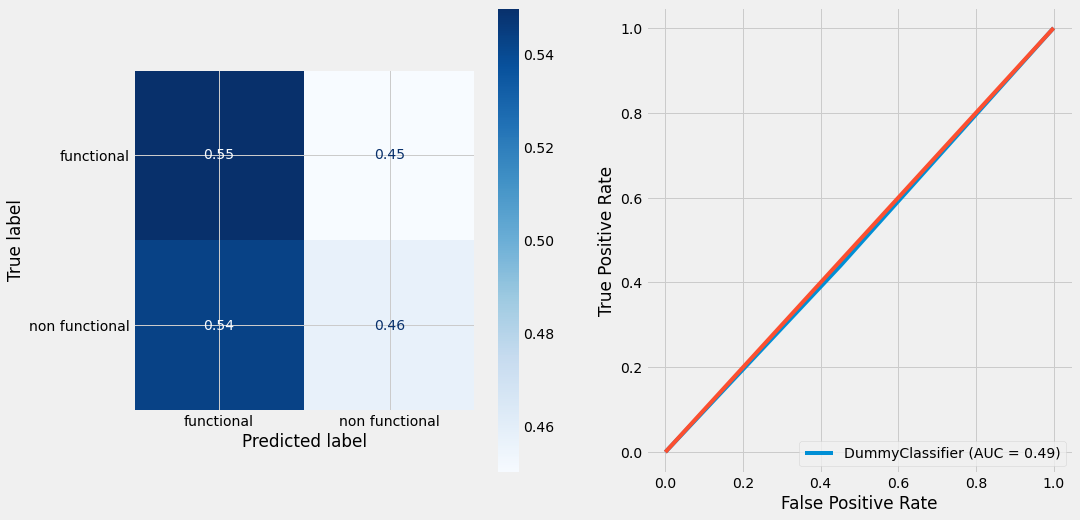

In [613]:
#eval model
model_eval(dummy, X_train_tf, y_train, X_test_tf, y_test)

## Feature Selection (Model Agnostic-Filter Methods)

In this section I will be removing features based solely on the characteristics of the data and therefore, will be model agnostic. Removing features using filter methods eliminates features which are constant, almost constant or duplicated and will not add value to any model. Also, the lower the number of features, the less cost in computational time and hardware requirements.

In [614]:
print(X_train_tf.shape,X_test_tf.shape)

(40305, 465) (17274, 465)


In [615]:
#remove constant features
sel_const = DropConstantFeatures(tol=1, missing_values='raise')
#fit the model
sel_const.fit(X_train_tf)

DropConstantFeatures(variables=['waterpoint_type_communal standpipe multiple',
                                'waterpoint_type_hand pump',
                                'waterpoint_type_improved spring',
                                'waterpoint_type_other',
                                'water_quality_fluoride',
                                'water_quality_fluoride abandoned',
                                'water_quality_milky', 'water_quality_salty',
                                'water_quality_salty abandoned',
                                'water_quality_soft-good',
                                'water_quality_unknown',
                                'water...
                                'source_type_1_unknown',
                                'source_type_2_hand dtw', 'source_type_2_lake',
                                'source_type_2_machine dbh',
                                'source_type_2_other',
                                'source_type_2_rainwater

In [616]:
#number of constant features
len(sel_const.features_to_drop_)

0

> **OBSERVATIONS**
> - No constant features to remove

In [617]:
#remove quasi-constant features
quasi_const = DropConstantFeatures(tol=0.998, missing_values='raise')
#fit the model
quasi_const.fit(X_train_tf)

DropConstantFeatures(tol=0.998,
                     variables=['waterpoint_type_communal standpipe multiple',
                                'waterpoint_type_hand pump',
                                'waterpoint_type_improved spring',
                                'waterpoint_type_other',
                                'water_quality_fluoride',
                                'water_quality_fluoride abandoned',
                                'water_quality_milky', 'water_quality_salty',
                                'water_quality_salty abandoned',
                                'water_quality_soft-good',
                                'water_quality_unkno...
                                'source_type_1_unknown',
                                'source_type_2_hand dtw', 'source_type_2_lake',
                                'source_type_2_machine dbh',
                                'source_type_2_other',
                                'source_type_2_rainwater harvesting

In [618]:
#number of constant features
len(quasi_const.features_to_drop_)

194

In [619]:
#example of a quasi-constant
quasi_ex = quasi_const.features_to_drop_[0]
X_train_tf[quasi_ex].value_counts(normalize=True)

0.0       0.9997270810073192
1.0   0.00027291899268080884
Name: water_quality_fluoride abandoned, dtype: float64

In [620]:
#shape of dataframes before
X_train_tf.shape, X_test_tf.shape

((40305, 465), (17274, 465))

In [621]:
#drop quasi-constants from train and test
X_train_tf = quasi_const.transform(X_train_tf)
X_test_tf = quasi_const.transform(X_test_tf)

In [622]:
#shape of dataframes after
X_train_tf.shape, X_test_tf.shape

((40305, 271), (17274, 271))

In [623]:
#remove duplicate features
dup = DropDuplicateFeatures(missing_values='raise')
#fit the model
dup.fit(X_train_tf)

DropDuplicateFeatures(missing_values='raise',
                      variables=['waterpoint_type_communal standpipe multiple',
                                 'waterpoint_type_hand pump',
                                 'waterpoint_type_improved spring',
                                 'waterpoint_type_other',
                                 'water_quality_fluoride',
                                 'water_quality_milky', 'water_quality_salty',
                                 'water_quality_salty abandoned',
                                 'water_quality_soft-good',
                                 'water_quality_unknown',
                                 'water_quantity_...
                                 'source_type_2_hand dtw', 'source_type_2_lake',
                                 'source_type_2_machine dbh',
                                 'source_type_2_other',
                                 'source_type_2_rainwater harvesting',
                                 'source_

In [624]:
#duplicated features
dup.duplicated_feature_sets_

[{'extraction_type_1_other', 'extraction_type_2_other'},
 {'extraction_type_1_rope pump', 'extraction_type_2_rope pump'}]

In [625]:
#simple check for duplicates between district 13 and lga=kilwa
df_clean.loc[df_clean['district_code'] == 13,['lga']].value_counts()

lga  
Kilwa    391
dtype: int64

In [626]:
#drop duplicate features
X_train_tf = dup.transform(X_train_tf)
X_test_tf = dup.transform(X_test_tf)

In [627]:
#shape of dataframes after
X_train_tf.shape, X_test_tf.shape

((40305, 269), (17274, 269))

## Logistic Regression

Logistic Regression will be my first model to classify water well failure. I will begin with a vanilla model before making improvements by evaluating hyperparameter tuning, class imbalances and feature selection.

In [628]:
#create copy of training and test set for logistic regression
X_train_lr = X_train_tf.copy()
X_test_lr = X_test_tf.copy()
X_train_lr.shape, X_test_tf.shape

((40305, 269), (17274, 269))

### Model Assumptions

#### Linearity with Target

In [629]:
#plot numerical features against the target
# num_cols = df_explore_binary.drop(columns='status_group').select_dtypes(exclude='object').columns

# for col in num_cols:
#     sns.lmplot(data=df_explore_binary, x=col,y='status_group')

>**OBSERVATIONS**
> - The features seem to have a linear relationship with the target

#### Multicollinearity

<AxesSubplot:>

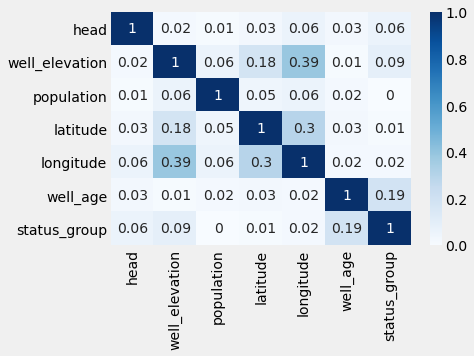

In [630]:
sns.heatmap(df_explore_binary.corr().abs().round(2),annot=True, cmap='Blues')

>**OBSERVATIONS**
> - no high correlations observed

In [631]:
#remove construction year from X_train and X_test
# X_train_lr.drop(columns='construction_year', inplace=True)
# X_test_lr.drop(columns='construction_year', inplace=True)

### Model #1

In [632]:
#create a logistic regression model
lr_1 = LogisticRegression(C=1e12, max_iter=2500, n_jobs=-1)
#fit the model to the training data
lr_1.fit(X_train_lr, y_train)

LogisticRegression(C=1000000000000.0, max_iter=2500, n_jobs=-1)

### Model Evaluation

Need to get:
- confusion matrix
- train score vs test score (< .05)

MODEL EVAL VS PREVIOUS (TEST)


Previous Model Current Model Delta
Recall             0.45          0.69  0.24
F1                 0.46          0.73  0.27
Accuracy            0.5          0.77  0.27
AUC                 0.5          0.85  0.35



CURRENT MODEL: Not Overfit (Recall)


Recall on Training: 0.68
Recall on Test: 0.69


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      9443
           1       0.79      0.69      0.73      7831

    accuracy                           0.77     17274
   macro avg       0.78      0.77      0.77     17274
weighted avg       0.77      0.77      0.77     17274

Test Graphs------------------------------------------------------


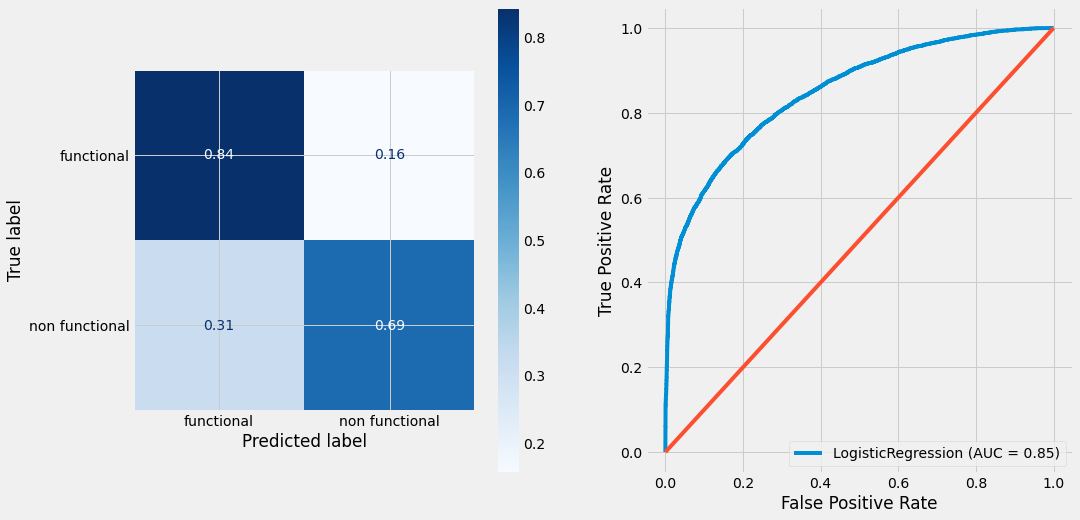

PREVIOUS MODEL


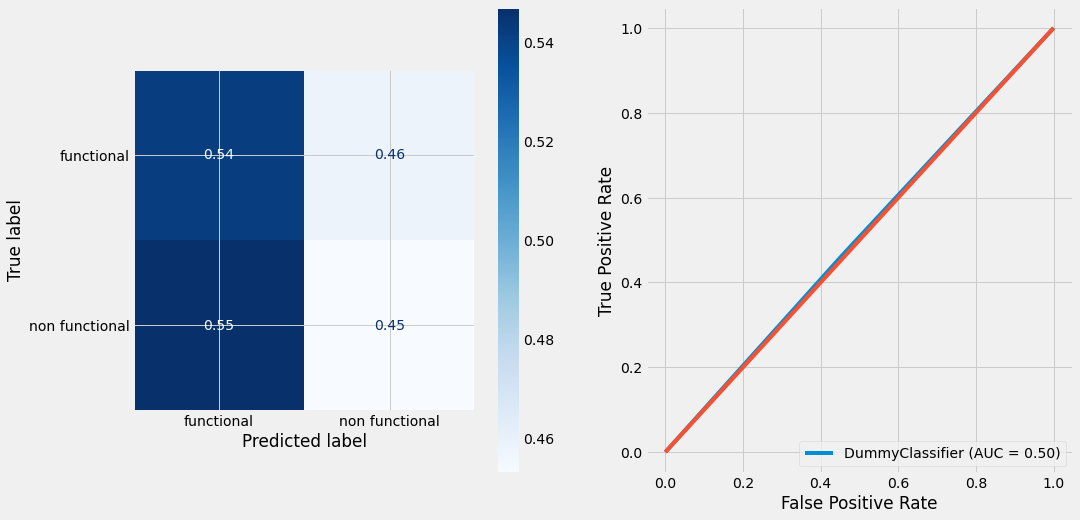

<Figure size 432x288 with 0 Axes>

In [633]:
#eval model
model_eval(lr_1, X_train_lr, y_train, X_test_lr, y_test, prev_model=dummy)

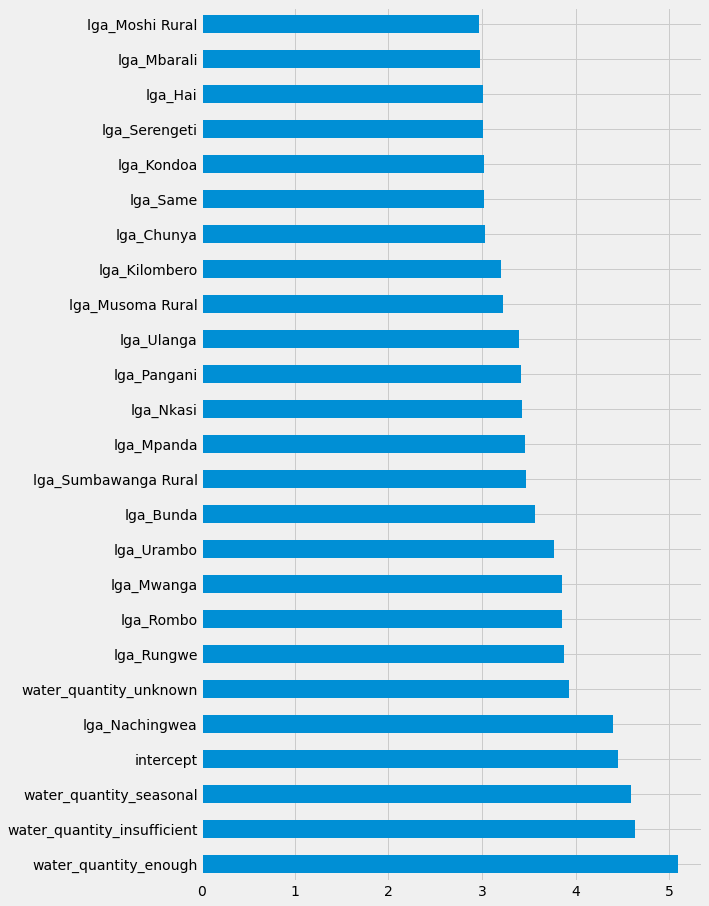

In [634]:
#plot top coefficients
fig = plt.subplots(figsize=(8,15))
get_coefficients(lr_1,X_train_lr).abs().sort_values(ascending=False)[:25].plot.barh();

> **OBSERVATIONS**
> - LR model accuracy improved on f1 by 30% and recall by 25%
> - model is not overfit as it pertains to recall

> **ACTIONS**
> - Find the best parameters using gridsearch

### Model #2

Use gridsearch to identify the optimal parameters for getting the best score for recall.

In [635]:
#create new lr model
lr_2 = LogisticRegression()

In [636]:
#set up parameters to iterate on
params_2 = {'C': [1e7, 1e8, 1e9, 1e10],
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear']}

In [637]:
#perform a gridsearchCV in order to find the best parameters
lr_2_gridsearch = GridSearchCV(lr_2, params_2,scoring='recall',n_jobs=-1, cv=5)
lr_2_gridsearch.fit(X_train_lr, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [10000000.0, 100000000.0, 1000000000.0,
                               10000000000.0],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='recall')

### Model Evaluation

In [638]:
#get best parameters from gridsearch
lr_2_gridsearch.best_params_

{'C': 10000000.0, 'penalty': 'l2', 'solver': 'liblinear'}

In [639]:
#get best coeffs
lr_2_gridsearch.best_estimator_.coef_

array([[ 7.03915366e-01, -3.64839127e-02, -1.09843308e+00,
         1.34686688e+00, -5.88931025e-01, -6.70100558e-01,
         8.85206195e-03,  5.10264066e-01,  3.64810363e-02,
         7.66484851e-01, -5.09820081e+00, -4.62999802e+00,
        -4.58784252e+00, -3.92515176e+00,  6.25255877e-01,
         4.37692760e-01,  1.15588774e+00,  6.36147661e-01,
         9.01728213e-01, -5.12213758e-01, -8.48353498e-01,
         9.71053386e-02,  9.66044959e-01,  3.56706427e-01,
        -4.91761912e-01, -2.14459342e-01,  2.88671569e-01,
        -6.74667606e-01, -1.29444930e-02, -6.04602788e-01,
        -4.60924518e-01, -4.92920249e-01,  6.00790238e-01,
        -4.23363952e-02, -9.98894231e-01, -6.13734731e-01,
        -4.26254792e-01,  4.04664151e-02,  7.62066855e-02,
         8.02333773e-02, -2.39113405e-01,  3.64681626e-01,
         2.64531794e-01,  2.10567342e-01,  9.72436175e-01,
         1.83708184e-01, -4.98955629e-01, -1.54341094e-01,
        -6.59719034e-01, -4.55995800e-01,  8.28544652e-0

MODEL EVAL VS PREVIOUS (TEST)


Previous Model Current Model Delta
Recall             0.69          0.69   0.0
F1                 0.73          0.73   0.0
Accuracy           0.77          0.77   0.0
AUC                0.85          0.85   0.0



CURRENT MODEL: Not Overfit (Recall)


Recall on Training: 0.68
Recall on Test: 0.69


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      9443
           1       0.79      0.69      0.73      7831

    accuracy                           0.77     17274
   macro avg       0.78      0.77      0.77     17274
weighted avg       0.77      0.77      0.77     17274

Test Graphs------------------------------------------------------


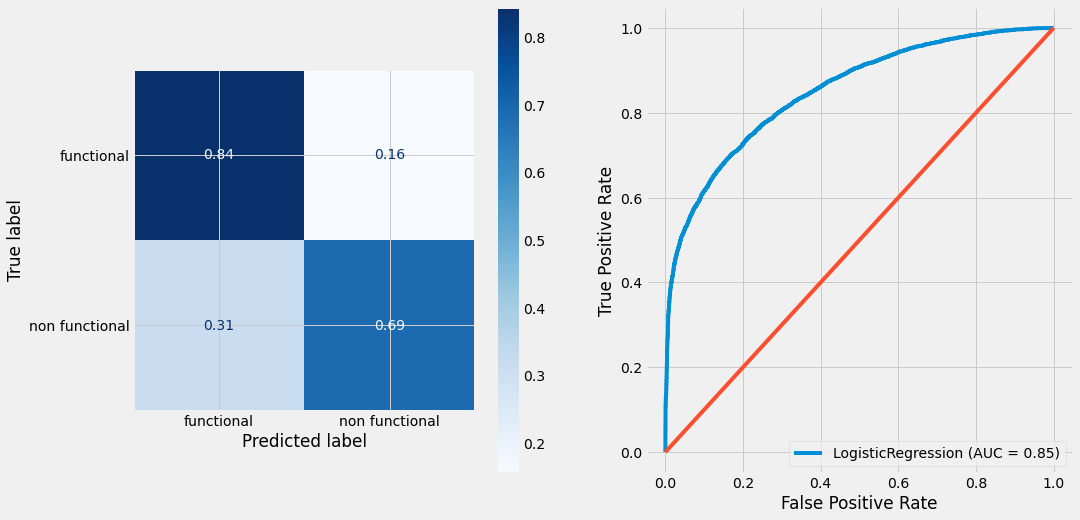

PREVIOUS MODEL


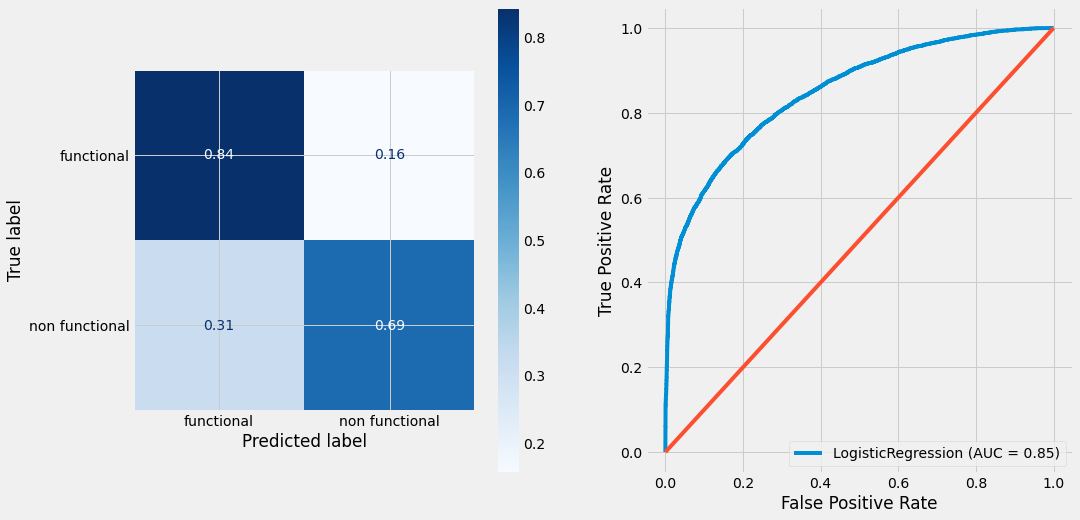

<Figure size 432x288 with 0 Axes>

In [640]:
#eval the best estimator from gridsearch
model_eval(lr_2_gridsearch.best_estimator_, X_train_lr, y_train, X_test_lr, 
           y_test, prev_model=lr_1)

> **OBSERVATIONS**
> - gridsearching through different C values, penalties and solvers gave the exact same score as a vanilla logistic regression model. 
> - best model for optimizing recall used a penalty of ridge regularization(l2), the liblinear solver and a C value of 1e8.

> **ACTIONS**
> - see if fixing class imbalance will help the model

### Model #3

I will run a gridsearch while making the target classes balanced to see if there is any improvement.

In [641]:
#create new lr model with target class balanced
lr_3 = LogisticRegression(class_weight='balanced')

In [642]:
#set up parameters to iterate on
params_3 = {'C': [1e7, 1e8, 1e9, 1e10],
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear']}

In [643]:
#perform a gridsearchCV in order to find the best parameters
lr_3_gridsearch = GridSearchCV(lr_3, params_3,scoring='recall',n_jobs=-1, cv=5)
lr_3_gridsearch.fit(X_train_lr, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': [10000000.0, 100000000.0, 1000000000.0,
                               10000000000.0],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='recall')

### Model Evaluation

In [644]:
#get best parameters from gridsearch
lr_3_gridsearch.best_params_

{'C': 10000000.0, 'penalty': 'l1', 'solver': 'liblinear'}

MODEL EVAL VS PREVIOUS (TEST)


Previous Model Current Model Delta
Recall             0.69          0.72  0.03
F1                 0.73          0.74  0.01
Accuracy           0.77          0.77   0.0
AUC                0.85          0.85   0.0



CURRENT MODEL: Not Overfit (Recall)


Recall on Training: 0.72
Recall on Test: 0.72


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      9443
           1       0.75      0.72      0.74      7831

    accuracy                           0.77     17274
   macro avg       0.76      0.76      0.76     17274
weighted avg       0.77      0.77      0.77     17274

Test Graphs------------------------------------------------------


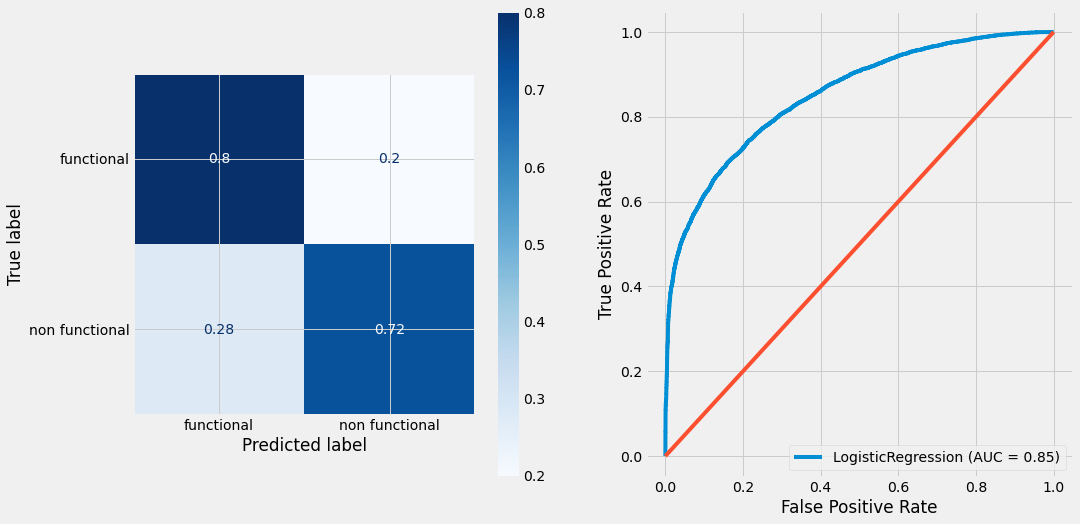

PREVIOUS MODEL


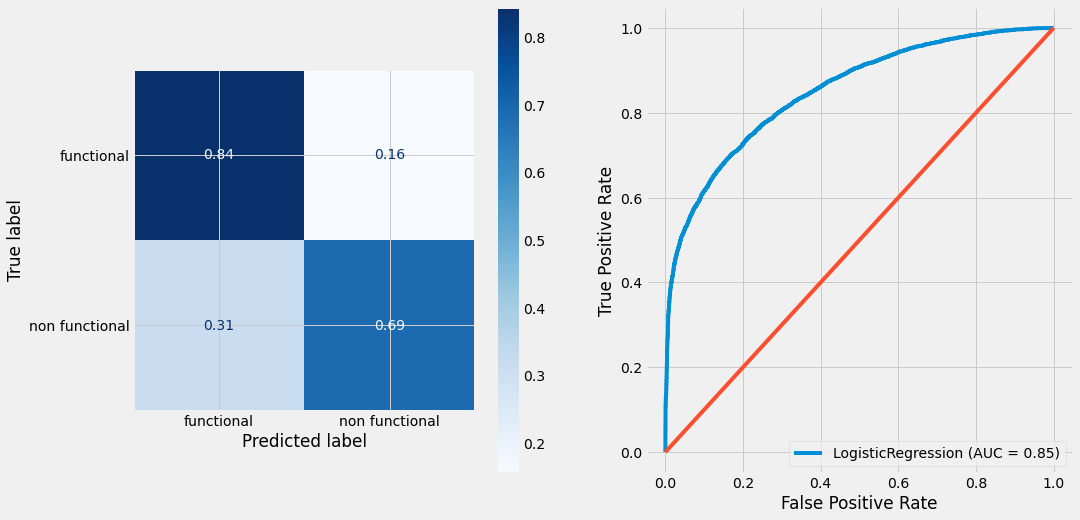

<Figure size 432x288 with 0 Axes>

In [645]:
#eval the best estimator from gridsearch
model_eval(lr_3_gridsearch.best_estimator_, X_train_lr, y_train, X_test_lr, 
           y_test, prev_model=lr_2_gridsearch.best_estimator_)

> **OBSERVATIONS**
> - Balancing the classes improved the model by increasing the recall score by 4% and the f1 by 1%

> **ACTIONS**
> - Eval feature selection

### Model #4

For this model I will utilize feature selection in order to drop additional features based on lasso regularization. I will vary the penalty of the regularization and evaluate the models. The goal is to select the least amount of features without drastically hurting the model.

In [646]:
#use embedded methods for feature selection
lr_4 = LogisticRegression(C=10, penalty='l1',solver='liblinear')
sel_features = SelectFromModel(lr_4)
#fit the model
sel_features.fit(X_train_lr, y_train)

SelectFromModel(estimator=LogisticRegression(C=10, penalty='l1',
                                             solver='liblinear'))

In [647]:
#previous dataframe shape
X_train_lr.shape, X_test_lr.shape

((40305, 269), (17274, 269))

In [648]:
#get number of features to keep
selected_feat = X_train_lr.columns[sel_features.get_support()]
print(f'Number of features selected to keep: {len(selected_feat)}')

Number of features selected to keep: 259


In [649]:
#get selected features to remove
len(sel_features.get_support())
print(f'Number of features shrank to 0: {(sel_features.estimator_.coef_ == 0).sum()}')

Number of features shrank to 0: 10


In [650]:
#create updated dataframes for train and test
X_train_lr_fs = sel_features.transform(X_train_lr)
X_test_lr_fs = sel_features.transform(X_test_lr)

In [651]:
#see shape of current dataframe
X_train_lr_fs.shape, X_test_lr_fs.shape

((40305, 259), (17274, 259))

In [652]:
#set up parameters to iterate on
params_4 = {'C': [10],
          'penalty': ['l1'],
          'solver': ['liblinear']}

In [653]:
#perform a gridsearchCV in order to find the best parameters
lr_4_gridsearch = GridSearchCV(lr_4, params_4,scoring='recall',n_jobs=-1, cv=5)
lr_4_gridsearch.fit(X_train_lr_fs, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(C=10, penalty='l1',
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [10], 'penalty': ['l1'], 'solver': ['liblinear']},
             scoring='recall')

### Model Evaluation

MODEL EVAL VS PREVIOUS (TEST)


Previous Model Current Model Delta
Recall             0.72          0.69 -0.03
F1                 0.74          0.73 -0.01
Accuracy           0.77          0.77   0.0
AUC                0.85          0.85   0.0



CURRENT MODEL: Not Overfit (Recall)


Recall on Training: 0.68
Recall on Test: 0.69


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      9443
           1       0.79      0.69      0.73      7831

    accuracy                           0.77     17274
   macro avg       0.78      0.77      0.77     17274
weighted avg       0.77      0.77      0.77     17274

Test Graphs------------------------------------------------------


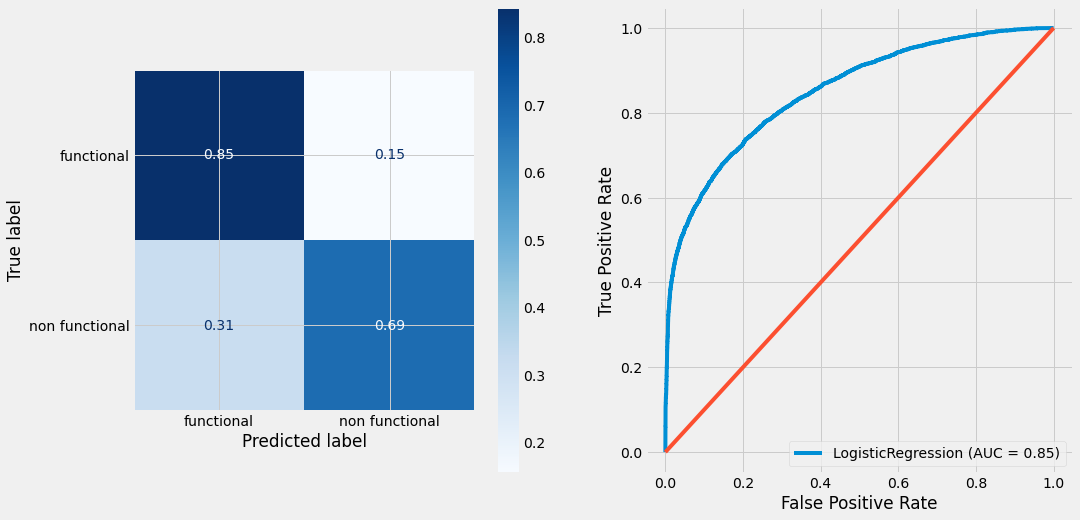

PREVIOUS MODEL


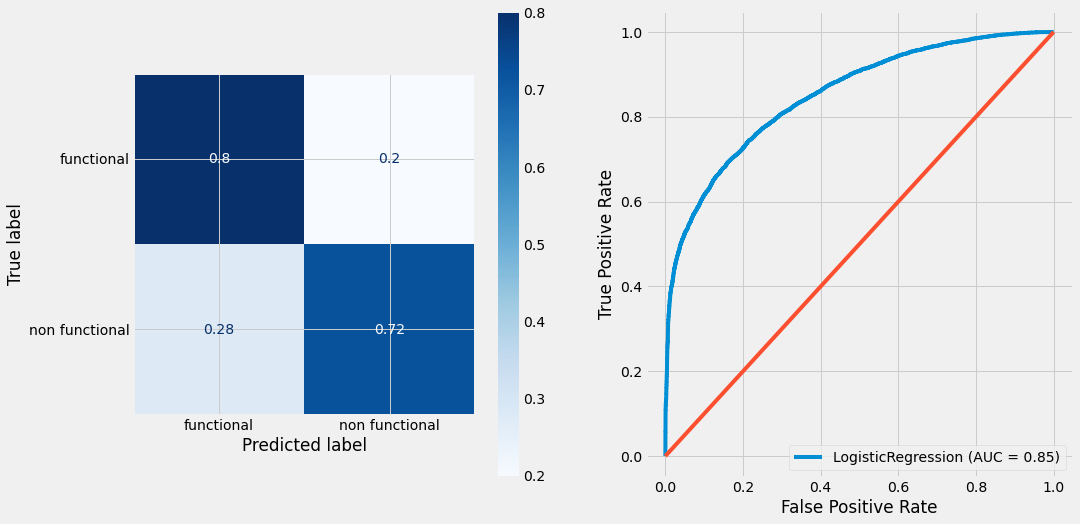

<Figure size 432x288 with 0 Axes>

In [654]:
#eval the new model
model_eval(lr_4_gridsearch.best_estimator_, X_train_lr_fs, y_train, 
           X_test_lr_fs, y_test, prev_model=lr_3_gridsearch.best_estimator_,
          prev_X_train=X_train_lr, prev_y_train=y_train, prev_X_test=X_test_lr, 
           prev_y_test=y_test)

> **OBSERVATIONS**
> - The new model remove features through lasso regularization, however, the model recall takes a 5% hit. I believe the best Logistic Regression model is Model 3:
>  - class balanced
>  - C = 1e8 
>  - penalty = l2
>  - solver = liblinear
> - **Recall = .72, F1 = .74**

> **ACTIONS**
> - Look at most valuable coefficients for the model

In [655]:
#find top coefficients
best_coeffs = get_coefficients(lr_3_gridsearch.best_estimator_,X_train_lr)
best_coeffs_pos = best_coeffs.loc[best_coeffs >= 0].sort_values(ascending=False)
best_coeffs_neg = best_coeffs.loc[best_coeffs < 0].sort_values(ascending=True)
best_coeffs_overall = best_coeffs.abs().sort_values(ascending=False)

<AxesSubplot:>

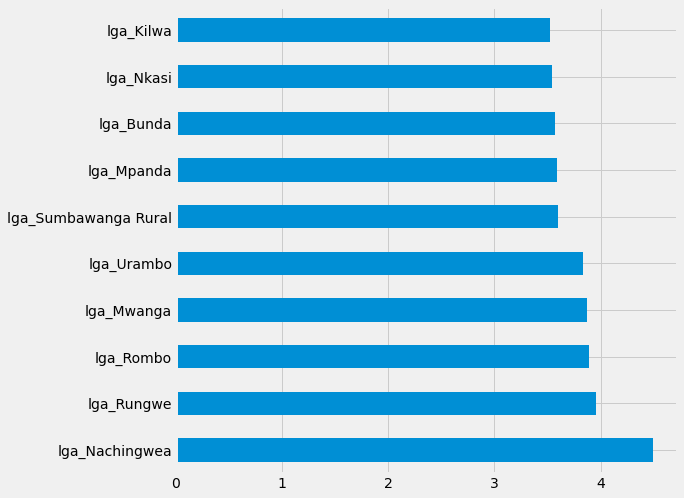

In [656]:
#top 10 positive coeffs
fig = plt.subplots(figsize=(8,8))
best_coeffs_pos[:10].plot.barh()

> **OBSERVATIONS**
> - The top coefficients which predict the target (non functional water well) most strongly are various local government authorities. There might be a strong correlation between how these lga's govern the water wells in this area that make them less reliable.

<AxesSubplot:>

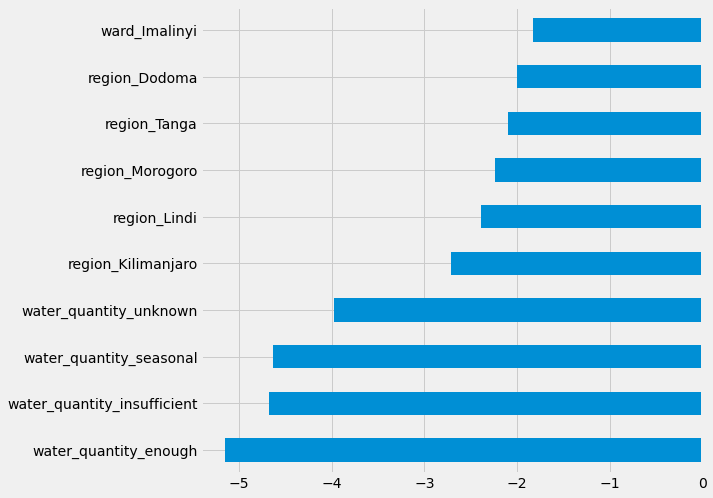

In [657]:
#top 10 negative coeffs
fig = plt.subplots(figsize=(8,8))
best_coeffs_neg[:10].plot.barh()

> **OBSERVATIONS**
> - The top coefficients which correlate negatively with predicting the target (non functional water well) are from the `water_quantity` feature. While it does make sense that having enough water does accurately predict if the well is functional (opposite of non functional), it is strange to see that having an insufficient water supply is also a good predictor of if the well is functional.

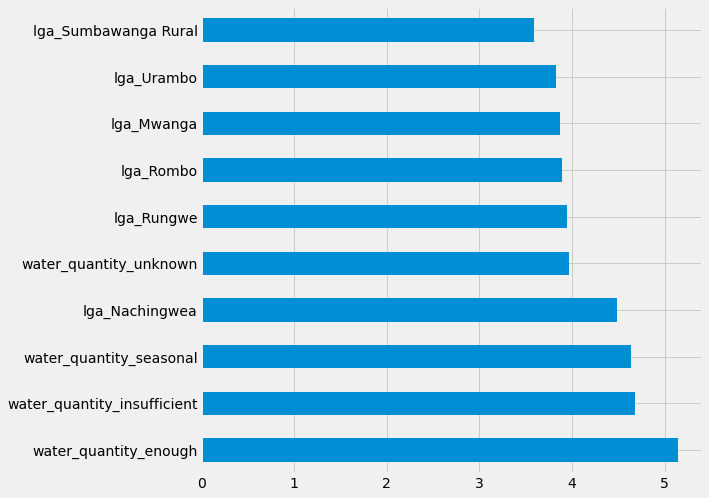

In [658]:
#top 10 coeffs overall
fig = plt.subplots(figsize=(8,8))
best_coeffs_overall[:10].plot.barh();

> **OBSERVATIONS**
> - The top features for making predictions overall remain the water quantity followed by the local government authorities.

<AxesSubplot:xlabel='well_age', ylabel='head'>

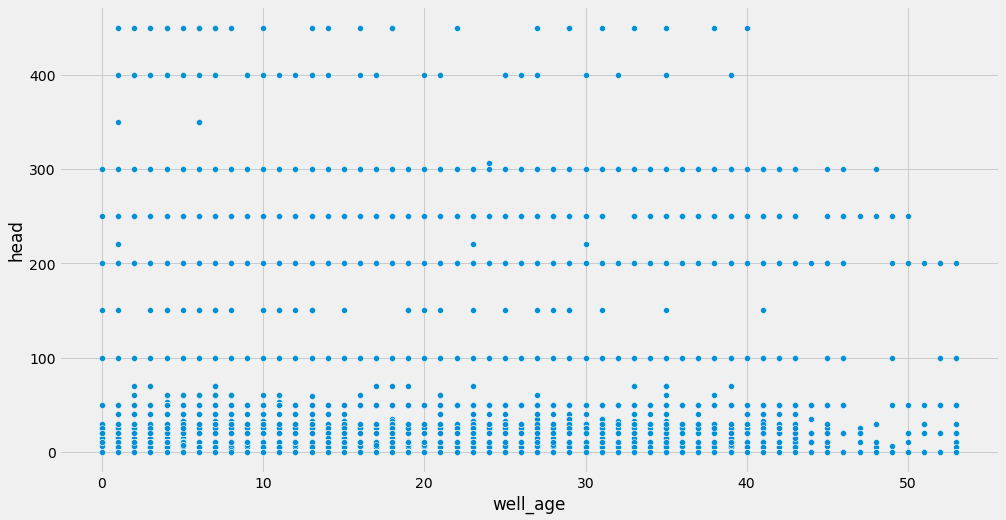

In [659]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df_explore, x='well_age',y='head')

## Random Forrest

I now want to explore if a Random Forest classification model will perform better than the best logistic regression model I found.

In [660]:
#review training dataframe
X_train_dt

waterpoint_type water_quality water_quantity  head source_type_1  \
54135  communal standpipe     soft-good         enough   0.0   groundwater   
48894  communal standpipe     soft-good       seasonal   0.0       surface   
42712  communal standpipe     soft-good   insufficient   0.0   groundwater   
13607  communal standpipe     soft-good         enough  10.0       surface   
32769  communal standpipe     soft-good         enough   0.0   groundwater   
...                   ...           ...            ...   ...           ...   
9332            hand pump     soft-good   insufficient 200.0   groundwater   
14981  communal standpipe     soft-good         enough   0.0       surface   
58137           hand pump     soft-good         enough   0.0   groundwater   
48367  communal standpipe     soft-good   insufficient  10.0   groundwater   
20930  communal standpipe     soft-good       seasonal   0.0       surface   

              source_type_2 extraction_type_1 extraction_type_2  \
54135                spring           gravity           gravity   
48894  rainwater harvesting           gravity           gravity   
42712                spring           gravity           gravity   
13607                 river           gravity           gravity   
32769                spring           gravity           gravity   
...                     ...               ...               ...   
9332           shallow well          handpump            swn 80   
14981                 river           gravity           gravity   
58137           machine dbh          handpump           afridev   
48367                spring           gravity           gravity   
20930  rainwater harvesting           gravity           gravity   

       well_elevation  population    latitude   longitude          basin  \
54135           973.0         1.0  -4.4381008  38.3417691        Pangani   
48894           287.0       250.0 -3.41527115 34.09722151       Internal   
42712         1,813.0       150.0 -3.26306705 36.63840223        Pangani   
13607         1,293.0        60.0 -9.08679269 35.23747759         Rufiji   
32769           290.0       300.0 -2.52280475 30.85073141  Lake Victoria   
...               ...         ...         ...         ...            ...   
9332            288.0         1.0 -8.35380747 36.67649836         Rufiji   
14981         1,252.0       120.0 -8.70314891 34.75977147         Rufiji   
58137         1,462.0       690.0 -4.41049324 34.42694404       Internal   
48367         1,743.0       425.0 -4.50297596 35.44138737       Internal   
20930         1,466.0       355.0 -4.17803253 34.63982074       Internal   

      district_code     region           lga      ward  \
54135             1      Tanga       Lushoto      Rare   
48894             2  Shinyanga         Maswa      Rare   
42712             2     Arusha  Arusha Rural  Olkokola   
13607             4     Iringa        Njombe      Rare   
32769            30     Kagera         Ngara    Rusumo   
...             ...        ...           ...       ...   
9332              4   Morogoro        Ulanga      Rare   
14981             4     Iringa        Njombe      Rare   
58137             1    Singida        Iramba      Rare   
48367             2    Manyara          Rare      Rare   
20930             1    Singida        Iramba      Rare   

                       funder installer permit public_meeting  \
54135  Government Of Tanzania       DWE   True           True   
48894                    Rare      Rare  False           True   
42712            World Vision       DWE   True           True   
13607                    Rare      Rare   True           True   
32769                    Rare      Rare  False           True   
...                       ...       ...    ...            ...   
9332                    Tasaf       DWE   True           True   
14981                  Unicef       DWE  False           True   
58137            World Vision      Rare   True           True   
48367   

> **OBSERVATIONS**
> - Need to encode categorical labels

### Model Preprocessing

In [661]:
#encode the categorical features
X_train_dt = pd.get_dummies(X_train_dt)
X_test_dt = pd.get_dummies(X_test_dt)
# X_train_dt.drop(columns=['construction_year'], inplace=True)
# X_test_dt.drop(columns=['construction_year'], inplace=True)
X_train_dt

head  well_elevation  population    latitude   longitude  well_age  \
54135   0.0           973.0         1.0  -4.4381008  38.3417691       8.0   
48894   0.0           287.0       250.0 -3.41527115 34.09722151      17.0   
42712   0.0         1,813.0       150.0 -3.26306705 36.63840223      23.0   
13607  10.0         1,293.0        60.0 -9.08679269 35.23747759      27.0   
32769   0.0           290.0       300.0 -2.52280475 30.85073141       4.0   
...     ...             ...         ...         ...         ...       ...   
9332  200.0           288.0         1.0 -8.35380747 36.67649836      14.0   
14981   0.0         1,252.0       120.0 -8.70314891 34.75977147      33.0   
58137   0.0         1,462.0       690.0 -4.41049324 34.42694404       6.0   
48367  10.0         1,743.0       425.0 -4.50297596 35.44138737       2.0   
20930   0.0         1,466.0       355.0 -4.17803253 34.63982074       6.0   

       waterpoint_type_communal standpipe  \
54135                                   1   
48894                                   1   
42712                                   1   
13607                                   1   
32769                                   1   
...                                   ...   
9332                                    0   
14981                                   1   
58137                                   0   
48367                                   1   
20930                                   1   

       waterpoint_type_communal standpipe multiple  waterpoint_type_hand pump  \
54135                                            0                          0   
48894                                            0                          0   
42712                                            0                          0   
13607                                            0                          0   
32769                                            0                          0   
...                                            ...                        ...   
9332                                             0                          1   
14981                                            0                          0   
58137                                            0                          1   
48367                                            0                          0   
20930                                            0                          0   

       waterpoint_type_improved spring  waterpoint_type_other  \
54135                                0                      0   
48894                                0                      0   
42712                                0                      0   
13607                                0                      0   
32769                                0                      0   
...                                ...                    ...   
9332                                 0                      0   
14981                                0                      0   
58137                                0                      0   
48367                                0                      0   
20930                                0                      0   

       water_quality_coloured  water_quality_fluoride  \
54135                       0                       0   
48894                       0                       0   
42712                       0                       0   
13607                       0                       0   
32769                       0                       0   
...                       ...                     ...   
9332                        0                       0   
14981                       0                       0   
58137                       0                       0   
48367                       0                       0   
20930                       0                       0   

       water_quality_fluoride abandoned  water_quality_milky  \
54135                                 

In [662]:
not_in = []
for col in X_train_dt.columns:
    if col not in X_test_dt.columns:
        not_in.append(col)
not_in
# X_train_dt.columns not in X_test_dt.columns

[]

### Model #1

In [663]:
#produce a vanilla random forest model
rf_1 = RandomForestClassifier()
#fit the data
rf_1.fit(X_train_dt, y_train)

RandomForestClassifier()

In [664]:
X_train_dt.shape

(40305, 484)

In [665]:
X_test_dt.shape

(17274, 484)

### Model Evaluation

MODEL EVAL VS PREVIOUS (TEST)


Previous Model Current Model Delta
Recall             0.72          0.77  0.05
F1                 0.74           0.8  0.06
Accuracy           0.77          0.83  0.06
AUC                0.85           0.9  0.05



CURRENT MODEL: Overfit (Recall)


Recall on Training: 1.0
Recall on Test: 0.77


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      9443
           1       0.84      0.77      0.80      7831

    accuracy                           0.83     17274
   macro avg       0.83      0.82      0.83     17274
weighted avg       0.83      0.83      0.83     17274

Test Graphs------------------------------------------------------


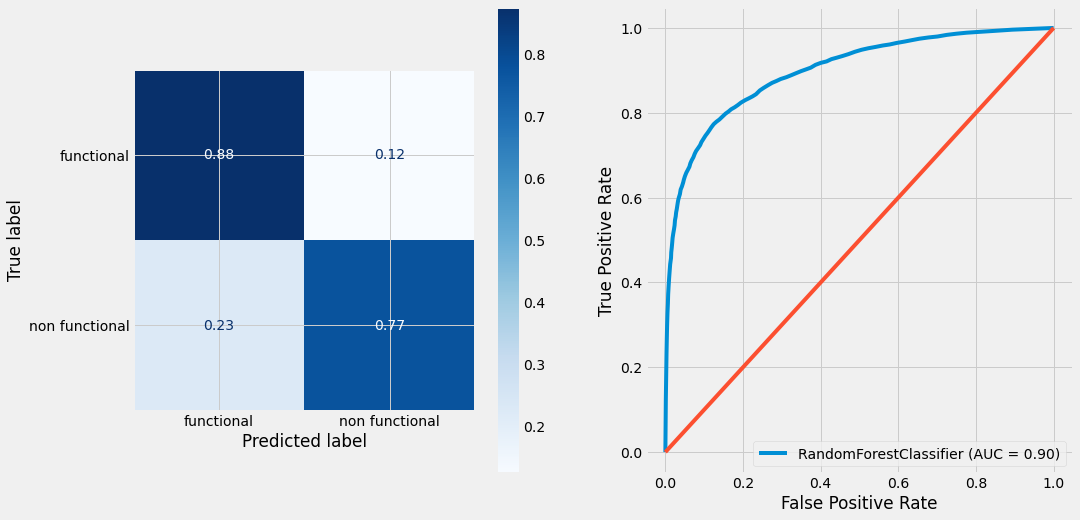

PREVIOUS MODEL


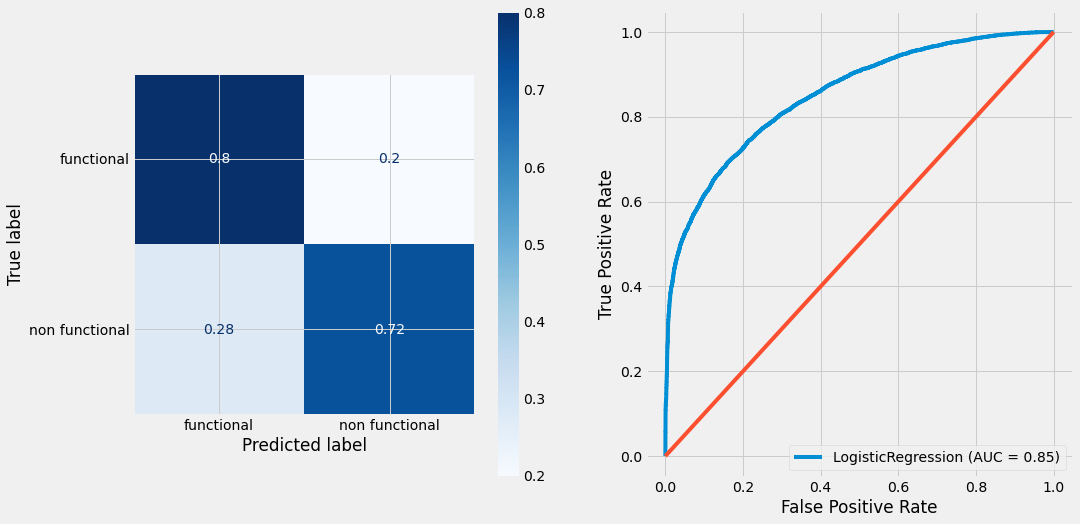

<Figure size 432x288 with 0 Axes>

In [666]:
model_eval(rf_1, X_train_dt, y_train, X_test_dt, y_test, 
           prev_model=lr_3_gridsearch.best_estimator_,
          prev_X_train=X_train_lr, prev_y_train=y_train, prev_X_test=X_test_lr, 
           prev_y_test=y_test)

In [667]:
#number of leaves
rf_1.estimators_[0].get_n_leaves()

8980

In [668]:
#max depth
depths = [m.get_depth() for m in rf_1.estimators_]
max(depths)

77

> **OBSERVATIONS**
> - Vanilla RF model improved Recall by 5% and F1 by 6%. However, the model is overfit to the training data (1.0 vs .76 on recall). This is because I allowed the decision trees to go to completion. 

> **ACTIONS**
> - I will perform a gridsearch to optimize hyperparameters to limit overfitting.


### Model #2

In [669]:
#create RF model
rf_2 = RandomForestClassifier()

In [670]:
#create parameters for gridsearch
params = [{'n_estimators': [1200],
           'criterion': ['gini'],
           'max_features': ['auto'],
           'class_weight': ['balanced'],
           'max_depth':[65],
           'min_samples_split': [3],
           'min_samples_leaf': [1]}]

In [671]:
#create and fit gridsearch
rf_2_gridsearch = GridSearchCV(rf_2, params,scoring='recall',n_jobs=-1, cv=5)
rf_2_gridsearch.fit(X_train_dt, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'class_weight': ['balanced'], 'criterion': ['gini'],
                          'max_depth': [65], 'max_features': ['auto'],
                          'min_samples_leaf': [1], 'min_samples_split': [3],
                          'n_estimators': [1200]}],
             scoring='recall')

### Model Evaluation

In [672]:
#best parameters
rf_2_gridsearch.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 65,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1200}

MODEL EVAL VS PREVIOUS (TEST)


Previous Model Current Model Delta
Recall             0.77          0.78  0.01
F1                  0.8          0.81  0.01
Accuracy           0.83          0.83   0.0
AUC                 0.9           0.9   0.0



CURRENT MODEL: Overfit (Recall)


Recall on Training: 1.0
Recall on Test: 0.78


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      9443
           1       0.83      0.78      0.81      7831

    accuracy                           0.83     17274
   macro avg       0.83      0.83      0.83     17274
weighted avg       0.83      0.83      0.83     17274

Test Graphs------------------------------------------------------


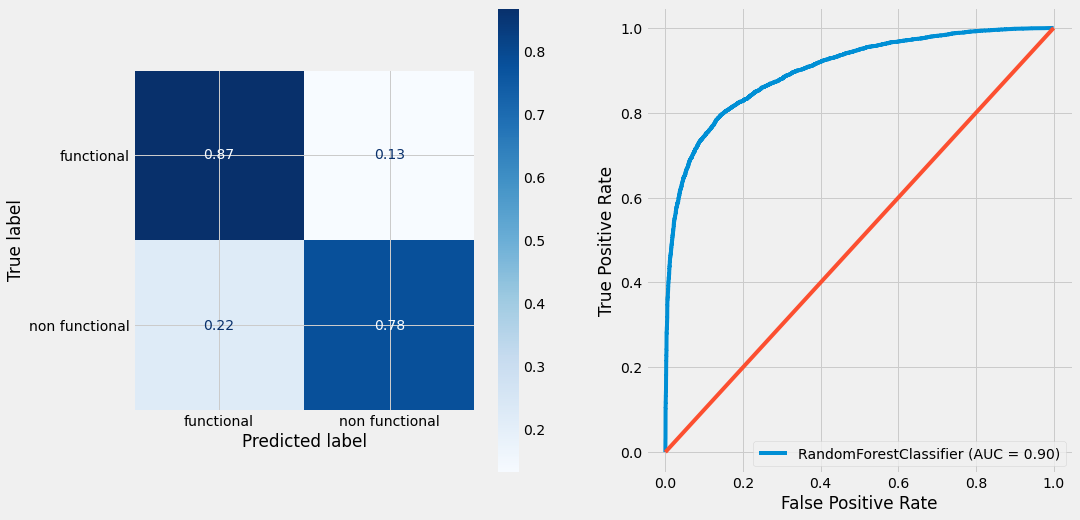

PREVIOUS MODEL


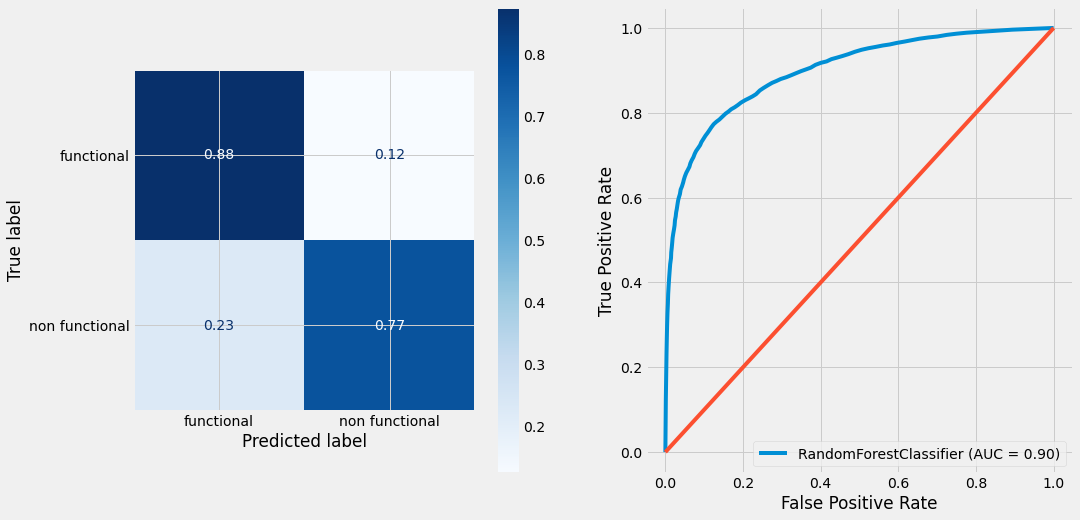

<Figure size 432x288 with 0 Axes>

In [673]:
#evaluate model
model_eval(rf_2_gridsearch.best_estimator_, X_train_dt, y_train, X_test_dt,
          y_test, prev_model=rf_1)

In [674]:
#get features
rf_2_fi = rf_2_gridsearch.best_estimator_.feature_importances_

In [675]:
#convert features into dataframe
rf_2_features = pd.DataFrame(data=rf_2_fi, index=X_train_dt.columns, 
                             columns=['Feature Importances'])
rf_2_features_sorted = rf_2_features[:10].sort_values('Feature Importances', ascending=False)

In [676]:
rf_2_features_sorted

Feature Importances
longitude                                    0.08442144450120317
latitude                                      0.0825900783378199
well_elevation                               0.07299320282504455
well_age                                     0.05917169105369073
population                                   0.05333769182832638
head                                        0.021420460761847313
waterpoint_type_communal standpipe          0.010691703143120372
waterpoint_type_communal standpipe multiple 0.008039287527927225
waterpoint_type_hand pump                   0.006536699148484288
waterpoint_type_improved spring             0.001969613595885796

<AxesSubplot:xlabel='Feature Importances'>

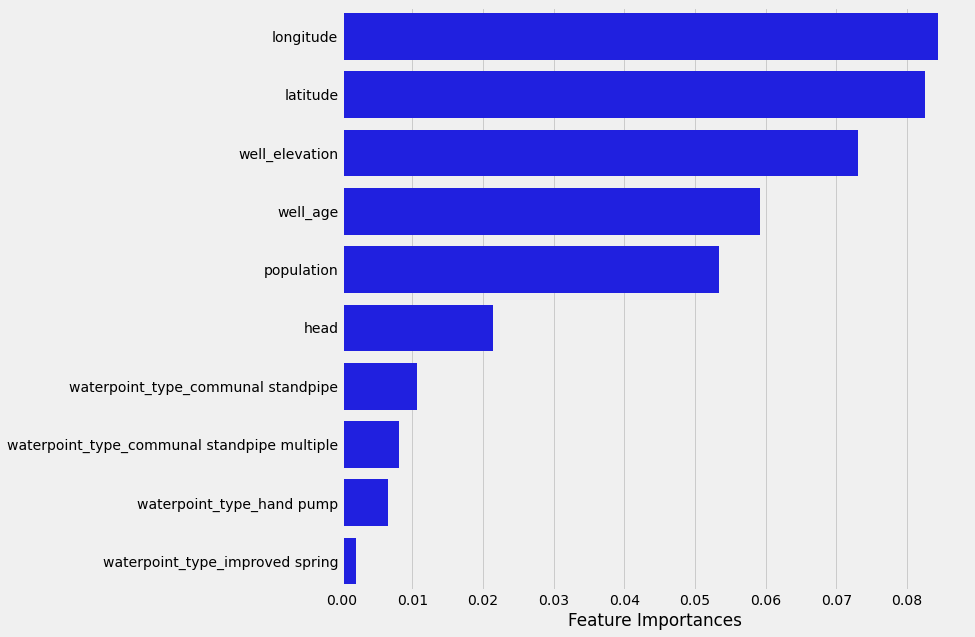

In [677]:
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(data=rf_2_features_sorted, 
            x=rf_2_features_sorted['Feature Importances'], 
            y=rf_2_features_sorted.index, orient='h', color='blue',ax=ax)

In [678]:
# #export feature importances to Tableau
# rf_2_features_sorted.to_csv(r'Data/rf_feature_importances.csv', index=True, header=True)

In [679]:
X_train_dt.corr()['extraction_type_1_gravity'].abs().sort_values(ascending=False)

extraction_type_1_gravity                              1.0
extraction_type_2_gravity                              1.0
source_type_2_spring                    0.6401800459825457
waterpoint_type_communal standpipe      0.6205336281661392
waterpoint_type_hand pump               0.5781182868931056
                                              ...         
ward_Njoro                           0.0014629427538698154
lga_Masasi                           0.0013927206300681917
management_water authority           0.0013218467219152303
district_code_80                     0.0009411891526600825
source_type_2_unknown                0.0006390192559142985
Name: extraction_type_1_gravity, Length: 484, dtype: float64

go straight to random forest, not decision tree. tune max depth

sklearn.metrics get_scorer("accuracy" or "recall", specify as argument in function)

constant for lr under .intercept not .coeffs. intercept=false

precision vs recall graph

**Thoughts on presentation**
- discuss recall being most important and why
- discuss which coefficients drive model performance
- discuss why merging 3 categories for status_group into 2, before and after merge

make docstring have args 47:30 on video of topic 29